# Neural Network

## Toughts 9.10.18
La data devra être mise non pas telle quelle, mais personne par personne (les images n'auront pas toute le même nombre d'images entre elles). Il pourrait également être intéressant de normaliser la data, car actuellement elle dépend fortement de la taille des personnes et de leur position à l'image (cela fait que si personne n'est jamais apparu dans le coin supérieur droit des vidéos, alors le NN ne pourrait jamais reconnaître une personne dans ce coin-là (enfin, évaluer leur attention). 

Hugely inspired from the example of Neural Network from the [pytorch website](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

## Cells to run with definitions

In [1]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import math
import sys
import numpy as np
from tqdm import tnrange, tqdm_notebook
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#===============================================================================================================#

def distance_to_point(xfrom, yfrom, xto, yto):
    '''
    Function that returns the Euclidean distance between two points. Used to later compute the nearest neightbour. 
    '''
    x = xto - xfrom
    y = yto - yfrom
    
    return np.sqrt(x*x + y*y)
    

def nearest_id(x0, y0, positions):
    '''
    Returns the id of the closest point in positions, and the distance to it. 
    
    Arguments
    --------
    x0 -> the x position of the point you want the nearest neightbour of
    y0 -> the y position of the point you want the nearest neightbour of
    positions -> dict containing ids as keys and tuples of coordinates as values
    
    '''
    nearest = 'No answer was found'
    distance = sys.maxsize
    for key, coordinates in positions.items():
        new_dist = distance_to_point(x0, y0, coordinates[0], coordinates[1])
        if (new_dist < distance):
            nearest = key
            distance = new_dist
            
    return nearest, distance

def first_occurence_of_id(id_number, array):
    '''
    Returns the first occurence of the `id_number` in the numpy `array`.
    '''
    return array.searchsorted(id_number)

#===============================================================================================================#

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

#===============================================================================================================#

def train_NNmodel_on_GPU(model, keypoints_train, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        for i in range(keypoints_train.shape[0]):
            #élimine le numéro de frame (non utile au NN)
            current_keypoints = keypoints_train[i][1:]

            x0 = current_keypoints[4]
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            frame_number = int(keypoints_train[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

            x.to(device)
            y.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)
            #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#===============================================================================================================#

def compute_accuracy(y_pred, y, threshold):
    if (y - y_pred < threshold and y_pred - y < threshold):
        return 1
    else:
        return 0

def get_accuracy(model, matrix_x, matrix_y, dict_pos_by_ids, accuracy_threshold):
    ys = []
    y_preds = []
    accuracies = []
    losses = []
    
    loss_function = torch.nn.L1Loss()
    
    with torch.no_grad():
        for i in range(matrix_x.shape[0]):
            #élimine le numéro de frame
            current_keypoints = matrix_x[i][1:]

            x0 = current_keypoints[4] 
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, dict_pos_by_ids)
            frame_number = int(matrix_x[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, matrix_y[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([matrix_y[first_frame_of_id + frame_number][0]], dtype=torch.float)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            loss = loss_function(y_pred, y)
            accuracy = compute_accuracy(y_pred, y, accuracy_threshold)

            ys.append(y.item())
            y_preds.append(np.round(y_pred.item(), 3))
            accuracies.append(np.round(accuracy, 3))
            losses.append(np.round(loss.item(), 3))
    
    
    
    mean_loss = np.mean(losses)
    mean_accuracy = np.mean(accuracies)
    #print('Mean loss: ', mean_loss)
    #print('Mean accuracy: ', mean_accuracy)
    
    data = np.array([ys, y_preds, losses, accuracies])
    headers = ['Expected y', 'Predicted y', 'Loss', 'Accuracy']
    return pd.DataFrame(data.T, columns=headers), mean_loss, mean_accuracy

#===============================================================================================================#

import copy

def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_with_train(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    train_NNmodel_on_GPU(model, m_train, y, positions_by_ids, learning_rate, loss_fn, epochs)
    return get_accuracy(model, m_test, y, positions_by_ids, accuracy_threshold)

def run_cross_validation_with_train(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in range(k_fold):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = cross_validation_with_train(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        print("Accuracy on sample " + str(k+1) + ": " + str(acc_temp) + " with a mean loss of:" + str(loss_temp))
        
    return results, pd.DataFrame(losses, columns=['Mean Losses']), pd.DataFrame(accuracies, columns=['Mean accuracies'])

#===============================================================================================================#

def train_NNmodel_and_cross_validation(model, keypoints_train, keypoints_validation, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, accuracy_threshold=0.5):
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results, losses, accuracies = pd.DataFrame(), [], []

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        for i in range(keypoints_train.shape[0]):
            #élimine le numéro de frame (non utile au NN)
            current_keypoints = keypoints_train[i][1:]

            x0 = current_keypoints[4]
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            frame_number = int(keypoints_train[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

            x.to(device)
            y.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)
            #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        results_temp, loss_temp, acc_temp = get_accuracy(model, keypoints_validation, attention_levels, positions_by_ids, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def cross_validation_per_epoch(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_and_cross_validation(model, m_train, m_test, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)


def run_cross_validation_per_epoch(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in log_progress(range(k_fold), name='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = cross_validation_per_epoch(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return results, pd.DataFrame(losses), pd.DataFrame(accuracies)

#===============================================================================================================#

def cross_validation_visualization(lambdas, loss_train, loss_test):
    """visualization the curves of loss_train and loss_test."""
    plt.semilogx(lambdas, loss_train, marker=".", color='b', label='train error')
    plt.semilogx(lambdas, loss_test, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation_mse")
    
def cross_validation_visualization_accuracy(epochs, accs, save=False, filename="cross_validation_acc"):
    """visualization the curve of accuracy"""
    plt.plot(epochs, accs, marker=".", color='r', label='accuracy')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig(filename)
    
def cross_validation_visualization_accuracy_multiple(epochs, accs, save=False, filename="cross_validation_acc_multiple"):
    """visualization the curve of accuracy"""
    
    for i in range(accs.shape[0]):
        plt.plot(epochs, accs[i], marker=".", color='r', label=str(i+1)+'th accuracy')
        
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig(filename)
    
def cross_validation_visualization_mean(epochs, means, save=False, filename = "cross_validation_mean"):
    """visualization the curve of means"""
    plt.plot(epochs, means, marker=".", color='b', label='means')
    plt.xlabel("epoch")
    plt.ylabel("mean loss")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig(filename)
    
def cross_validation_visualization_mean_multiple(epochs, means, save=False, filename='cross_validation_mean_multiple'):
    """visualization the curve of mean error"""
    
    for i in range(means.shape[0]):
        plt.plot(epochs, means[i], marker=".", color='b', label=str(i+1) + 'th means')
        
    plt.xlabel("epoch")
    plt.ylabel("mean error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig(filename)
        
        
#===============================================================================================================#

def train_NNmodel_batch(model, keypoints_train, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, batch_size):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(keypoints_train.shape[0], batch_size, replace=False)
        #get the columns that correspond to these 
        x_with_frames = keypoints_train[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)

        #create the corresponding ys
        frame_numbers = np.array(x_with_frames[:, 1])
        frame_numbers = frame_numbers.astype(int)
        y_temp = []
        for i in range(frame_numbers.shape[0]):
            x0, y0 = x_temp[i][4], x_temp[i][5]
            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
            y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])           
        
        
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        
        
        #should speed up considerably the training, and maybe better the results
        #DELETE THE FOR LOOP AND ADAPT CODE
        
        #for i in range(keypoints_train.shape[0]):
        #    #élimine le numéro de frame (non utile au NN)
        #    current_keypoints = keypoints_train[i][1:]

        #    x0 = current_keypoints[4]
        #    y0 = current_keypoints[5]

        #    current_id, _ = nearest_id(x0, y0, positions_by_ids)
        #    frame_number = int(keypoints_train[i][0])
        #    first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
        #    x = torch.tensor(current_keypoints, dtype = torch.float, device=device)
        #    y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float, device=device)
        
        

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
#===============================================================================================================#            

#validation for batch version of NN
def train_NNmodel_validation_batch(model, keypoints_train, keypoints_validation, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, batch_size, accuracy_threshold):
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    results, losses, accuracies = pd.DataFrame(), [], []
    
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(keypoints_train.shape[0], batch_size, replace=False)
        #get the columns that correspond to these 
        x_with_frames = keypoints_train[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)

        #create the corresponding ys
        frame_numbers = np.array(x_with_frames[:, 1])
        frame_numbers = frame_numbers.astype(int)
        y_temp = []
        for i in range(frame_numbers.shape[0]):
            x0, y0 = x_temp[i][4], x_temp[i][5]
            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
            y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])           
        
        
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
            
        results_temp, loss_temp, acc_temp = get_accuracy(model, keypoints_validation, attention_levels, positions_by_ids, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def validation_batch(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_validation_batch(model, m_train, m_test, y, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)


def run_validation_batch(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, batch_size=64, accuracy_threshold=0.5, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in log_progress(range(k_fold), name='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = validation_batch(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return results, pd.DataFrame(losses), pd.DataFrame(accuracies)
        
        

#===============================================================================================================#
def compute_and_append_ys(xs, attention_levels, positions_by_ids):
    y_temp = []
    
    for i in range(xs.shape[0]):
        x0, y0 = xs[i][5], xs[i][6] # +1 à cause du numéro de frame

        #create the corresponding ys
        frame_numbers = np.array(xs[:, 1])
        frame_numbers = frame_numbers.astype(int)

        current_id, _ = nearest_id(x0, y0, positions_by_ids)
        first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
        y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])        

    ys = np.array([y_temp])
    ys = ys.astype(int)
    
    return np.concatenate((ys.T, xs), axis=1)

#===============================================================================================================#

def train_NNmodel_batch_precomputed(model, matrix, learning_rate, loss_fn, number_of_epochs, batch_size):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        ys = matrix[:, 0] #prend les niveaux d'attention 
        xs = matrix[:, 1:]
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(xs.shape[0], batch_size, replace=False)
        #get the rows that correspond to these 
        x_with_frames = xs[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)         
        
        y_temp = ys[indexes_batch]
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#===============================================================================================================#

#validation for batch version of NN, with precomputed ys

def compute_accuracy_vector(y_pred, y, threshold):
    #print(y)
    #print(y_pred)
    #print(np.count_nonzero((y_pred - y) < threshold))
    return np.count_nonzero(np.logical_and((y - y_pred) < threshold, (y_pred - y) < threshold))
        

def get_accuracy_vector(model, matrix, batch_size, accuracy_threshold):
    
    indexes_batch = np.random.choice(matrix.shape[0], batch_size, replace=False)
    #get the rows that correspond to these 
    matrix_selected = matrix[indexes_batch]
    
    ys = matrix_selected[:, 0]
    xs = matrix_selected[:, 2:]
    
    y_preds = np.empty([0, 1])
    accuracies = []
    losses = []
    
    loss_function = torch.nn.L1Loss()
    
    with torch.no_grad():

        #transforme en data compréhensible par le NN et élimine le numéro de frame
        x = torch.tensor(xs, dtype = torch.float)
        y = torch.tensor([ys], dtype=torch.float)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        loss = loss_function(y_pred, y)
        accuracy = compute_accuracy_vector(y_pred.cpu().numpy(), y.cpu().numpy(), accuracy_threshold)

        y_preds = np.vstack((y_preds, np.round(y_pred, 3)))
        accuracies.append(np.round(accuracy, 3))
        losses.append(np.round(loss.item(), 3))
    
    
    
    mean_loss = np.mean(losses)
    mean_accuracy = np.mean(accuracies)
    
    data = np.array([ys, y_preds, losses, accuracies])
    #headers = ['Expected y', 'Predicted y', 'Loss', 'Accuracy']
    return data, mean_loss, mean_accuracy



def train_NNmodel_validation_batch(model, matrix_train, matrix_validation, learning_rate, loss_fn, number_of_epochs, batch_size, accuracy_threshold):
    
    results, losses, accuracies = [], [], []
   
    
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm_notebook(range(number_of_epochs), desc='Epoch', leave=False):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(matrix_train.shape[0], batch_size, replace=False)
        #get the rows that correspond to these 
        matrix_selected = matrix_train[indexes_batch]
        
        ys = matrix_selected[:, 0] #prend les niveaux d'attention (les y)
        xs = matrix_selected[:, 2:] #create a matrix that is (batch_size * D_in) dimensions / ignores the frame numbers

        #give directly the matrix as input to the model
        x = torch.tensor(xs, dtype = torch.float, device=device)         
        
        y = torch.tensor([ys], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        results_temp, loss_temp, acc_temp = get_accuracy_vector(model, matrix_validation, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def validation_batch(model, x, k_indices, k, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_validation_batch(model, m_train, m_test, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)


def run_validation_batch(model, x, learning_rate, loss_fn, epochs, batch_size=64, accuracy_threshold=0.5, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = [], [], []
    for k in tqdm_notebook(range(k_fold), desc='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = validation_batch(m2, x, k_indices, k, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return pd.DataFrame(results), pd.DataFrame(losses), pd.DataFrame(accuracies)

#===============================================================================================================#

def find_size_cloud_np(matrix):
    temp = np.copy(matrix)
    keypoints_x = temp[::2]
    keypoints_y = temp[1::2]
    
    x_min = np.min(keypoints_x[np.nonzero(keypoints_x)]) 
    x_max = np.max(keypoints_x[np.nonzero(keypoints_x)])
    y_min = np.min(keypoints_y[np.nonzero(keypoints_y)])
    y_max = np.max(keypoints_y[np.nonzero(keypoints_y)])
    
    return x_min, x_max, y_min, y_max

def find_size_cloud(keypoints):
    temp = np.copy(keypoints)
    x_min, x_max, y_min, y_max = 100000, -1, 100000, -1
    
    for i in range(temp.shape[0]):
        t = temp[i]
        
        if (t != 0): #ignorer coordonnées égales à 0
            if (i % 2 == 0): #indice pair, donc coordonnée x
                if (t > x_max):
                    x_max = t
                elif (t < x_min):
                    x_min = t

            else: #indice impair, donc coordonnée y
                if (t > y_max):
                    y_max = t
                elif (t < y_min):
                    y_min = t
                    
    return x_min, x_max, y_min, y_max

def center_keypoints(keypoints):
    result = np.copy(keypoints)
    x_min, x_max, y_min, y_max = find_size_cloud(result)
    
    x_mean = (x_max - x_min)/2 + x_min
    y_mean = (y_max - y_min)/2 + y_min
    
    keypoints_x = result[::2]
    keypoints_y = result[1::2]
    
    for i in range(result.shape[0]):
        t = result[i]
        if (t != 0): #ignorer coordonnées égales à 0
            if (i % 2 == 0): #indice pair, donc coordonnée x
                result[i] = t - x_mean

            else: #indice impair, donc coordonnée y
                result[i] = t - y_mean
    return result
    
    
def resize_keypoints(matrix):
    result = np.copy(matrix)
    x_min, x_max, y_min, y_max = find_size_cloud(result)
    
    factor = 1 / np.max([x_max - x_min, y_max - y_min])
    
    result = np.multiply(result, factor)
    
    return result

def delete_confidence(matrix):
    result = np.copy(matrix)
    if (matrix.shape[0] == 75):
        return np.delete(result, np.arange(2, result.size, 3))
    else:
        raise TypeError('The matrix had shape ' + str(matrix.shape) + ' which was not expected. ')

def delete_legs(matrix):
    temp = np.copy(matrix)
    
    #places des coordonnées des jambes
    ids_legs = [9, 8, 12, 10, 13, 11, 24, 21, 14, 23, 22, 19, 20]
    
    for i in ids_legs:
        temp[i*2] = 0
        temp[i*2+1] = 0
        
    return temp


def normalize(matrix):
    temp = np.copy(matrix)
    result = []
    for i in range(temp.shape[0]):
        row = temp[i, 2:]
        row_norm = center_keypoints(resize_keypoints(delete_legs(delete_confidence(row))))
        
        result.append(np.append(temp[i, :2], row_norm))
    
    return np.array(result)

#===============================================================================================================#

def enlever_ids_validation(matrix, ids):
    training_matrix = []
    validation_matrix = []
    for i in range(matrix.shape[0]):
        row = matrix[i]
        if (row[0] in ids): 
            validation_matrix.append(row[1:])
        else:
            training_matrix.append(row[1:])
            
    return np.asarray(training_matrix), np.asarray(validation_matrix)

def distance_to_point(xfrom, yfrom, xto, yto):
    '''
    Function that returns the Euclidean distance between two points. Used to later compute the nearest neightbour. 
    '''
    x = xto - xfrom
    y = yto - yfrom
    
    return np.sqrt(x*x + y*y)
    

def nearest_id(x0, y0, positions):
    '''
    Returns the id of the closest point in positions, and the distance to it. 
    
    Arguments
    --------
    x0 -> the x position of the point you want the nearest neightbour of
    y0 -> the y position of the point you want the nearest neightbour of
    positions -> dict containing ids as keys and tuples of coordinates as values
    
    '''
    nearest = 'No answer was found'
    distance = sys.maxsize
    for key, coordinates in positions.items():
        new_dist = distance_to_point(x0, y0, coordinates[0], coordinates[1])
        if (new_dist < distance):
            nearest = key
            distance = new_dist
            
    return int(nearest), distance

def first_occurence_of_id(id_number, array):
    '''
    Returns the first occurence of the `id_number` in the numpy `array`.
    '''
    indices = np.where(array==(id_number))
    if (indices[0].size != 0):
        minim = np.min(indices)
        return minim
    else:
        return 0

def put_id_and_compute_and_append_ys(xs, attention_levels, positions_by_ids):
    y_temp = []
    ids = []
    
    for i in range(xs.shape[0]):
        x0, y0 = xs[i][4], xs[i][5] # +1 à cause du numéro de frame

        #create the corresponding ys
        frame_numbers = np.array(xs[:, 0])
        frame_numbers = frame_numbers.astype(int)

        current_id, _ = nearest_id(x0, y0, positions_by_ids)
        ids.append(current_id)
        first_occurence = first_occurence_of_id(int(current_id), attention_levels[:, 1])
        level = first_occurence + frame_numbers[i]
        #print(current_id, first_occurence, frame_numbers[i], level)
        y_temp.append(attention_levels[level][0])        

    ys = np.array(y_temp)
    ys = ys.astype(int)
    ids = np.array(ids)
    
    return np.concatenate((ids[:, np.newaxis], ys[:, np.newaxis], xs), axis=1)


def normalize(matrix):
    temp = np.copy(matrix)
    result = []
    for i in range(temp.shape[0]):
        row = temp[i, 3:]
        row_norm = center_keypoints(resize_keypoints(delete_legs(delete_confidence(row))))
        
        result.append(np.append(temp[i, :3], row_norm))
    
    return np.array(result)

#===============================================================================================================#

def compute_accuracy_vector(y_pred, y, threshold):
    count = np.count_nonzero(np.logical_and((y - y_pred) < threshold, (y_pred - y) < threshold))
    return count / y_pred.size
        

def get_accuracy_vector(model, matrix, batch_size, accuracy_threshold):
    matrix_selected = matrix
    
    ys = matrix_selected[:, 0]
    xs = matrix_selected[:, 2:]
    
    y_preds = np.empty([0, 1])
    accuracies = []
    losses = []
    
    loss_function = torch.nn.L1Loss()
    
    with torch.no_grad():

        #transforme en data compréhensible par le NN et élimine le numéro de frame
        x = torch.tensor(xs, dtype = torch.float)
        y = torch.tensor([ys], dtype=torch.float)
        y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        loss = loss_function(y_pred, y)
        accuracy = compute_accuracy_vector(y_pred.cpu().numpy(), y.cpu().numpy(), accuracy_threshold)

        y_preds = np.vstack((y_preds, np.round(y_pred, 3)))
        accuracies.append(np.round(accuracy, 3))
        losses.append(np.round(loss.item(), 3))
    
    
    
    mean_loss = np.mean(losses)
    mean_accuracy = np.mean(accuracies)
    
    data = np.array([ys, y_preds, losses, accuracies])
    #headers = ['Expected y', 'Predicted y', 'Loss', 'Accuracy']
    return data, mean_loss, mean_accuracy



def train_NNmodel_validation_batch(model, matrix_train, matrix_validation, learning_rate, loss_fn, number_of_epochs, batch_size, accuracy_threshold):
    
    results, losses, accuracies = [], [], []
   
    
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm_notebook(range(number_of_epochs), desc='Epoch', leave=False):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(matrix_train.shape[0], batch_size, replace=False)
        #get the rows that correspond to these 
        matrix_selected = matrix_train[indexes_batch]
        
        ys = matrix_selected[:, 0] #prend les niveaux d'attention (les y)
        xs = matrix_selected[:, 2:] #create a matrix that is (batch_size * D_in) dimensions / ignores the frame numbers

        #give directly the matrix as input to the model
        x = torch.tensor(xs, dtype = torch.float, device=device)         
        
        y = torch.tensor([ys], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        results_temp, loss_temp, acc_temp = get_accuracy_vector(model, matrix_validation, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies

def run_new_validation_batch(model, m_train, m_validation, learning_rate, loss_fn, epochs, batch_size=64, accuracy_threshold=0.5, k_fold=5):
    results, losses, accuracies = [], [], []
    for k in tqdm_notebook(range(k_fold), desc='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = train_NNmodel_validation_batch(model, m_train, m_validation, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return results, losses, accuracies

In [2]:
file_model = 'model_m_file'
#m = torch.nn.Sequential(torch.nn.Linear(D_in, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(), torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, D_out),)
#m.load_state_dict(torch.load(file_model))
#m.eval()
#torch.save(m.state_dict(), f=file_model)

In [ ]:
#Imports and preparation for OpenPose

import sys
import cv2
import os
from sys import platform
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


__file__ = os.path.realpath('C:/Users/Marku/Documents_no_sync/Projet_Bachelor/openpose/build/python/openpose/__init__.py')
sys.path.append(os.path.realpath('C:\\Users\\Marku\\Documents_no_sync\\Projet_Bachelor\\openpose\\build\\examples\\tutorial_api_python'))
dir_path = os.path.dirname(os.path.realpath(__file__))
if platform == "win32": sys.path.append(dir_path + '/../../python/openpose/');
else: sys.path.append('../../python');

try:
    from openpose import *
except:
    raise Exception('Error: OpenPose library could not be found. Did you enable `BUILD_PYTHON` in CMake and have this Python script in the right folder?')
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "368x-1"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.3
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu_start"] = 0
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = dir_path + "/../../../models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

print("Imports and start of openpose success !")


End of cells to run for definitions and imports

------

In [ ]:
#image selection, processing, and display

# Read new image
# "../../../../../../Documents_no_sync/Projet_Bachelor/data/" == data of the project
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0200001.jpg")

# Output keypoints and the image with the human skeleton blended on it
keypoints = openpose.forward(img)

In [ ]:
for i in range(keypoints.shape[0]):
    print(keypoints[i].shape)
    print(keypoints[i].flatten().shape)

In [ ]:
x_temp = keypoints[0].flatten()
attention_levels = [6, 7, 6, 8, 9, 7, 5, 6, 8, 8] #no data yet ?

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, x_temp.flatten().shape[0], 100, 1

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
number_of_iterations = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(number_of_iterations):
    for i in range (keypoints.shape[0]):

        #transferring the data into pytorch tensors, necessary to be able to do the nn operations

        x = torch.from_numpy(keypoints[i].flatten())
        y = torch.tensor([attention_levels[i]], dtype=torch.float) #converting the data format, otherwise doesn't accept it
    
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print(t, loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

In [ ]:
for i in range(keypoints.shape[0]):
    print(model(torch.from_numpy(keypoints[i].flatten())))

### Conclusion
Great, now the main thing is that it works. The problem is that it doesn't use the data from the project, and is based on only one image. I should import the data from the excel, and store all the keypoints in an array. (See notebook about importing and saving data)

### Concerns
Une fois que toute la data sera importée, ne pas itérer sur tout mais créer des mini-batchs aléatoires.

Regarder dans quels ordre openpose me sort les personnes qui sont dans l'image, afin de pouvoir les matcher avec les images avec indices qui m'ont été données. 

Comme output totalement final, le but serait de récupérer les niveaux d'attentions d'OpenPose, et les coordonnées de la tête dans les keypoints, pour ensuite prendre l'image rentrée en input et display des bounding boxes autour de la tête des participants avec leur niveau d'attention au dessus.

## Second try
With the real data this time !
### Data import
Straight out the corresponding notebook. 
#### Excel for attention level data

In [ ]:
file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 93) | (df1['Participant'] == 105)]

df_selected = df_participants[['Global Attention Rating', 'Participant']]
df_selected

#### Numpy arrays from the extracted pictures for body keypoints

In [ ]:
keypoints_file = 'keypoints_file_pierre_cam4'
imported_keypoints = np.load(keypoints_file + '.npy')

In [ ]:
flattened_keypoints = np.zeros((keypoints[0].flatten().shape[0], 1))
for i in range(0, imported_keypoints.shape[1], 3):
    temp = imported_keypoints[:, i:i+3]
    flattened_keypoints = np.concatenate((flattened_keypoints, temp.flatten()[:, np.newaxis]), axis=1)
    

flattened_keypoints = flattened_keypoints[:, 1:] #removes the first column that was created at the beginning
print(flattened_keypoints.shape, ' has the correct shape ?')
print(flattened_keypoints.shape[0] == imported_keypoints.shape[0] * 3 and flattened_keypoints.shape[1] == imported_keypoints.shape[1] / 3)

### Neural Net construction

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = 64, flattened_keypoints.shape[0], 100, 1

#transferring the data into pytorch tensors, necessary to be able to do the nn operations
keypoints_input = flattened_keypoints.T
attention_levels = df_selected['Global Attention Rating'].values

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
number_of_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(number_of_epochs):
    for i in range (batch_size):
        actual_data = np.random.randint(0, flattened_keypoints.shape[0])
        

        x = torch.tensor([keypoints_input[actual_data]], dtype = torch.float)
        y = torch.tensor([[attention_levels[actual_data]]], dtype=torch.float)
    
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print(epoch, loss.item())

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

In [ ]:
for i in range(10):
    print("y =", attention_levels[i], "y_pred = ", model(torch.tensor([keypoints_input[i]], dtype=torch.float)))

Problème actuel: prend en compte les données de trop de personnes. Solution: isoler les élèves qui nous intéressent à la main dans keypoints, ou masquer l'image (viable car les caméras ne bougent pas). 
Dans le notebook sur l'import de data, j'ai créé une version de la même data mais avec les images masquées, pour garder uniquement les étudiants 93 et 105 (ceux qui nous intéressent actuellement). 

In [ ]:
keypoints_masked_file = 'keypoints_file_pierre_cam4_masked'
masked_keypoints = np.load(keypoints_masked_file + '.npy')

In [ ]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = 64, masked_keypoints.shape[0], 100, 1

#transferring the data into pytorch tensors, necessary to be able to do the nn operations
keypoints_input = masked_keypoints.T
attention_levels = df_selected['Global Attention Rating'].values

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
number_of_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(number_of_epochs):
    for i in range (batch_size):
        actual_data = np.random.randint(0, flattened_keypoints.shape[0])

        x = torch.tensor([keypoints_input[actual_data]], dtype = torch.float)
        y = torch.tensor([[attention_levels[actual_data]]], dtype=torch.float)
    
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print('Epoch: ', epoch, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Il y a maintenant encore 2 problèmes: je ne sais pas lequel des modèles est pris à chaque fois, et les niveaux d'attentions ne sont pas forcément en adéquation avec l'input donné. En prenant les keypoints qui sortent d'OpenPose, j'ai accès aux coordonnées xy des keypoints de chaque modèle, et je peux ainsi déduire ainsi duquel il s'agit. Quand aux y, si je sais de quel modèle il s'agit, je peux ainsi indiquer quelle ligne prendre dans la matrice des y, car ils sont rangés de telle manière que toutes les données pour un seul élève se suivent dans la matrice (il y a 446 niveaux d'attention, 1 toutes les 10 secondes, pour chaque élève). 

In [ ]:
#flattening the input, because all (25, 3) belong to the same model
flattened_keypoints = np.zeros((keypoints[0].flatten().shape[0], 1))
for i in range(0, masked_keypoints.shape[1], 3):
    temp = imported_keypoints[:, i:i+3]
    flattened_keypoints = np.concatenate((flattened_keypoints, temp.flatten()[:, np.newaxis]), axis=1)
    
flattened_keypoints = flattened_keypoints[:, 1:] #removes the first column that was created at the beginning
print(flattened_keypoints.shape, 'is the correct shape ?')
print(flattened_keypoints.shape[0] == masked_keypoints.shape[0] * 3 and flattened_keypoints.shape[1] == masked_keypoints.shape[1] / 3)


#transferring the data into pytorch tensors, necessary to be able to do the nn operations
keypoints_input = flattened_keypoints.T
attention_levels = df_selected['Global Attention Rating'].values

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = 64, flattened_keypoints.shape[0], 100, 1

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
number_of_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(number_of_epochs):
    for i in range (batch_size):
        actual_data = np.random.randint(0, keypoints_input.shape[0])

        x = torch.tensor(keypoints_input[actual_data], dtype = torch.float)
        print(x[25]) #cela sépare les 2 élèves
        
        y = torch.tensor([attention_levels[actual_data]], dtype=torch.float)
        
        if (x[0] > 1000):
            y = torch.tensor([attention_levels[actual_data + 446]], dtype=torch.float)
    
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print('Epoch: ', epoch, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for i in range(10):
    print("y =", attention_levels[i], "y_pred = ", model(torch.tensor([keypoints_input[i]], dtype=torch.float)))

## Résolution du problème d'identification des ids et des attributions d'y
L'idée générale lancée a été de créer une sorte de dict sur la première frame de l'image: id -> [coordonnée x, coordonnée y]. Utiliser les coordonnées du centre de la poitrine me semble optimal pour cela. Pour les frames suivantes, il est possible de retrouver l'id correspondante en effectuant une sorte de nearest neightbour. 

In [ ]:
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0200001.jpg")

keypoints, image = openpose.forward(img, True)

for i in range (keypoints.shape[0]):
    #torso is point 1
    x = keypoints[i][1][0]
    y = keypoints[i][1][1]
    print('[', x, ',', y, ']')

plt.imshow(image)

In [ ]:
#création du dict
positions_by_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

In [ ]:
def distance_to_point(xfrom, yfrom, xto, yto):
    '''
    Function that returns the Euclidean distance between two points. Used to later compute the nearest neightbour. 
    '''
    x = xto - xfrom
    y = yto - yfrom
    
    return np.sqrt(x*x + y*y)
    

def nearest_id(x0, y0, positions):
    '''
    Returns the id of the closest point in positions, and the distance to it. 
    
    Arguments
    --------
    x0 -> the x position of the point you want the nearest neightbour of
    y0 -> the y position of the point you want the nearest neightbour of
    positions -> dict containing ids as keys and tuples of coordinates as values
    
    '''
    nearest = 'No answer was found'
    distance = sys.maxsize
    for key, coordinates in positions.items():
        new_dist = distance_to_point(x0, y0, coordinates[0], coordinates[1])
        if (new_dist < distance):
            nearest = key
            distance = new_dist
            
    return nearest, distance

def first_occurence_of_id(id_number, array):
    '''
    Returns the first occurence of the `id_number` in the numpy `array`.
    '''
    return array.searchsorted(id_number)

In [ ]:
#test of the dict and functions
img_test = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0203601.jpg")

keypoints_test, image_test = openpose.forward(img_test, True)

print(keypoints_test.shape)

for i in range (keypoints_test.shape[0]):
    #torso is point 1
    x = keypoints_test[i][1][0]
    y = keypoints_test[i][1][1]
    print('[', x, ',', y, ']')
    
    near_id, near_distance = nearest_id(x, y, positions_by_ids)
    
    print(near_id, near_distance)
    
flat_test = keypoints_test[0].flatten()
print(keypoints_test[0])
print(flat_test)
    
    
plt.imshow(image_test)

-----
# Nouvel algorithme
1. Extraire les keypoints avec OpenPose, les séparer par personne, les flatten, ajouter une dimension qui contient la frame de laquelle ils ont été extraits (on se retrouve donc avec des arrays 76x1). Les conctenate afin de créer un matrice 76xnombre_de_keypoints. Cela fait que chaque colonne dans cette matrice représente une personne a un moment donné. La garantie intéressante est que pour une personne donnée, les positions sont dans l'ordre chronologique. De plus, si on regarde l'entier de la matrice, les colonnes sont dans l'ordre chronologique croissant (mais pas strict). 
1. Séparer les keypoints en training et validation
2. Se baser sur la première frame pour créer à la main un dict id -> coordonnées x et y du torse
3. Boucle for sur chaque colonne de la matrice keypoints:
    1. Trouver l'id du nearest neightbour
    2. Feed les keypoints (sans la frame, donc retour à 75x1 comme dimension) en x au NN, et comparer au y, qui est le niveau d'attention extrait de la dataframe panda, à partir de l'info d'id et de frame en cours. x = (75x1), y appartient à [1, 10]
    3. Faire tourner le NN
    4. Update le dict avec les coordonnées actuelles du torse des keypoints correspondants. 
    5. Faire plusieurs fois cette boucle ?
4. Faire la matrice keypoints pour le validation set. 
5. Comparer avec le test set. (faire une sorte de k-fold cross-validation ?)

In [ ]:
#test de la disponibilité des images et des dimensions
# "../../../../../../Documents_no_sync/Projet_Bachelor/data/" == data of the project
img = cv2.imread("../../../../../../Documents_no_sync/Projet_Bachelor/data/03_131022_cscw_pierre_02/pictures_extracted/cam4/pierre_0200001.jpg")
# Output keypoints and the image with the human skeleton blended on it
keypoints = openpose.forward(img)
#=================================================================================#

keypoints_flat_frame_number_file = 'keypoints_file_pierre_cam4_flat_frame_number'
flat_frame_number_keypoints = np.load(keypoints_flat_frame_number_file + '.npy').T
print('The matrix containing all the keypoints has shape ' + str(flat_frame_number_keypoints.shape))

#Séparation des données en training et validation

PERCENTAGE_FOR_VALIDATION = 0.1

#separation_point = np.ceil(flat_frame_number_keypoints.shape[0] * (1-PERCENTAGE_FOR_VALIDATION)).astype(np.int64)
#keypoints_train = flat_frame_number_keypoints[:separation_point]
#keypoints_validation = flat_frame_number_keypoints[separation_point:]
#print('The matrix containing all the training keypoints has shape ' + str(keypoints_train.shape))
#print('The matrix containing all the validation keypoints has shape ' + str(keypoints_validation.shape))

#=================================================================================#

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 93) | (df1['Participant'] == 105)]

df_selected = df_participants[['Global Attention Rating', 'Participant']]
df_selected

In [ ]:
#transferring the data into pytorch tensors, necessary to be able to do the nn operations
attention_levels = df_selected.values

#création du dict
positions_by_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = None, keypoints_train.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
number_of_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(number_of_epochs):
    for i in range(keypoints_train.shape[0]):
        #élimine le numéro de frame (non utile au NN)
        current_keypoints = keypoints_train[i][1:]

        x0 = current_keypoints[4]
        y0 = current_keypoints[5]

        current_id, _ = nearest_id(x0, y0, positions_by_ids)
        frame_number = int(keypoints_train[i][0])
        first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

        #transforme en data compréhensible par le NN
        x = torch.tensor(current_keypoints, dtype = torch.float)
        y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

---- 
### Faire tourner sur le GPU
Test cpu version VS GPU version

In [ ]:
(print(torch.backends.cudnn.enabled))

In [ ]:
%%timeit #version sur le CPU, afin de pouvoir comparer les temps

attention_levels = df_selected.values

#création du dict
positions_by_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = None, keypoints_train.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
number_of_epochs = 100
epoch = 0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(keypoints_train.shape[0]):
    #élimine le numéro de frame (non utile au NN)
    current_keypoints = keypoints_train[i][1:]

    x0 = current_keypoints[4]
    y0 = current_keypoints[5]

    current_id, _ = nearest_id(x0, y0, positions_by_ids)
    frame_number = int(keypoints_train[i][0])
    first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

    #transforme en data compréhensible par le NN
    x = torch.tensor(current_keypoints, dtype = torch.float)
    y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
# checks what GPUs are available, and sets them to be used by cuda adn pytorch

torch.cuda.device_count()
print(torch.cuda.current_device())
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
%%timeit

torch.set_default_tensor_type('torch.cuda.FloatTensor')

attention_levels = df_selected.values

#création du dict
positions_by_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = None, keypoints_train.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
number_of_epochs = 100
epoch = 0
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for i in range(keypoints_train.shape[0]):
    #élimine le numéro de frame (non utile au NN)
    current_keypoints = keypoints_train[i][1:]

    x0 = current_keypoints[4]
    y0 = current_keypoints[5]

    current_id, _ = nearest_id(x0, y0, positions_by_ids)
    frame_number = int(keypoints_train[i][0])
    first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

    #transforme en data compréhensible par le NN
    x = torch.tensor(current_keypoints, dtype = torch.float)
    y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)
    
    x.to(device)
    y.to(device)

    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

The GPU version is a lot faster, as we can see.   
CPU mean runtime : 16.8 sec  
GPU mean runtime : 6.14 sec

# Version finale du NN à faire tourner sur GPU
(A améliorer encore avec des batchs)

In [ ]:
# Legacy version
#transferring the data into pytorch tensors, necessary to be able to do the nn operations
attention_levels = df_selected.values

#création du dict
positions_by_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = None, keypoints_train.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

#to run on GPU
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4
number_of_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(number_of_epochs):
    for i in range(keypoints_train.shape[0]):
        #élimine le numéro de frame (non utile au NN)
        current_keypoints = keypoints_train[i][1:]

        x0 = current_keypoints[4]
        y0 = current_keypoints[5]

        current_id, _ = nearest_id(x0, y0, positions_by_ids)
        frame_number = int(keypoints_train[i][0])
        first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

        #transforme en data compréhensible par le NN
        x = torch.tensor(current_keypoints, dtype = torch.float)
        y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

        x.to(device)
        y.to(device)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
#parameters of the NN

#création du dict
pos_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = None, flat_frame_number_keypoints.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lambda_ = 1e-4
epochs = 100
loss = torch.nn.MSELoss(reduction='sum')

In [ ]:
def train_NNmodel_on_GPU(model, keypoints_train, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        for i in range(keypoints_train.shape[0]):
            #élimine le numéro de frame (non utile au NN)
            current_keypoints = keypoints_train[i][1:]

            x0 = current_keypoints[4]
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            frame_number = int(keypoints_train[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

            x.to(device)
            y.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)
            #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [ ]:
train_NNmodel_on_GPU(m, keypoints_train, df_selected.values, pos_ids, lambda_, loss, epochs)

#### Comparison (cross-validation)

In [ ]:
def compute_accuracy(y_pred, y, threshold):
    if (y - y_pred < threshold and y_pred - y < threshold):
        return 1
    else:
        return 0

def get_accuracy(model, matrix_x, matrix_y, dict_pos_by_ids, accuracy_threshold):
    ys = []
    y_preds = []
    accuracies = []
    losses = []
    
    loss_function = torch.nn.L1Loss()
    
    with torch.no_grad():
        for i in range(matrix_x.shape[0]):
            #élimine le numéro de frame
            current_keypoints = matrix_x[i][1:]

            x0 = current_keypoints[4] 
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, dict_pos_by_ids)
            frame_number = int(matrix_x[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, matrix_y[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([df_selected.values[first_frame_of_id + frame_number][0]], dtype=torch.float)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            loss = loss_function(y_pred, y)
            accuracy = compute_accuracy(y_pred, y, accuracy_threshold)

            ys.append(y.item())
            y_preds.append(np.round(y_pred.item(), 3))
            accuracies.append(np.round(accuracy, 3))
            losses.append(np.round(loss.item(), 3))
    
    
    
    mean_loss = np.mean(losses)
    mean_accuracy = np.mean(accuracies)
    #print('Mean loss: ', mean_loss)
    #print('Mean accuracy: ', mean_accuracy)
    
    data = np.array([ys, y_preds, losses, accuracies])
    headers = ['Expected y', 'Predicted y', 'Loss', 'Accuracy']
    return pd.DataFrame(data.T, columns=headers), mean_loss, mean_accuracy

In [ ]:
results, l, a = get_accuracy(m, keypoints_validation, df_selected.values, positions_by_ids, 0.5)
print('Mean loss: ', l)
print('Mean accuracy: ', a)
results

In [ ]:
import copy

In [ ]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation_with_train(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    train_NNmodel_on_GPU(model, m_train, y, positions_by_ids, learning_rate, loss_fn, epochs)
    return get_accuracy(model, m_test, y, positions_by_ids, accuracy_threshold)

def run_cross_validation_with_train(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in range(k_fold):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = cross_validation_with_train(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        print("Accuracy on sample " + str(k+1) + ": " + str(acc_temp) + " with a mean loss of:" + str(loss_temp))
        
    return results, pd.DataFrame(losses, columns=['Mean Losses']), pd.DataFrame(accuracies, columns=['Mean accuracies'])

#--------------------------------------------------------------------------#

def train_NNmodel_and_cross_validation(model, keypoints_train, keypoints_validation, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, accuracy_threshold=0.5):
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    results, losses, accuracies = pd.DataFrame(), [], []

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        for i in range(keypoints_train.shape[0]):
            #élimine le numéro de frame (non utile au NN)
            current_keypoints = keypoints_train[i][1:]

            x0 = current_keypoints[4]
            y0 = current_keypoints[5]

            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            frame_number = int(keypoints_train[i][0])
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
            x = torch.tensor(current_keypoints, dtype = torch.float)
            y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float)

            x.to(device)
            y.to(device)

            # Forward pass: compute predicted y by passing x to the model.
            y_pred = model(x)

            # Compute and print loss.
            loss = loss_fn(y_pred, y)
            #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        results_temp, loss_temp, acc_temp = get_accuracy(model, keypoints_validation, attention_levels, positions_by_ids, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def cross_validation_per_epoch(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_and_cross_validation(model, m_train, m_test, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)


def run_cross_validation_per_epoch(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in log_progress(range(k_fold), name='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = cross_validation_per_epoch(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return results, pd.DataFrame(losses), pd.DataFrame(accuracies)

In [ ]:
a, b, c = run_cross_validation_with_train(m2, flat_frame_number_keypoints, df_selected.values, pos_ids, lambda_, loss, epochs=2, accuracy_threshold=0.5, k_fold=2)

In [ ]:
a, b, c = run_cross_validation_per_epoch(m2, flat_frame_number_keypoints, df_selected.values, pos_ids, lambda_, loss, epochs=200, accuracy_threshold=0.5, k_fold=25)

In [ ]:
def cross_validation_visualization(lambdas, loss_train, loss_test):
    """visualization the curves of loss_train and loss_test."""
    plt.semilogx(lambdas, loss_train, marker=".", color='b', label='train error')
    plt.semilogx(lambdas, loss_test, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation_mse")
    
def cross_validation_visualization_accuracy(epochs, accs, save=False):
    """visualization the curve of accuracy"""
    plt.plot(epochs, accs, marker=".", color='r', label='accuracy')
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig("cross_validation_acc")
    
def cross_validation_visualization_accuracy_multiple(epochs, accs, save=False):
    """visualization the curve of accuracy"""
    
    for i in range(accs.shape[0]):
        plt.plot(epochs, accs[i], marker=".", color='r', label=str(i+1)+'th accuracy')
        
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig("cross_validation_acc_multiple")
    
def cross_validation_visualization_mean(epochs, means, save=False):
    """visualization the curve of means"""
    plt.plot(epochs, means, marker=".", color='b', label='means')
    plt.xlabel("epoch")
    plt.ylabel("mean loss")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig("cross_validation_mean")
    
def cross_validation_visualization_mean_multiple(epochs, means, save=False):
    """visualization the curve of mean error"""
    
    for i in range(means.shape[0]):
        plt.plot(epochs, means[i], marker=".", color='b', label=str(i+1) + 'th means')
        
    plt.xlabel("epoch")
    plt.ylabel("mean error")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    if (save):
        plt.savefig("cross_validation_mean_multiple")

In [ ]:
plt.rcParams["figure.figsize"] = [15, 10]

In [ ]:
cross_validation_visualization_mean(np.arange(200), np.mean(b.values, axis=0))

In [ ]:
cross_validation_visualization_mean(np.arange(200), np.mean(b.values, axis=0))

In [ ]:
cross_validation_visualization_accuracy(np.arange(200), np.mean(c.values, axis=0))

In [ ]:
file_model = 'm_file'
#m = torch.nn.Sequential(torch.nn.Linear(D_in, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(), torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, H),torch.nn.ReLU(),torch.nn.Linear(H, D_out),)
#m.load_state_dict(torch.load(file_model))
#m.eval()
#torch.save(m2.state_dict(), f=file_model)

------------------------------------

----------------
Essayons de faire prédire au NN simplement la moyenne du training set, afin d'avoir une baseline. 

In [ ]:
def model_mean(ys):
    '''
    Crée la fonction qui va agir comme réseau neuronal retournant tout le temps la moyenne du traning set
    '''
    
    mean = np.mean(ys)
    
    def function(x):
        return torch.tensor([mean])
    
    return function

In [ ]:
model_mean_training = model_mean(df_selected.values[:, 0])
results, _, _ = get_accuracy(model_mean_training, keypoints_validation, df_selected.values, positions_by_ids, 0.5)
results

--------------
# Batch version

In [3]:
keypoints_flat_frame_number_file = 'keypoints_file_pierre_cam4_flat_frame_number'
flat_frame_number_keypoints = np.load(keypoints_flat_frame_number_file + '.npy').T
print('The matrix containing all the keypoints has shape ' + str(flat_frame_number_keypoints.shape))
#=================================================================================#

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 93) | (df1['Participant'] == 105)]

df_selected = df_participants[['Global Attention Rating', 'Participant']]

#création du dict
pos_ids = {
    '93' : [599.0673, 302.17883], 
    '105' : [549.5078, 193.7054]
}

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = 64, flat_frame_number_keypoints.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lambda_ = 1e-4
epochs = 100
loss = torch.nn.MSELoss()

plt.rcParams["figure.figsize"] = [15, 10]

The matrix containing all the keypoints has shape (323, 76)
['C2_alle']
Successfully imported the excel file


In [5]:
def train_NNmodel_batch(model, keypoints_train, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, batch_size):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(keypoints_train.shape[0], batch_size, replace=False)
        #get the columns that correspond to these 
        x_with_frames = keypoints_train[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)

        #create the corresponding ys
        frame_numbers = np.array(x_with_frames[:, 1])
        frame_numbers = frame_numbers.astype(int)
        y_temp = []
        for i in range(frame_numbers.shape[0]):
            x0, y0 = x_temp[i][4], x_temp[i][5]
            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
            y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])           
        
        
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        
        
        #should speed up considerably the training, and maybe better the results
        #DELETE THE FOR LOOP AND ADAPT CODE
        
        #for i in range(keypoints_train.shape[0]):
        #    #élimine le numéro de frame (non utile au NN)
        #    current_keypoints = keypoints_train[i][1:]

        #    x0 = current_keypoints[4]
        #    y0 = current_keypoints[5]

        #    current_id, _ = nearest_id(x0, y0, positions_by_ids)
        #    frame_number = int(keypoints_train[i][0])
        #    first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])

            #transforme en data compréhensible par le NN
        #    x = torch.tensor(current_keypoints, dtype = torch.float, device=device)
        #    y = torch.tensor([attention_levels[first_frame_of_id + frame_number][0]], dtype=torch.float, device=device)
        
        

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            

In [6]:
#validation for batch version of NN
def train_NNmodel_validation_batch(model, keypoints_train, keypoints_validation, attention_levels, positions_by_ids, learning_rate, loss_fn, number_of_epochs, batch_size, accuracy_threshold):
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    results, losses, accuracies = pd.DataFrame(), [], []
    
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(keypoints_train.shape[0], batch_size, replace=False)
        #get the columns that correspond to these 
        x_with_frames = keypoints_train[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)

        #create the corresponding ys
        frame_numbers = np.array(x_with_frames[:, 1])
        frame_numbers = frame_numbers.astype(int)
        y_temp = []
        for i in range(frame_numbers.shape[0]):
            x0, y0 = x_temp[i][4], x_temp[i][5]
            current_id, _ = nearest_id(x0, y0, positions_by_ids)
            first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
            y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])           
        
        
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
            
        results_temp, loss_temp, acc_temp = get_accuracy(model, keypoints_validation, attention_levels, positions_by_ids, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def validation_batch(model, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_validation_batch(model, m_train, m_test, y, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)


def run_validation_batch(model, x, y, positions_by_ids, learning_rate, loss_fn, epochs, batch_size=64, accuracy_threshold=0.5, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = pd.DataFrame(), [], []
    for k in log_progress(range(k_fold), name='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = validation_batch(m2, x, y, k_indices, k, positions_by_ids, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)
        results = results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return results, pd.DataFrame(losses), pd.DataFrame(accuracies)

In [ ]:
a, b, c = run_validation_batch(m, flat_frame_number_keypoints, df_selected.values, pos_ids, lambda_, loss, epochs=2000, batch_size=64, accuracy_threshold=1, k_fold=5)

In [ ]:
cross_validation_visualization_mean(np.arange(2000), np.mean(b.values, axis=0))

In [ ]:
cross_validation_visualization_accuracy(np.arange(2000), np.mean(c.values, axis=0))

## Augmentation du nombre de personnes dans les caméras
Passer de 2 personnes au nombre de personnes présentes dans la caméra

In [7]:
# changer les images pour prendres des avec toutes les persones => fait dans le notebook sur la data
#data load

keypoints_cam1_file = 'keypoints_pierre03_cam1'
keypoints_cam1 = np.load(keypoints_cam1_file + '.npy').T
print('The matrix containing all the keypoints from cam1 has shape ' + str(keypoints_cam1.shape))
ids_cam1 = []

#changer les y, la dataframe

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 109) | (df1['Participant'] == 77) | (df1['Participant'] == 107) 
                      | (df1['Participant'] == 76) | (df1['Participant'] == 75) | (df1['Participant'] == 111)
                      | (df1['Participant'] == 84) | (df1['Participant'] == 94) | (df1['Participant'] == 101)
                      | (df1['Participant'] == 104) | (df1['Participant'] == 106) | (df1['Participant'] == 112)
                      | (df1['Participant'] == 78) | (df1['Participant'] == 115) | (df1['Participant'] == 79)
                      | (df1['Participant'] == 71)]

df_cam1 = df_participants[['Global Attention Rating', 'Participant']]

#adapter le dict pos_id

#création du dict (données préparées à la main sur une frame du début)
pos_ids_cam1 = {
    '109' : [11.615488 , 175.00432],
    '77' : [255.46295 , 192.63771],
    '107' : [590.8298 , 125.969315], 
    '76' : [734.08356 , 125.74278], 
    '75': [1123.1455 , 126.00644], 
    '111' : [170.54427 , 299.97433],
    '84' : [456.7496 , 237.79659],
    '94': [806.05273 , 233.13977],
    '101': [998.19214 , 228.8077],
    '104': [1230.5897 , 224.23285],
    '106': [1338.0624 , 192.56294],
    '112' : [1512.5647 , 210.68916],
    '78' : [11.560406 , 443.2507],
    '115' : [412.18192 , 402.96262],
    '79': [1006.9935 , 340.79202],
    '71': [1315.766 , 322.5751],
}

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
batch_size, D_in, H, D_out = 64, keypoints_cam1.shape[1] - 1, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

lambda_ = 1e-4
epochs = 2000
loss = torch.nn.MSELoss()
batch_size = 64

plt.rcParams["figure.figsize"] = [15, 10]

The matrix containing all the keypoints from cam1 has shape (4402, 76)
Successfully imported the excel file


In [7]:
a, b, c = run_validation_batch(m, keypoints_cam1, df_cam1.values, pos_ids_cam1, lambda_, loss, epochs=epochs, batch_size=batch_size, accuracy_threshold=0.5, k_fold=25)

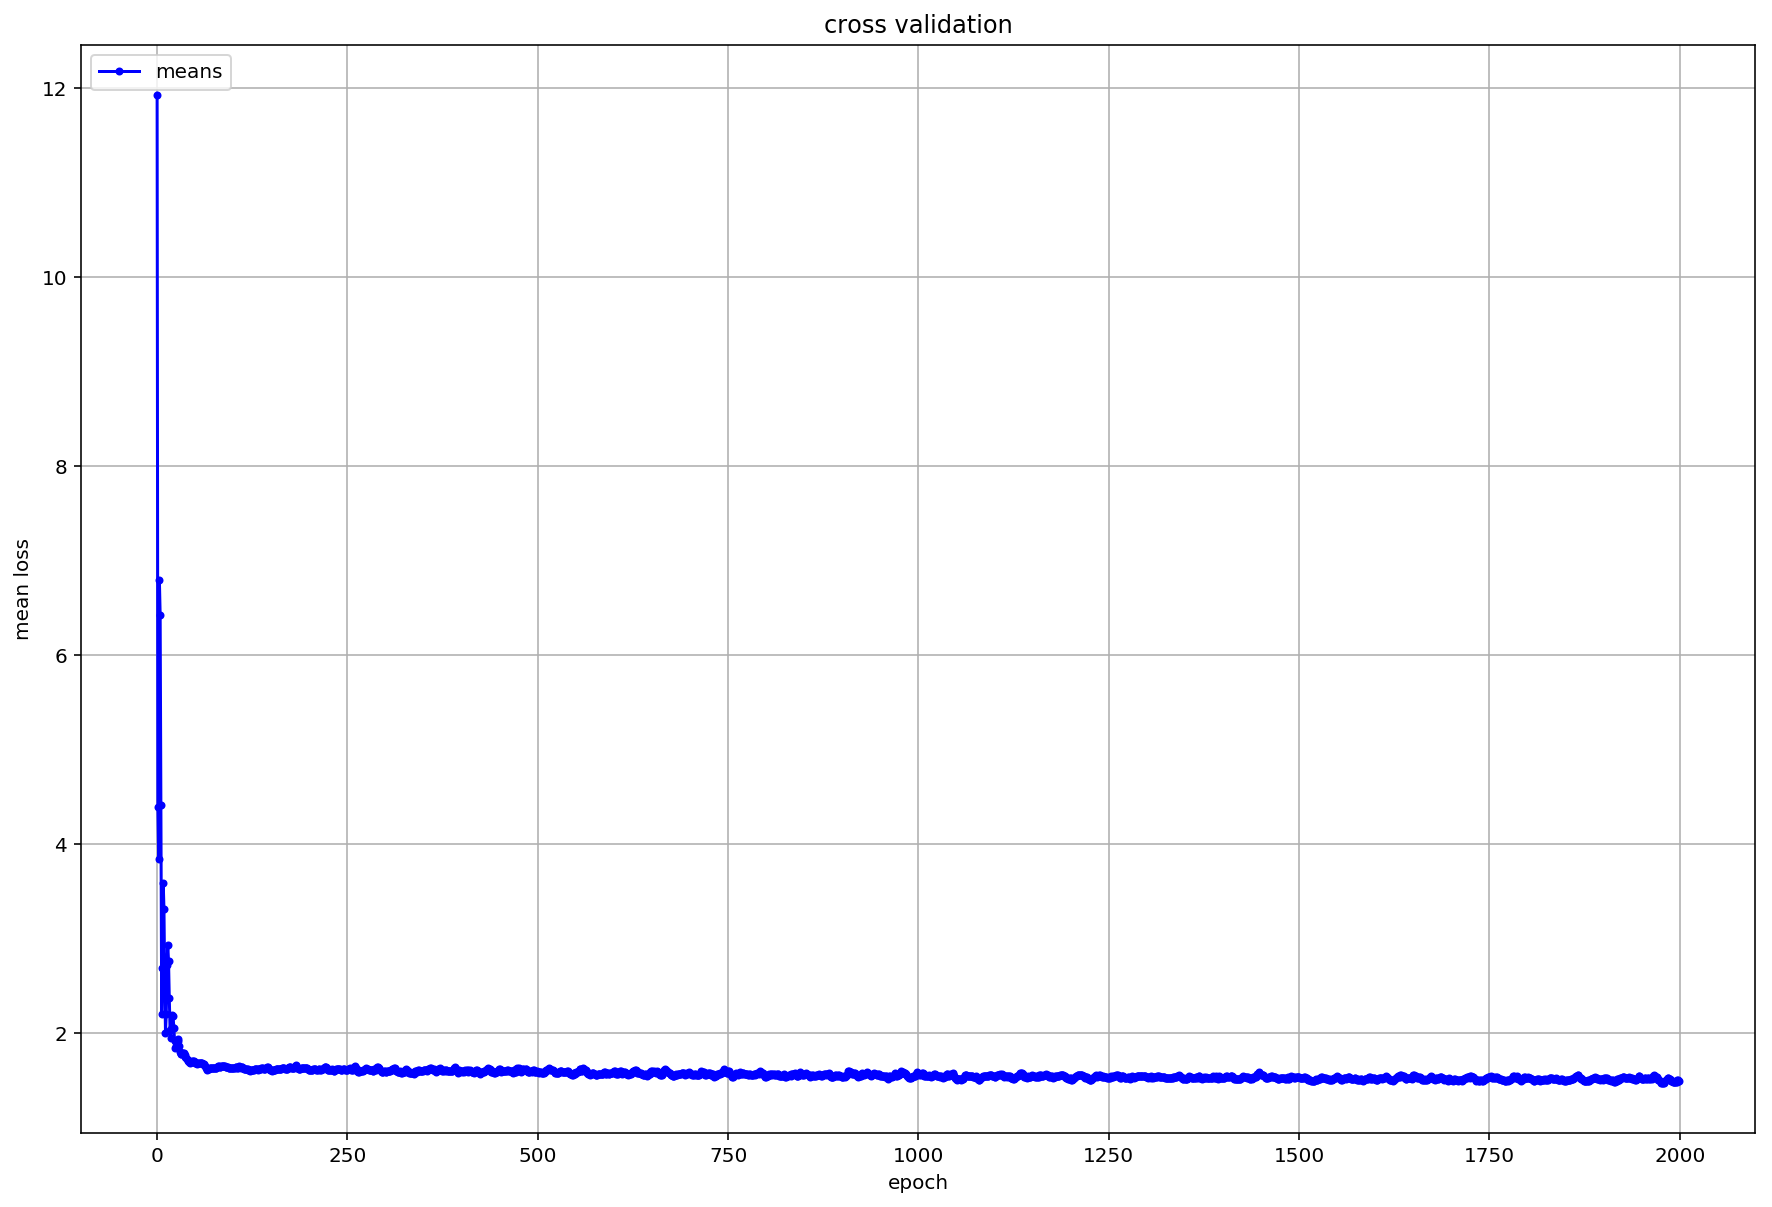

In [19]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0), save=True)

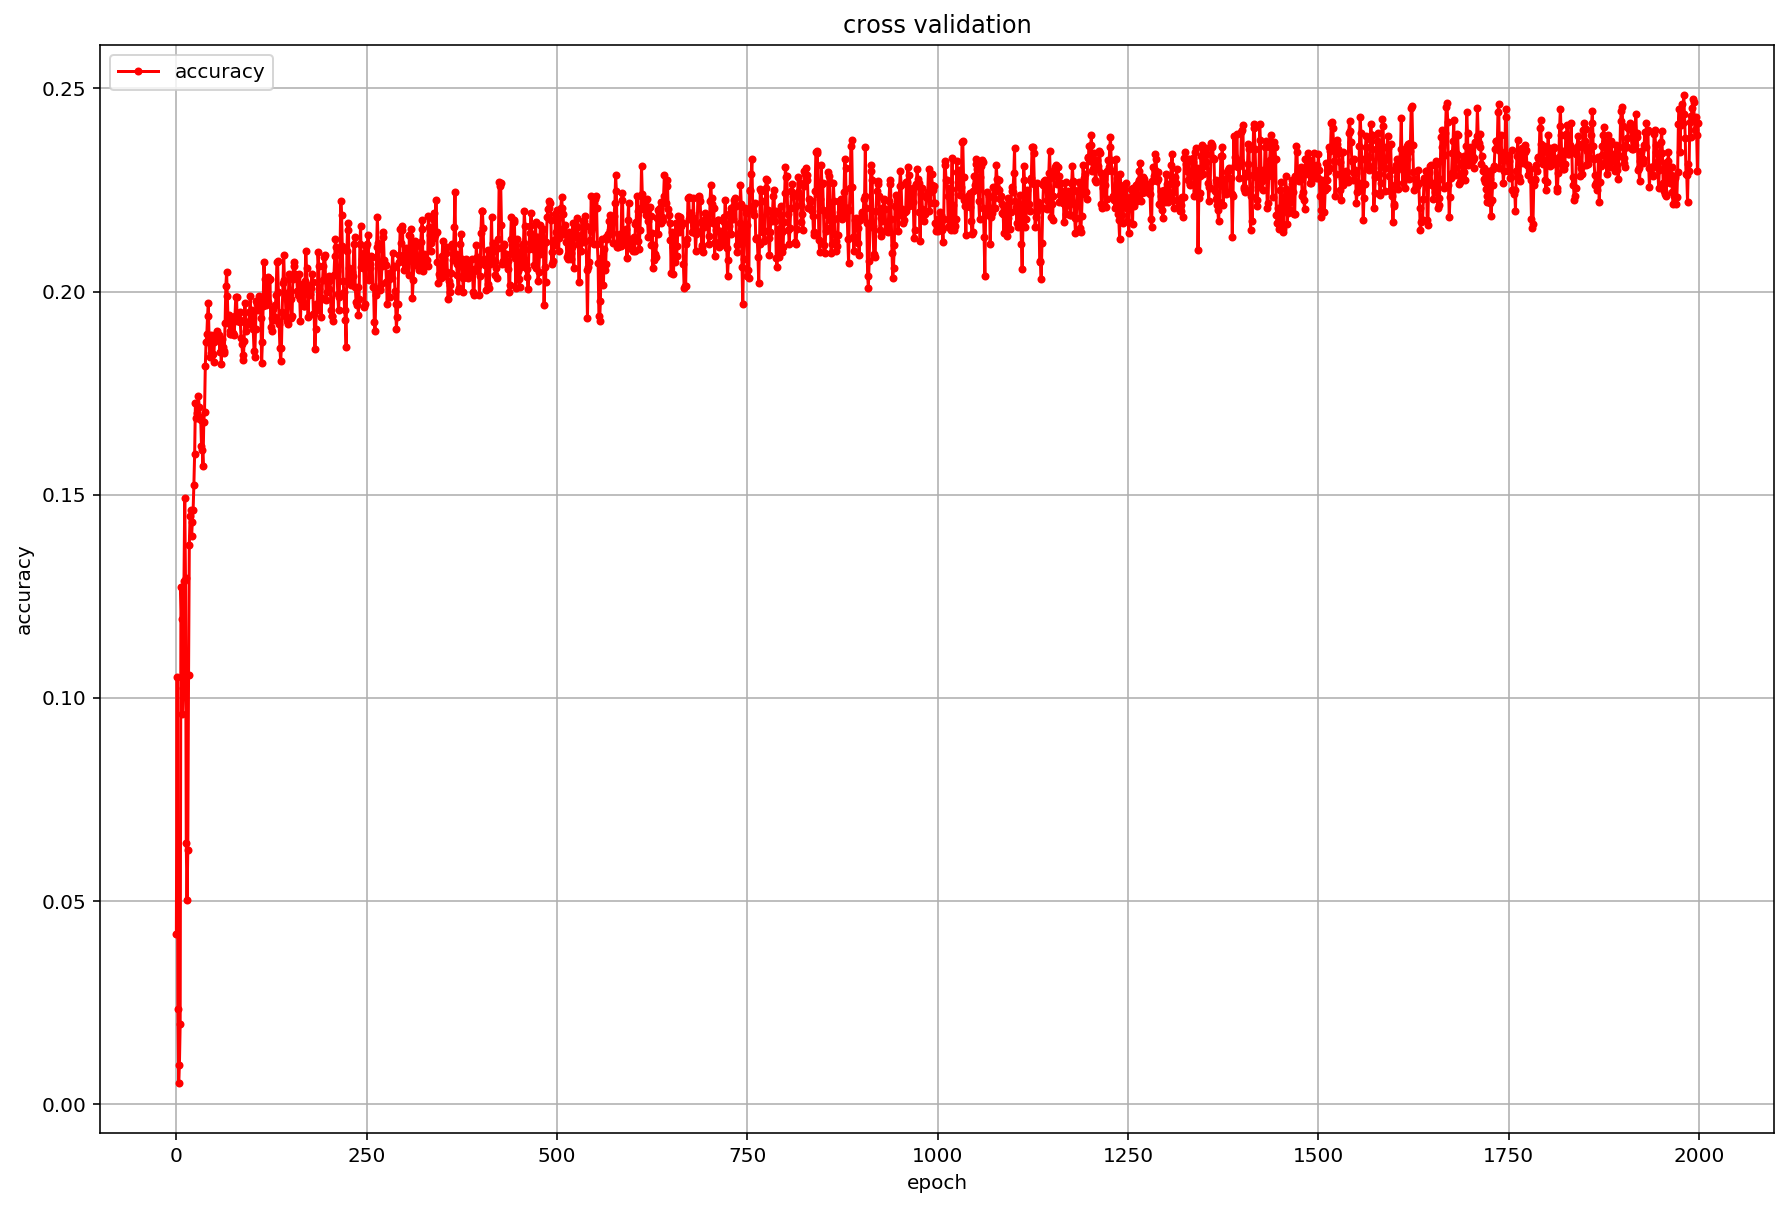

In [18]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), save=True)

## Elimination de la redondance de calcul pour la correspondance des y
La correspondance avec les y est actuellement calculée à chaque epoch. Il est plus simple de calculer cela en avance et de rajouter les y à la matrix des x.
1. Prendre les coordonnées du torse
2. Faire le nearest neightbour sur ces coordonnées
3. Créer un vecteur
4. Concatenate sur la matrix des x (keypoints_cam1)

5. Adapter le NN pour isoler les y, et les utiliser dedans

In [3]:
def compute_and_append_ys(xs, attention_levels, positions_by_ids):
    y_temp = []
    
    for i in range(xs.shape[0]):
        x0, y0 = xs[i][5], xs[i][6] # +1 à cause du numéro de frame

        #create the corresponding ys
        frame_numbers = np.array(xs[:, 1])
        frame_numbers = frame_numbers.astype(int)

        current_id, _ = nearest_id(x0, y0, positions_by_ids)
        first_frame_of_id = first_occurence_of_id(current_id, attention_levels[:, 1])
        y_temp.append(attention_levels[first_frame_of_id + frame_numbers[i]][0])        

    ys = np.array([y_temp])
    ys = ys.astype(int)
    
    return np.concatenate((ys.T, xs), axis=1)

In [4]:
#data load

keypoints_cam1_file = 'keypoints_pierre03_cam1'
keypoints_cam1 = np.load(keypoints_cam1_file + '.npy').T
print('The matrix containing all the keypoints from cam1 has shape ' + str(keypoints_cam1.shape))
ids_cam1 = []

#changer les y, la dataframe

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 109) | (df1['Participant'] == 77) | (df1['Participant'] == 107) 
                      | (df1['Participant'] == 76) | (df1['Participant'] == 75) | (df1['Participant'] == 111)
                      | (df1['Participant'] == 84) | (df1['Participant'] == 94) | (df1['Participant'] == 101)
                      | (df1['Participant'] == 104) | (df1['Participant'] == 106) | (df1['Participant'] == 112)
                      | (df1['Participant'] == 78) | (df1['Participant'] == 115) | (df1['Participant'] == 79)
                      | (df1['Participant'] == 71)]

df_cam1 = df_participants[['Global Attention Rating', 'Participant']]

#adapter le dict pos_id

#création du dict (données préparées à la main sur une frame du début)
pos_ids_cam1 = {
    '109' : [11.615488 , 175.00432],
    '77' : [255.46295 , 192.63771],
    '107' : [590.8298 , 125.969315], 
    '76' : [734.08356 , 125.74278], 
    '75': [1123.1455 , 126.00644], 
    '111' : [170.54427 , 299.97433],
    '84' : [456.7496 , 237.79659],
    '94': [806.05273 , 233.13977],
    '101': [998.19214 , 228.8077],
    '104': [1230.5897 , 224.23285],
    '106': [1338.0624 , 192.56294],
    '112' : [1512.5647 , 210.68916],
    '78' : [11.560406 , 443.2507],
    '115' : [412.18192 , 402.96262],
    '79': [1006.9935 , 340.79202],
    '71': [1315.766 , 322.5751],
}

lambda_ = 1e-4
epochs = 10000
loss = torch.nn.MSELoss()
batch_size = 256

plt.rcParams["figure.figsize"] = [15, 10]

matrix_cam1 = compute_and_append_ys(keypoints_cam1, df_cam1.values, pos_ids_cam1)

print('appended ys')

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = matrix_cam1_norm.shape[1] - 2, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

print('Neural network created')


The matrix containing all the keypoints from cam1 has shape (4402, 76)
Successfully imported the excel file
appended ys


NameError: name 'normalize' is not defined

In [ ]:
def train_NNmodel_batch_precomputed(model, matrix, learning_rate, loss_fn, number_of_epochs, batch_size):

    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in log_progress(range(number_of_epochs), name='Epoch'):
        
        ys = matrix[:, 0] #prend les niveaux d'attention 
        xs = matrix[:, 1:]
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(xs.shape[0], batch_size, replace=False)
        #get the rows that correspond to these 
        x_with_frames = xs[indexes_batch]

        #create a matrix that is (batch_size * D_in) dimensions
        x_temp = x_with_frames[:, 1:]

        #give directly the matrix as input to the model
        x = torch.tensor(x_temp, dtype = torch.float, device=device)         
        
        y_temp = ys[indexes_batch]
        y = torch.tensor([y_temp], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        #print('Epoch: ', epoch, ' Column: ', i, ' Loss: ', loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [50]:
train_NNmodel_batch_precomputed(m, matrix_cam1, learning_rate=lambda_, loss_fn=loss, number_of_epochs=epochs, batch_size=batch_size)

In [233]:
#validation for batch version of NN, with precomputed ys

def compute_accuracy_vector(y_pred, y, threshold):
    #print(y)
    #print(y_pred)
    #print(np.count_nonzero((y_pred - y) < threshold))
    return np.count_nonzero(np.logical_and((y - y_pred) < threshold, (y_pred - y) < threshold))
        

def get_accuracy(model, matrix, batch_size, accuracy_threshold):
    
    indexes_batch = np.random.choice(matrix.shape[0], batch_size, replace=False)
    #get the rows that correspond to these 
    matrix_selected = matrix[indexes_batch]
    
    ys = matrix_selected[:, 0]
    xs = matrix_selected[:, 2:]
    
    y_preds = np.empty([0, 1])
    accuracies = []
    losses = []
    
    loss_function = torch.nn.L1Loss()
    
    with torch.no_grad():

        #transforme en data compréhensible par le NN et élimine le numéro de frame
        x = torch.tensor(xs, dtype = torch.float)
        y = torch.tensor([ys], dtype=torch.float)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        loss = loss_function(y_pred, y)
        accuracy = compute_accuracy_vector(y_pred.cpu().numpy(), y.cpu().numpy(), accuracy_threshold)

        y_preds = np.vstack((y_preds, np.round(y_pred, 3)))
        accuracies.append(np.round(accuracy, 3))
        losses.append(np.round(loss.item(), 3))
    
    
    
    mean_loss = np.mean(losses)
    mean_accuracy = np.mean(accuracies)
    
    data = np.array([ys, y_preds, losses, accuracies])
    #headers = ['Expected y', 'Predicted y', 'Loss', 'Accuracy']
    return data, mean_loss, mean_accuracy



def train_NNmodel_validation_batch(model, matrix_train, matrix_validation, learning_rate, loss_fn, number_of_epochs, batch_size, accuracy_threshold):
    
    results, losses, accuracies = [], [], []
   
    
    #to run on GPU
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in tqdm_notebook(range(number_of_epochs), desc='Epoch', leave=False):
        
        #get number of random indexes equal to batch_size
        indexes_batch = np.random.choice(matrix_train.shape[0], batch_size, replace=False)
        #get the rows that correspond to these 
        matrix_selected = matrix_train[indexes_batch]
        
        ys = matrix_selected[:, 0] #prend les niveaux d'attention (les y)
        xs = matrix_selected[:, 2:] #create a matrix that is (batch_size * D_in) dimensions / ignores the frame numbers

        #give directly the matrix as input to the model
        x = torch.tensor(xs, dtype = torch.float, device=device)         
        
        y = torch.tensor([ys], dtype=torch.float, device = device)
        y = y.transpose_(0, 1)
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        results_temp, loss_temp, acc_temp = get_accuracy(model, matrix_validation, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
            
    return results, losses, accuracies


def validation_batch(model, x, k_indices, k, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold):
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    
    m_train = x[tr_indice]
    m_test = x[te_indice]
    
    return train_NNmodel_validation_batch(model, m_train, m_test, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)


def run_validation_batch(model, x, learning_rate, loss_fn, epochs, batch_size=64, accuracy_threshold=0.5, k_fold=5, seed=1):
    k_indices = build_k_indices(x, k_fold, seed)
    results, losses, accuracies = [], [], []
    for k in tqdm_notebook(range(k_fold), desc='Kth-fold'):
        m2 = copy.deepcopy(model)
        results_temp, loss_temp, acc_temp = validation_batch(m2, x, k_indices, k, learning_rate, loss_fn, epochs, batch_size, accuracy_threshold)
        results.append(results_temp)
        losses.append(loss_temp)
        accuracies.append(acc_temp)
        
    return pd.DataFrame(results), pd.DataFrame(losses), pd.DataFrame(accuracies)

In [12]:
a, b, c = run_validation_batch(m, matrix_cam1, lambda_, loss, epochs, batch_size=batch_size, accuracy_threshold=0.5, k_fold=10)

KeyboardInterrupt: 

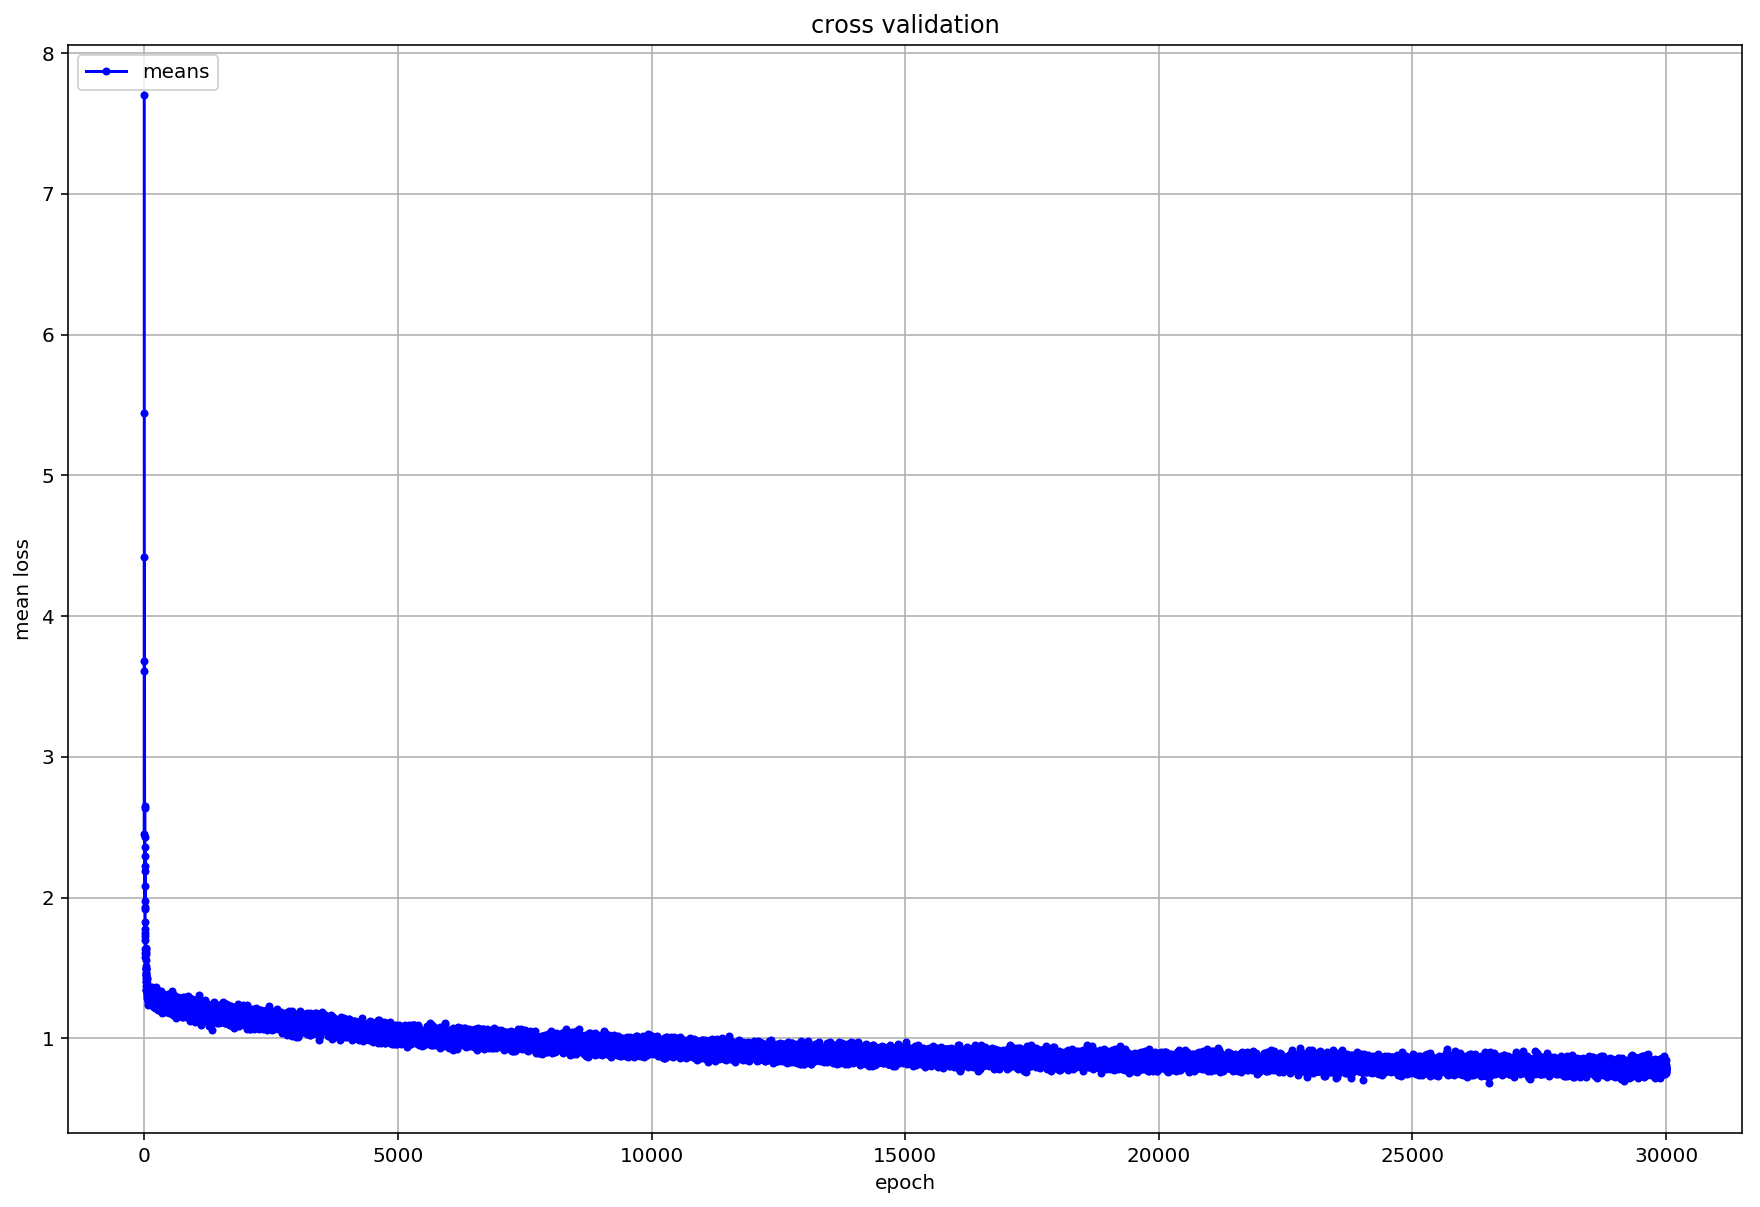

In [30]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0), save=True)

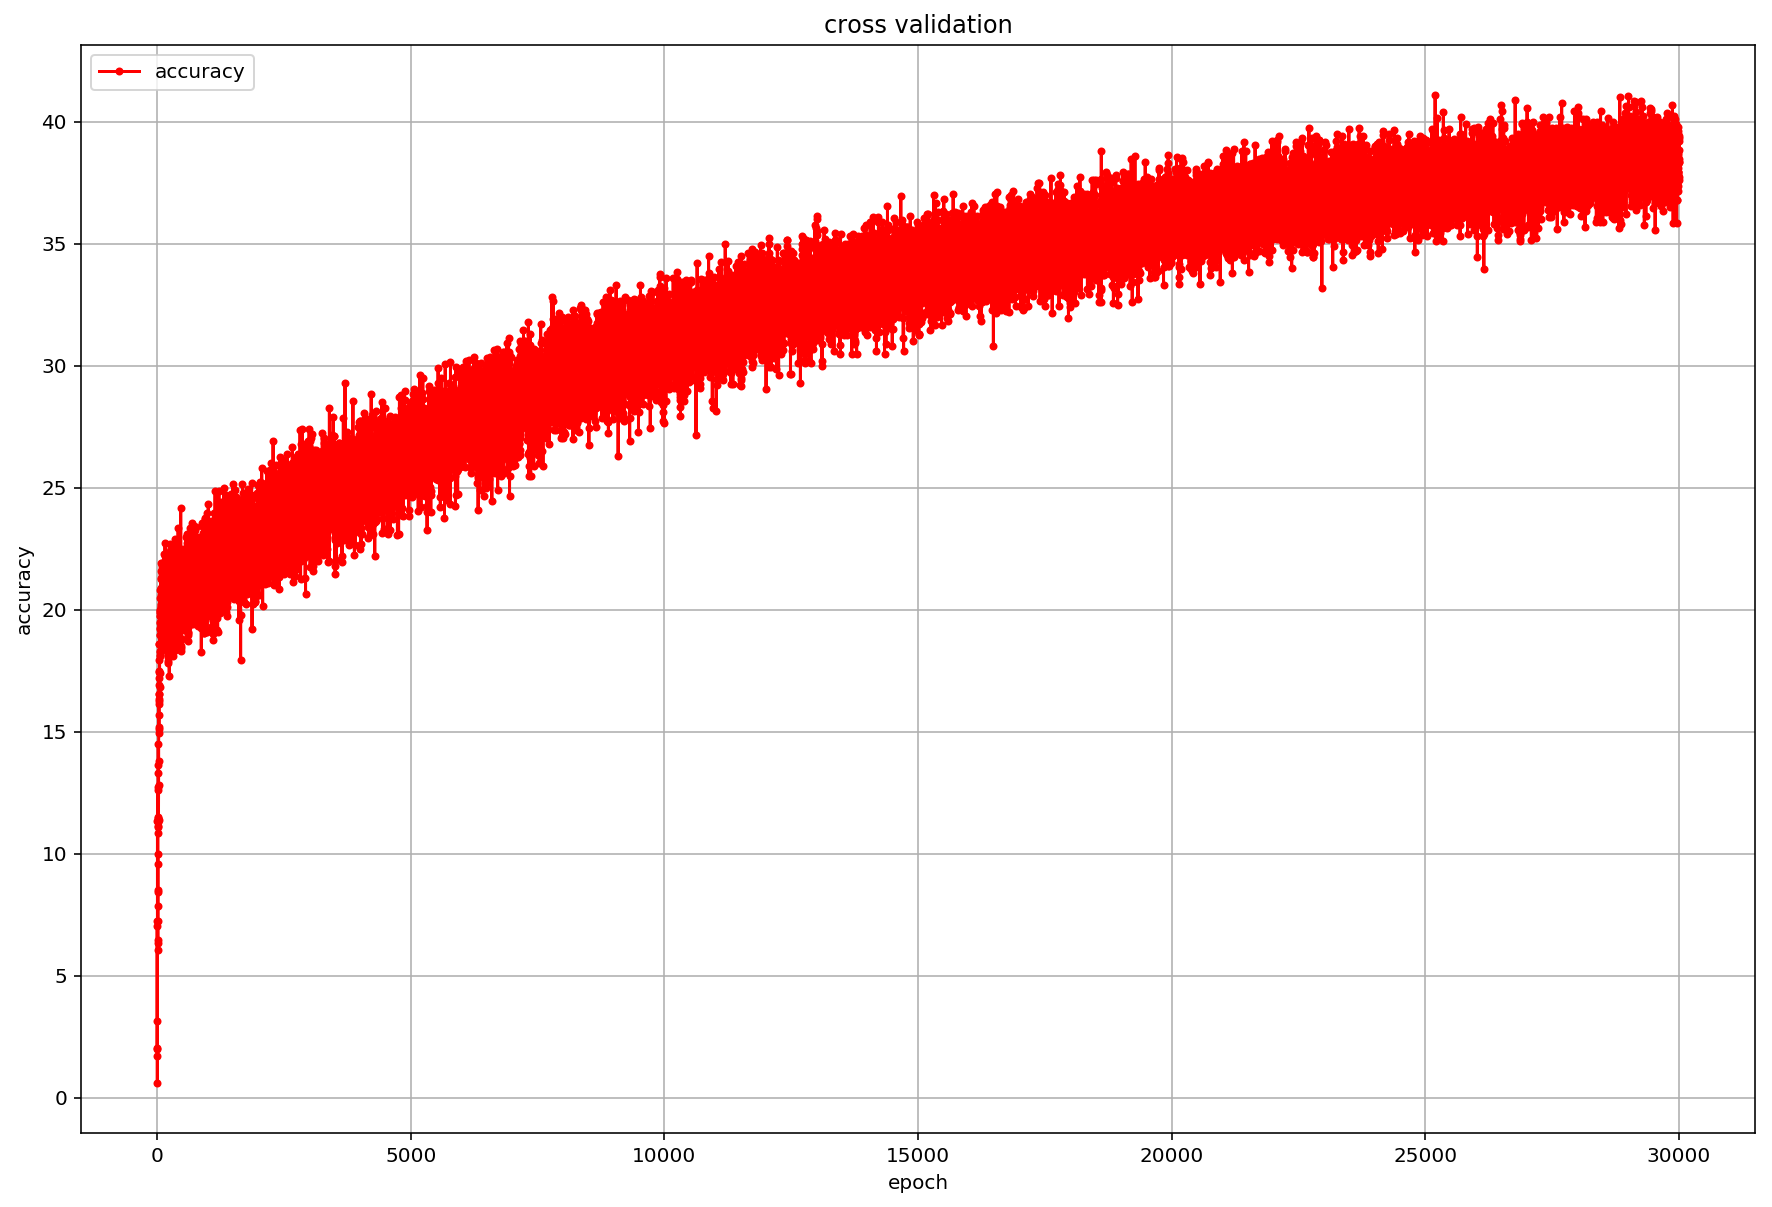

In [31]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), True)

# Normalisation de la data
1. virer la confidence (3ème dimension)
2. Resize les keypoints
    1. définir la taille du nage de coordonnées ($x_{max} - x_{min}, y_{max} - y_{min}$)
    2. trouver le coefficient à multiplier pour que les deux tailles soient 1
    3. Multiplier les dimensions des points par le coefficient qui correspond à leur dimension
    4. Ne fonctionne pas car on n'a pas tout le temps les mêmes points dans tous les sets de keypoints ? (se concentrer uniquement sur certains keypoints/prendre uniquement ceux de la tête pour calculer la taille, et multiplier tous les points par le coefficient, ceux qui sont à 0 le resteront, les autres seront resize ??)
3. Centrer les keypoints
    1. Calculer le centre des keypoints (ignorer ceux qui sont mis à 0) => prendre la moyenne des points sur chaque coordonnée
    2. Caculer le vecteur de déplacement centre -> (0 0)
    3. Déplacer chacun des points de ce vecteur


4. Mettre sous forme de fonction dans un fichier helper à côté, afin de pouvoir utiliser ça sur la data pour la préparer à l'avance, et sur les inputs donnés au NN (besoin actuellement ?)

In [3]:
def find_size_cloud_np(matrix):
    temp = np.copy(matrix)
    keypoints_x = temp[::2]
    keypoints_y = temp[1::2]
    
    x_min = np.min(keypoints_x[np.nonzero(keypoints_x)]) 
    x_max = np.max(keypoints_x[np.nonzero(keypoints_x)])
    y_min = np.min(keypoints_y[np.nonzero(keypoints_y)])
    y_max = np.max(keypoints_y[np.nonzero(keypoints_y)])
    
    return x_min, x_max, y_min, y_max

def find_size_cloud(keypoints):
    temp = np.copy(keypoints)
    x_min, x_max, y_min, y_max = 100000, -1, 100000, -1
    
    for i in range(temp.shape[0]):
        t = temp[i]
        
        if (t != 0): #ignorer coordonnées égales à 0
            if (i % 2 == 0): #indice pair, donc coordonnée x
                if (t > x_max):
                    x_max = t
                elif (t < x_min):
                    x_min = t

            else: #indice impair, donc coordonnée y
                if (t > y_max):
                    y_max = t
                elif (t < y_min):
                    y_min = t
                    
    return x_min, x_max, y_min, y_max

def center_keypoints(keypoints):
    result = np.copy(keypoints)
    x_min, x_max, y_min, y_max = find_size_cloud(result)
    
    x_mean = (x_max - x_min)/2 + x_min
    y_mean = (y_max - y_min)/2 + y_min
    
    keypoints_x = result[::2]
    keypoints_y = result[1::2]
    
    for i in range(result.shape[0]):
        t = result[i]
        if (t != 0): #ignorer coordonnées égales à 0
            if (i % 2 == 0): #indice pair, donc coordonnée x
                result[i] = t - x_mean

            else: #indice impair, donc coordonnée y
                result[i] = t - y_mean
    return result
    
    
def resize_keypoints(matrix):
    result = np.copy(matrix)
    x_min, x_max, y_min, y_max = find_size_cloud(result)
    
    factor = 1 / np.max([x_max - x_min, y_max - y_min])
    
    result = np.multiply(result, factor)
    
    return result

def delete_confidence(matrix):
    result = np.copy(matrix)
    if (matrix.shape[0] == 75):
        return np.delete(result, np.arange(2, result.size, 3))
    else:
        raise TypeError('The matrix had shape ' + str(matrix.shape) + ' which was not expected. ')

def delete_legs(matrix):
    temp = np.copy(matrix)
    
    #places des coordonnées des jambes
    ids_legs = [9, 8, 12, 10, 13, 11, 24, 21, 14, 23, 22, 19, 20]
    
    for i in ids_legs:
        temp[i*2] = 0
        temp[i*2+1] = 0
        
    return temp


def normalize(matrix):
    temp = np.copy(matrix)
    result = []
    for i in range(temp.shape[0]):
        row = temp[i, 2:]
        row_norm = center_keypoints(resize_keypoints(delete_legs(delete_confidence(row))))
        
        result.append(np.append(temp[i, :2], row_norm))
    
    return np.array(result)

In [4]:
#data load

keypoints_cam1_file = 'keypoints_pierre03_cam1'
keypoints_cam1 = np.load(keypoints_cam1_file + '.npy').T
print('The matrix containing all the keypoints from cam1 has shape ' + str(keypoints_cam1.shape))
ids_cam1 = []

#changer les y, la dataframe

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 109) | (df1['Participant'] == 77) | (df1['Participant'] == 107) 
                      | (df1['Participant'] == 76) | (df1['Participant'] == 75) | (df1['Participant'] == 111)
                      | (df1['Participant'] == 84) | (df1['Participant'] == 94) | (df1['Participant'] == 101)
                      | (df1['Participant'] == 104) | (df1['Participant'] == 106) | (df1['Participant'] == 112)
                      | (df1['Participant'] == 78) | (df1['Participant'] == 115) | (df1['Participant'] == 79)
                      | (df1['Participant'] == 71)]

df_cam1 = df_participants[['Global Attention Rating', 'Participant']]

#adapter le dict pos_id

#création du dict (données préparées à la main sur une frame du début)
pos_ids_cam1 = {
    '109' : [11.615488 , 175.00432],
    '77' : [255.46295 , 192.63771],
    '107' : [590.8298 , 125.969315], 
    '76' : [734.08356 , 125.74278], 
    '75': [1123.1455 , 126.00644], 
    '111' : [170.54427 , 299.97433],
    '84' : [456.7496 , 237.79659],
    '94': [806.05273 , 233.13977],
    '101': [998.19214 , 228.8077],
    '104': [1230.5897 , 224.23285],
    '106': [1338.0624 , 192.56294],
    '112' : [1512.5647 , 210.68916],
    '78' : [11.560406 , 443.2507],
    '115' : [412.18192 , 402.96262],
    '79': [1006.9935 , 340.79202],
    '71': [1315.766 , 322.5751],
}

lambda_ = 1e-3
epochs = 50000
loss = torch.nn.MSELoss()
batch_size = 128

plt.rcParams["figure.figsize"] = [15, 10]

matrix_cam1 = compute_and_append_ys(keypoints_cam1, df_cam1.values, pos_ids_cam1)

print('appended ys')

matrix_cam1_norm = normalize(matrix_cam1)

print('normalized data')

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = matrix_cam1_norm.shape[1] - 2, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

print('Neural network created')


The matrix containing all the keypoints from cam1 has shape (4402, 76)
Successfully imported the excel file
appended ys
normalized data
Neural network created


In [242]:
a, b, c = run_validation_batch(m, matrix_cam1_norm, lambda_, loss, epochs, batch_size=batch_size, accuracy_threshold=0.5, k_fold=5)

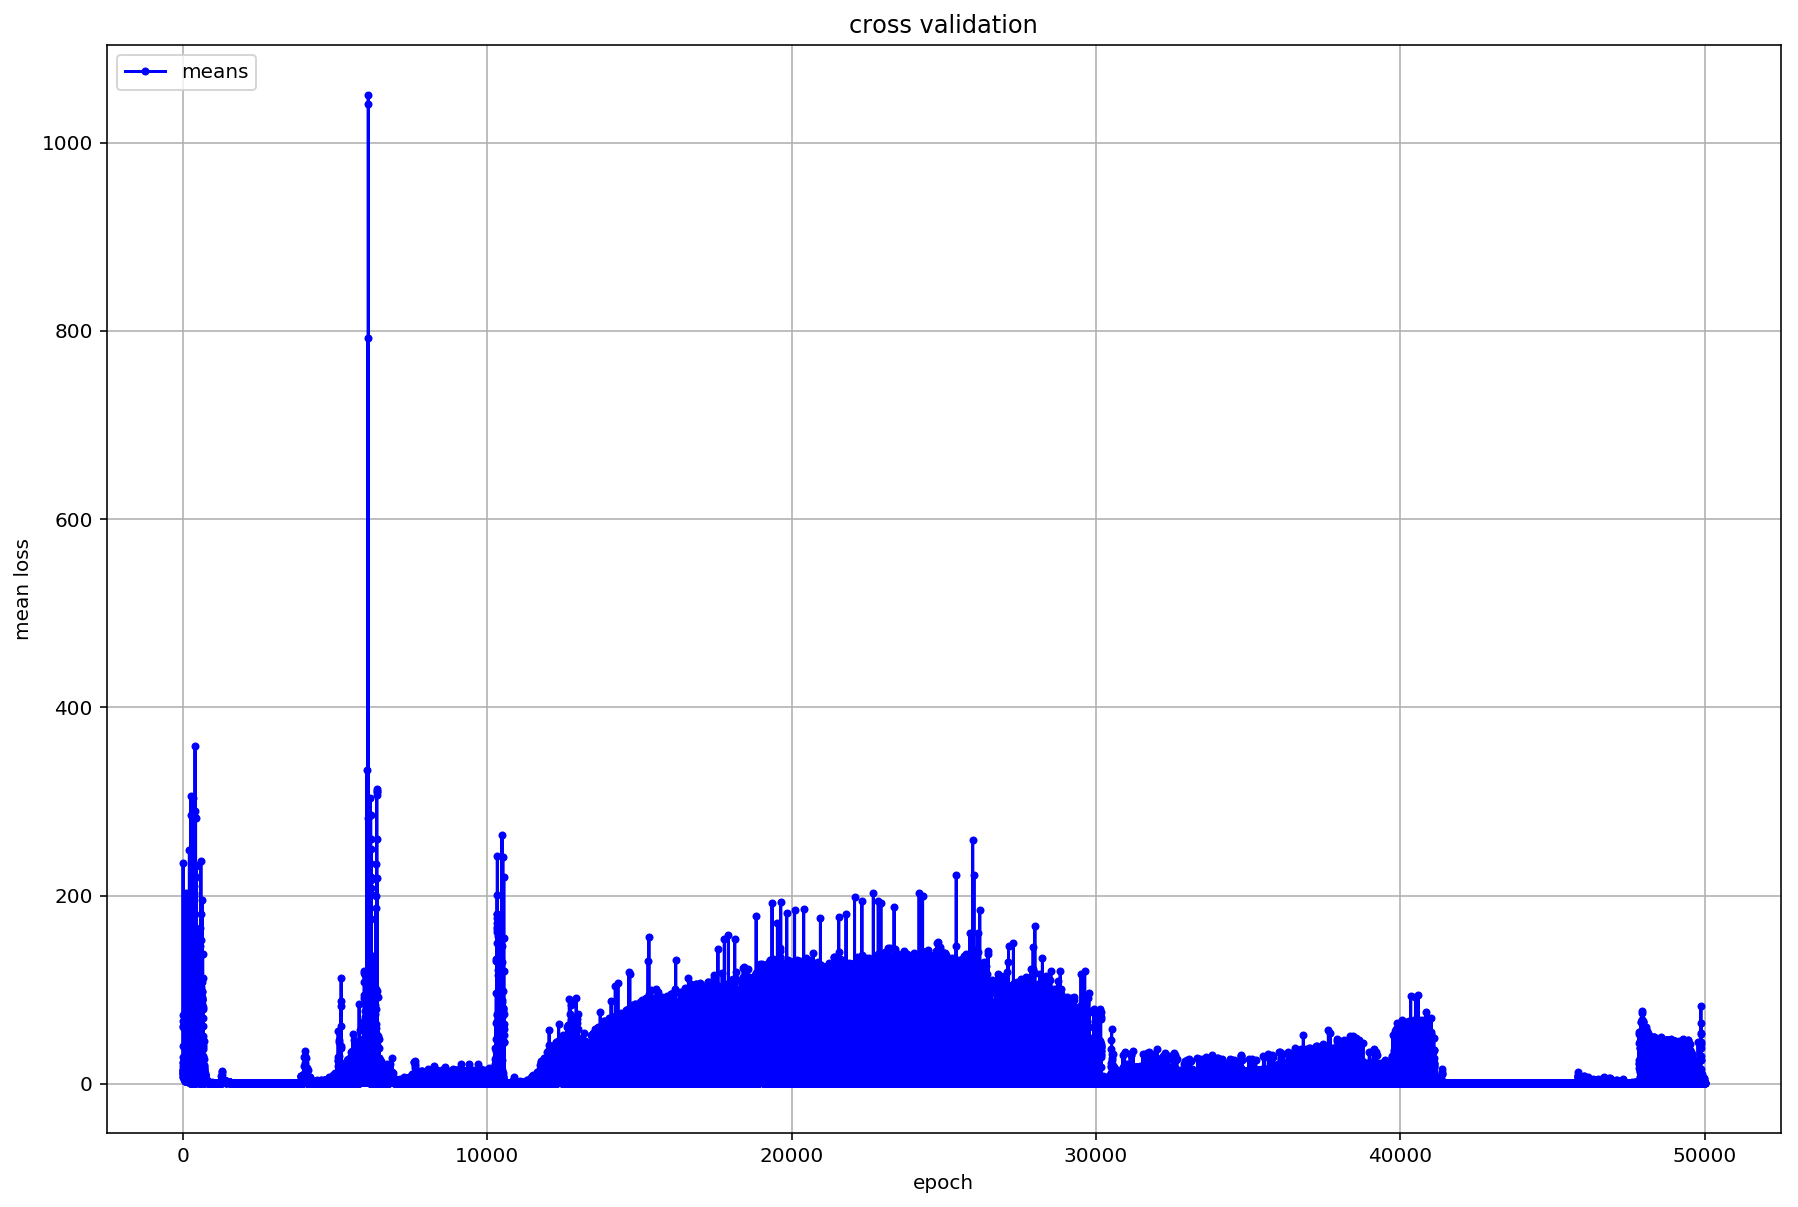

In [243]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

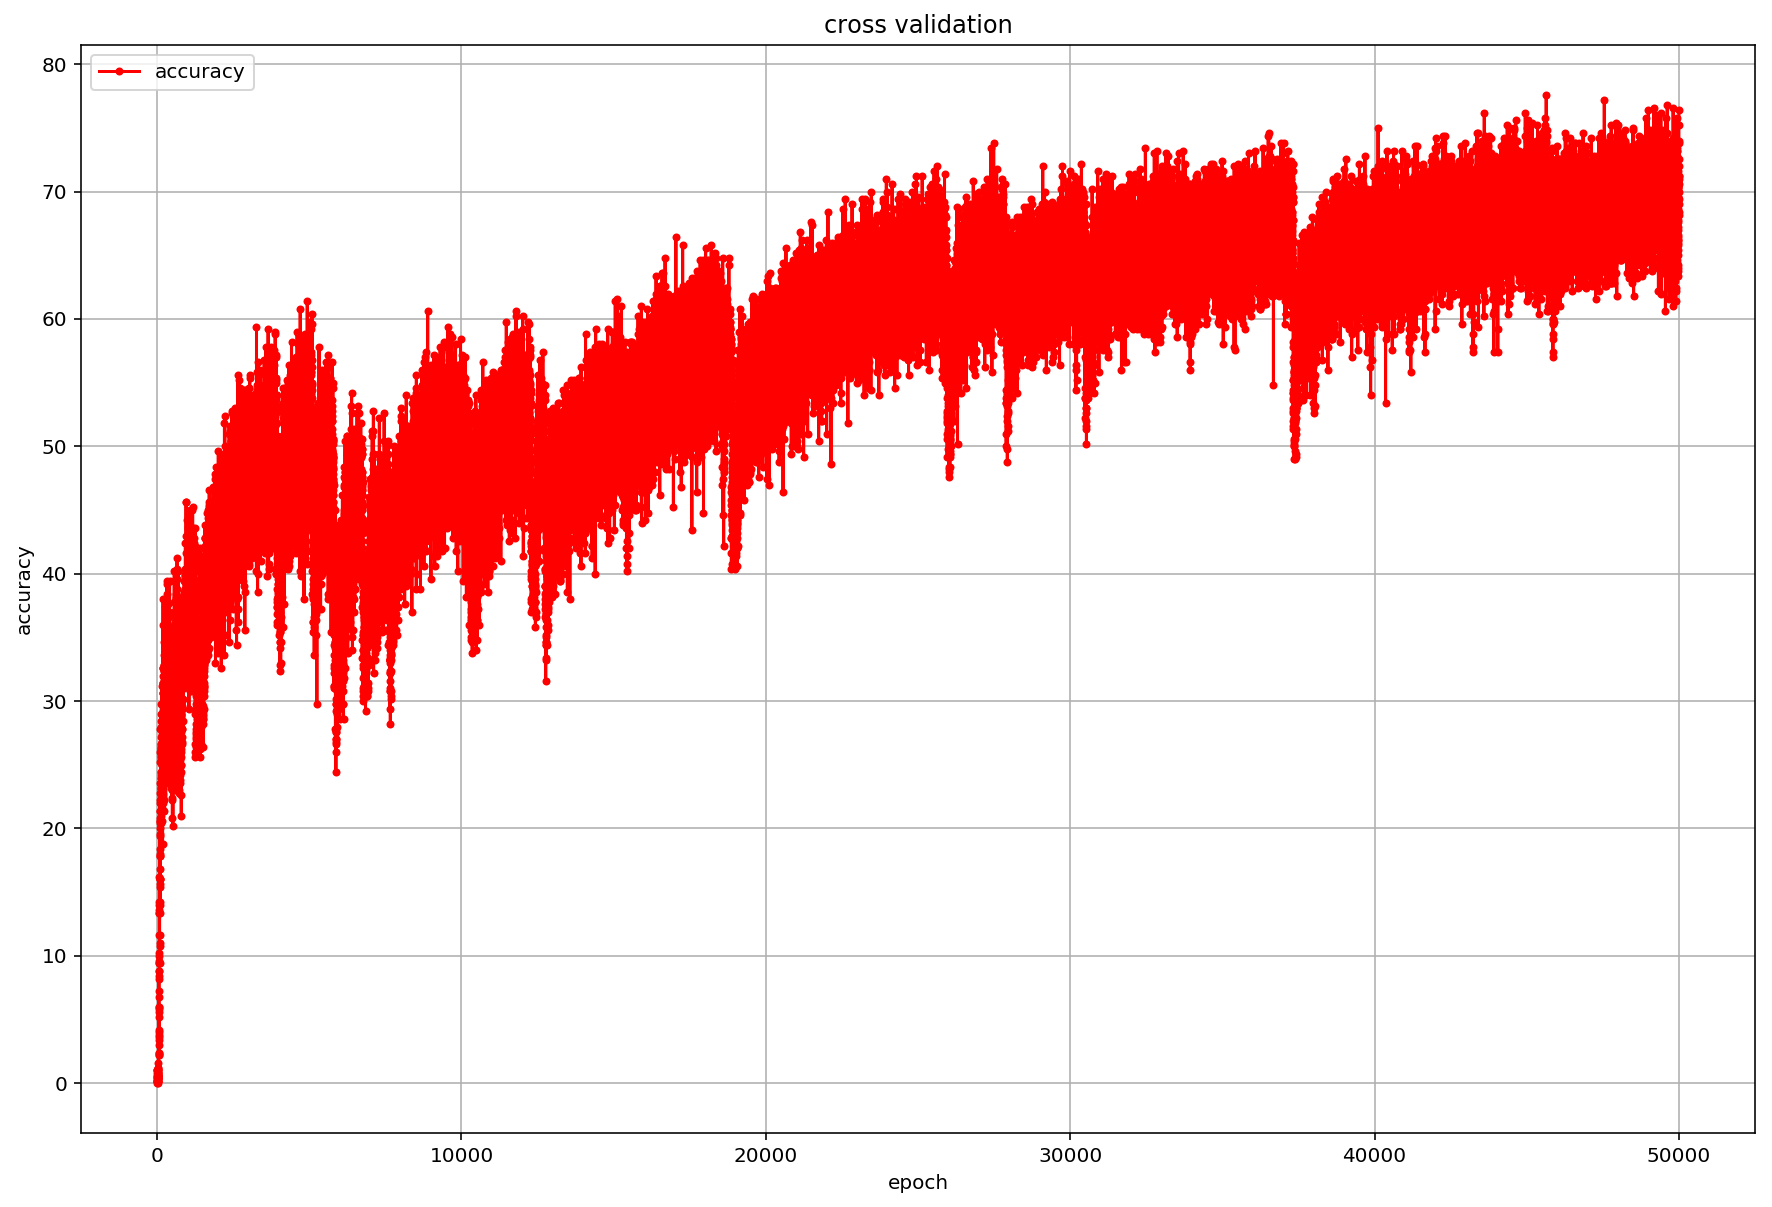

In [245]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), save=True, filename='norm_50000')

# Changement du validation set et du test set
1. Choisir quels ids laisser de côté
2. Itérer sur la matrice contenant toute le données pour enlever les lignes correspondants aux ids susmentionnés
3. Stocker les lignes dans une autre matrice
4. Prendre la nouvelle matrice comme validation set

In [2]:
#DATA LOAD

## PARAMETERS

keypoints_cam1_file = 'keypoints_pierre03_cam1'
keypoints_cam1 = np.load(keypoints_cam1_file + '.npy').T
print('The matrix containing all the keypoints from cam1 has shape ' + str(keypoints_cam1.shape))

#ids des participants à garder pour le validation set: 
ids_validation = [106, 112]

#adapter le dict pos_id

#création du dict (données préparées à la main sur une frame du début)
pos_ids_cam1 = {
    '109' : [11.615488 , 175.00432],
    '77' : [255.46295 , 192.63771],
    '107' : [590.8298 , 125.969315], 
    '76' : [734.08356 , 125.74278], 
    '75': [1123.1455 , 126.00644], 
    '111' : [170.54427 , 299.97433],
    '84' : [456.7496 , 237.79659],
    '94': [806.05273 , 233.13977],
    '101': [998.19214 , 228.8077],
    '104': [1230.5897 , 224.23285],
    '106': [1338.0624 , 192.56294],
    '112' : [1512.5647 , 210.68916],
    '78' : [11.560406 , 443.2507],
    '115' : [412.18192 , 402.96262],
    '79': [1006.9935 , 340.79202],
    '71': [1315.766 , 322.5751],
}

lambda_ = 1e-7
epochs = 200000
loss = torch.nn.MSELoss()
batch_size = 256

file = 'C:/Users/Marku/Documents_no_sync/Projet_Bachelor/data/C2_alle.xlsx'

# Load spreadsheet
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
df1 = xl.parse('C2_alle')

print('Successfully imported the excel file')

df_participants = df1[(df1['Participant'] == 109) | (df1['Participant'] == 77) | (df1['Participant'] == 107) 
                      | (df1['Participant'] == 76) | (df1['Participant'] == 75) | (df1['Participant'] == 111)
                      | (df1['Participant'] == 84) | (df1['Participant'] == 94) | (df1['Participant'] == 101)
                      | (df1['Participant'] == 104) | (df1['Participant'] == 106) | (df1['Participant'] == 112)
                      | (df1['Participant'] == 78) | (df1['Participant'] == 115) | (df1['Participant'] == 79)
                      | (df1['Participant'] == 71)]
 

############################################### END OF PARAMETERS

df_cam1 = df_participants[['Global Attention Rating', 'Participant']]


plt.rcParams["figure.figsize"] = [15, 10]

matrix_cam1 = put_id_and_compute_and_append_ys(keypoints_cam1, df_cam1.values, pos_ids_cam1)

print('appended ids and ys')

matrix_cam1_norm = normalize(matrix_cam1)

print('normalized data')

training_cam1_norm, validation_cam1_norm = enlever_ids_validation(matrix_cam1_norm, ids_validation)

print('separated training and validation data')

# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out = matrix_cam1_norm.shape[1] - 3, 1000, 1 
#la première ligne qui contient le numéro de frame ne nous intéresse pas dans le NN

#Define the model sequentially
m = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(), 
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

print('Neural network created')


The matrix containing all the keypoints from cam1 has shape (4402, 76)
Successfully imported the excel file
appended ids and ys
normalized data
separated training and validation data
Neural network created


In [3]:
a, b, c = run_new_validation_batch(m, training_cam1_norm, validation_cam1_norm, lambda_, loss, epochs, batch_size=batch_size, accuracy_threshold=0.5, k_fold=1)

nice accuracy, no loss associated

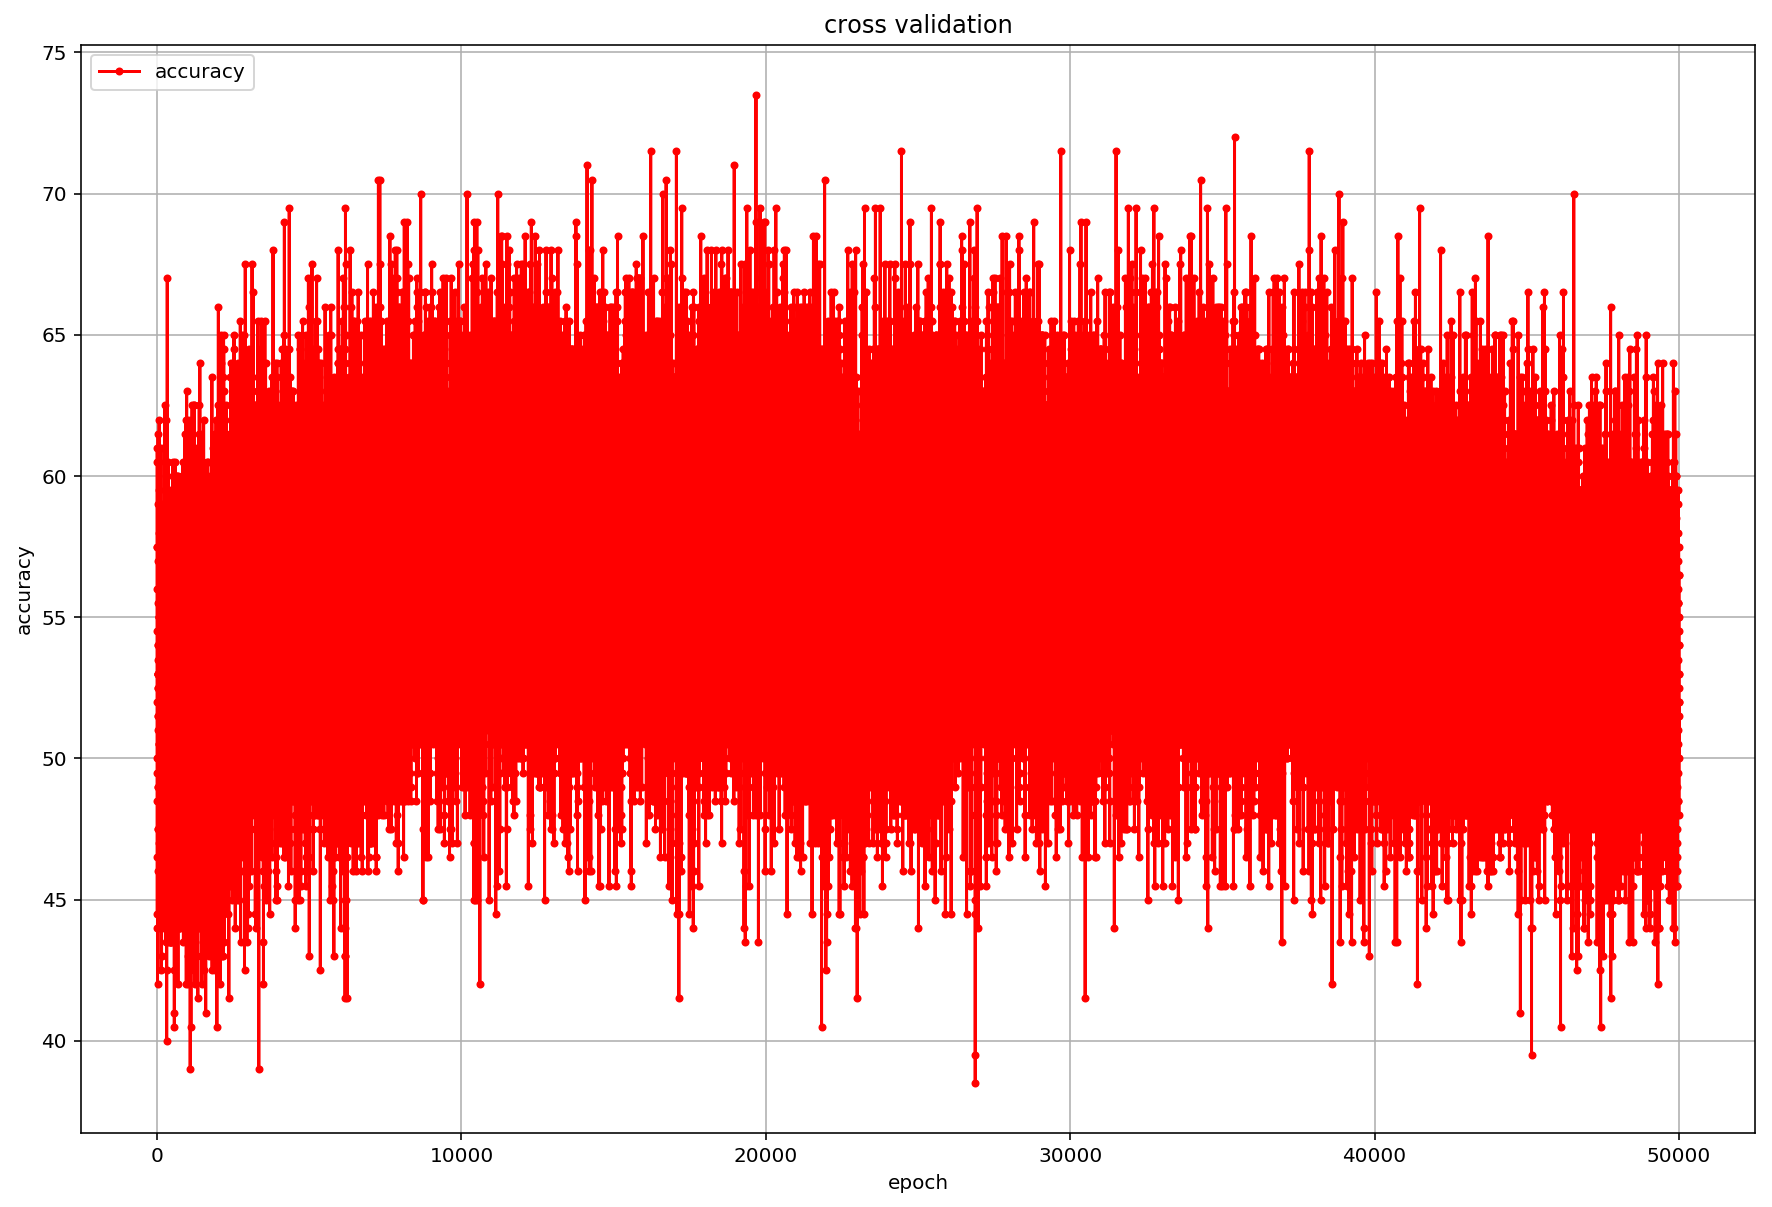

In [298]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

nice loss form, will try to replicate

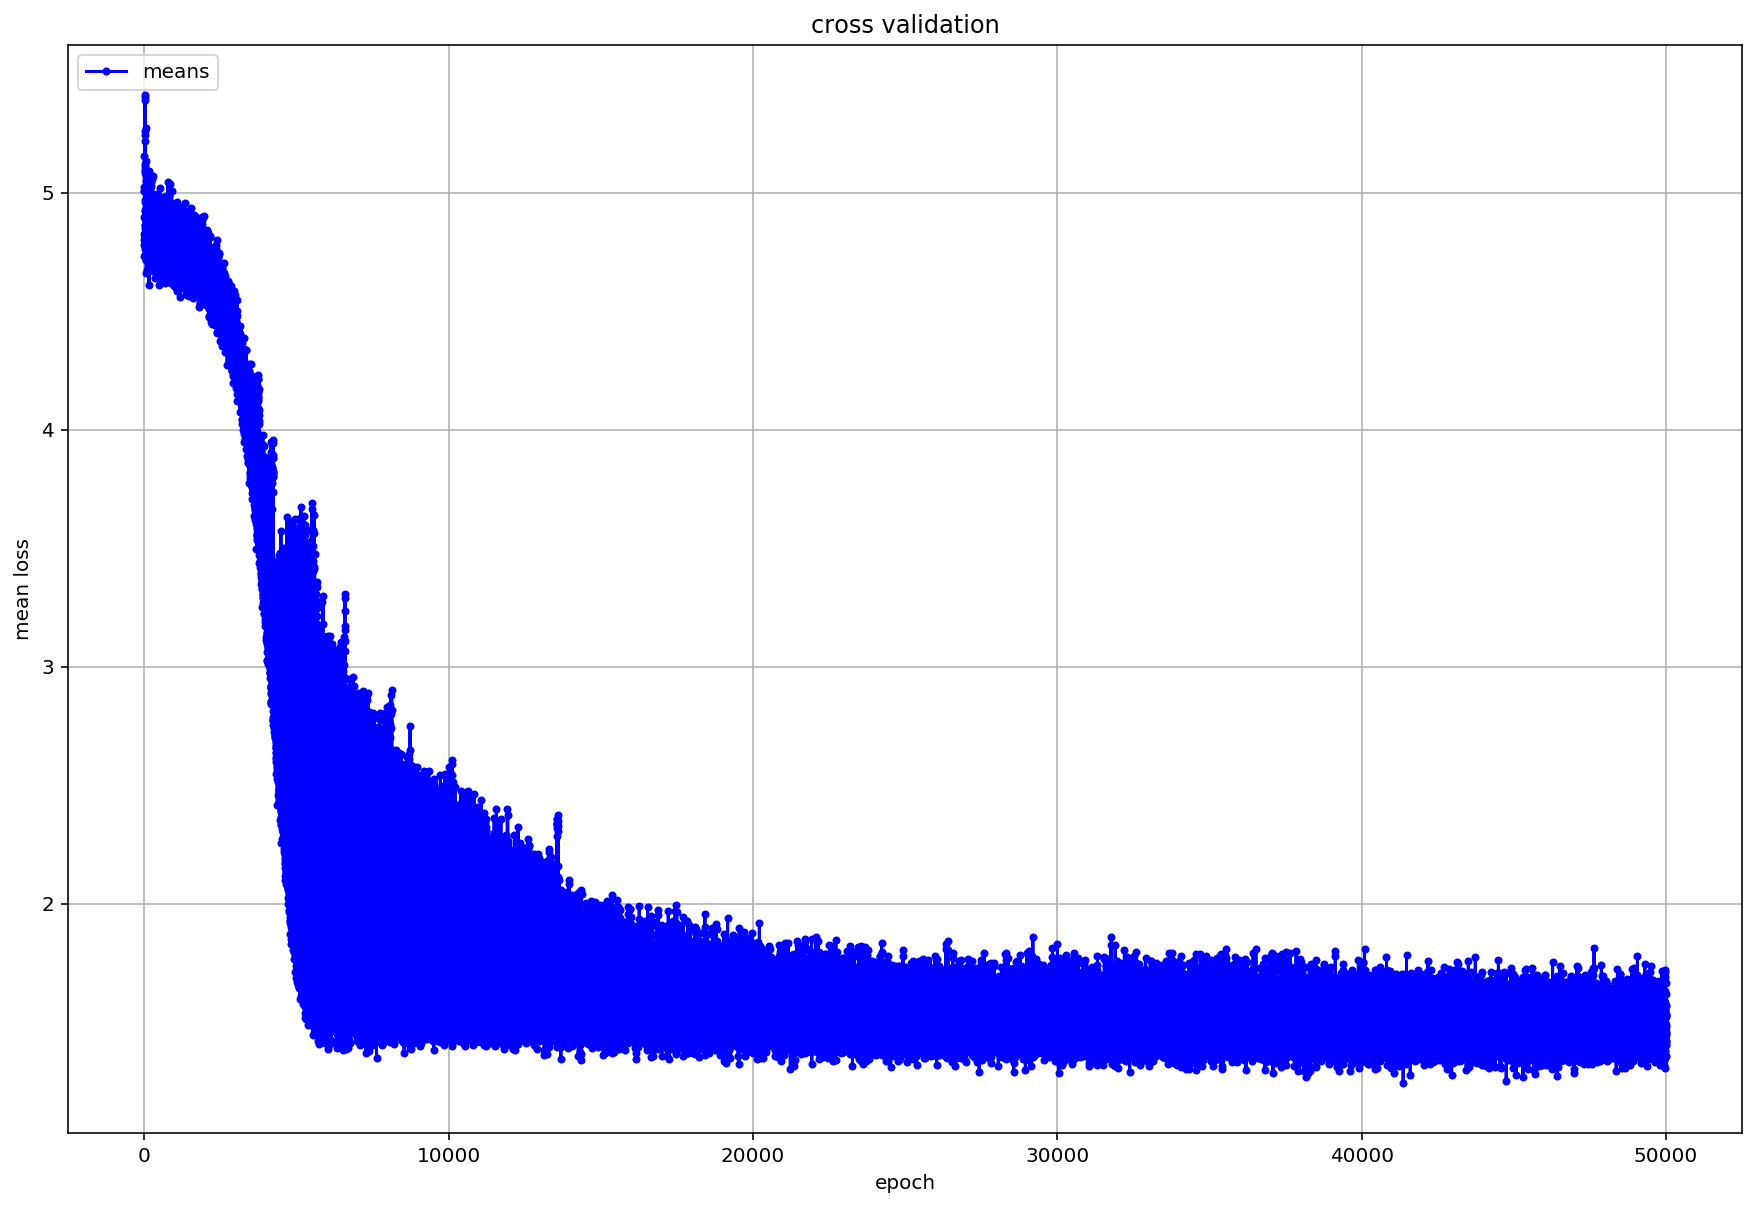

In [22]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

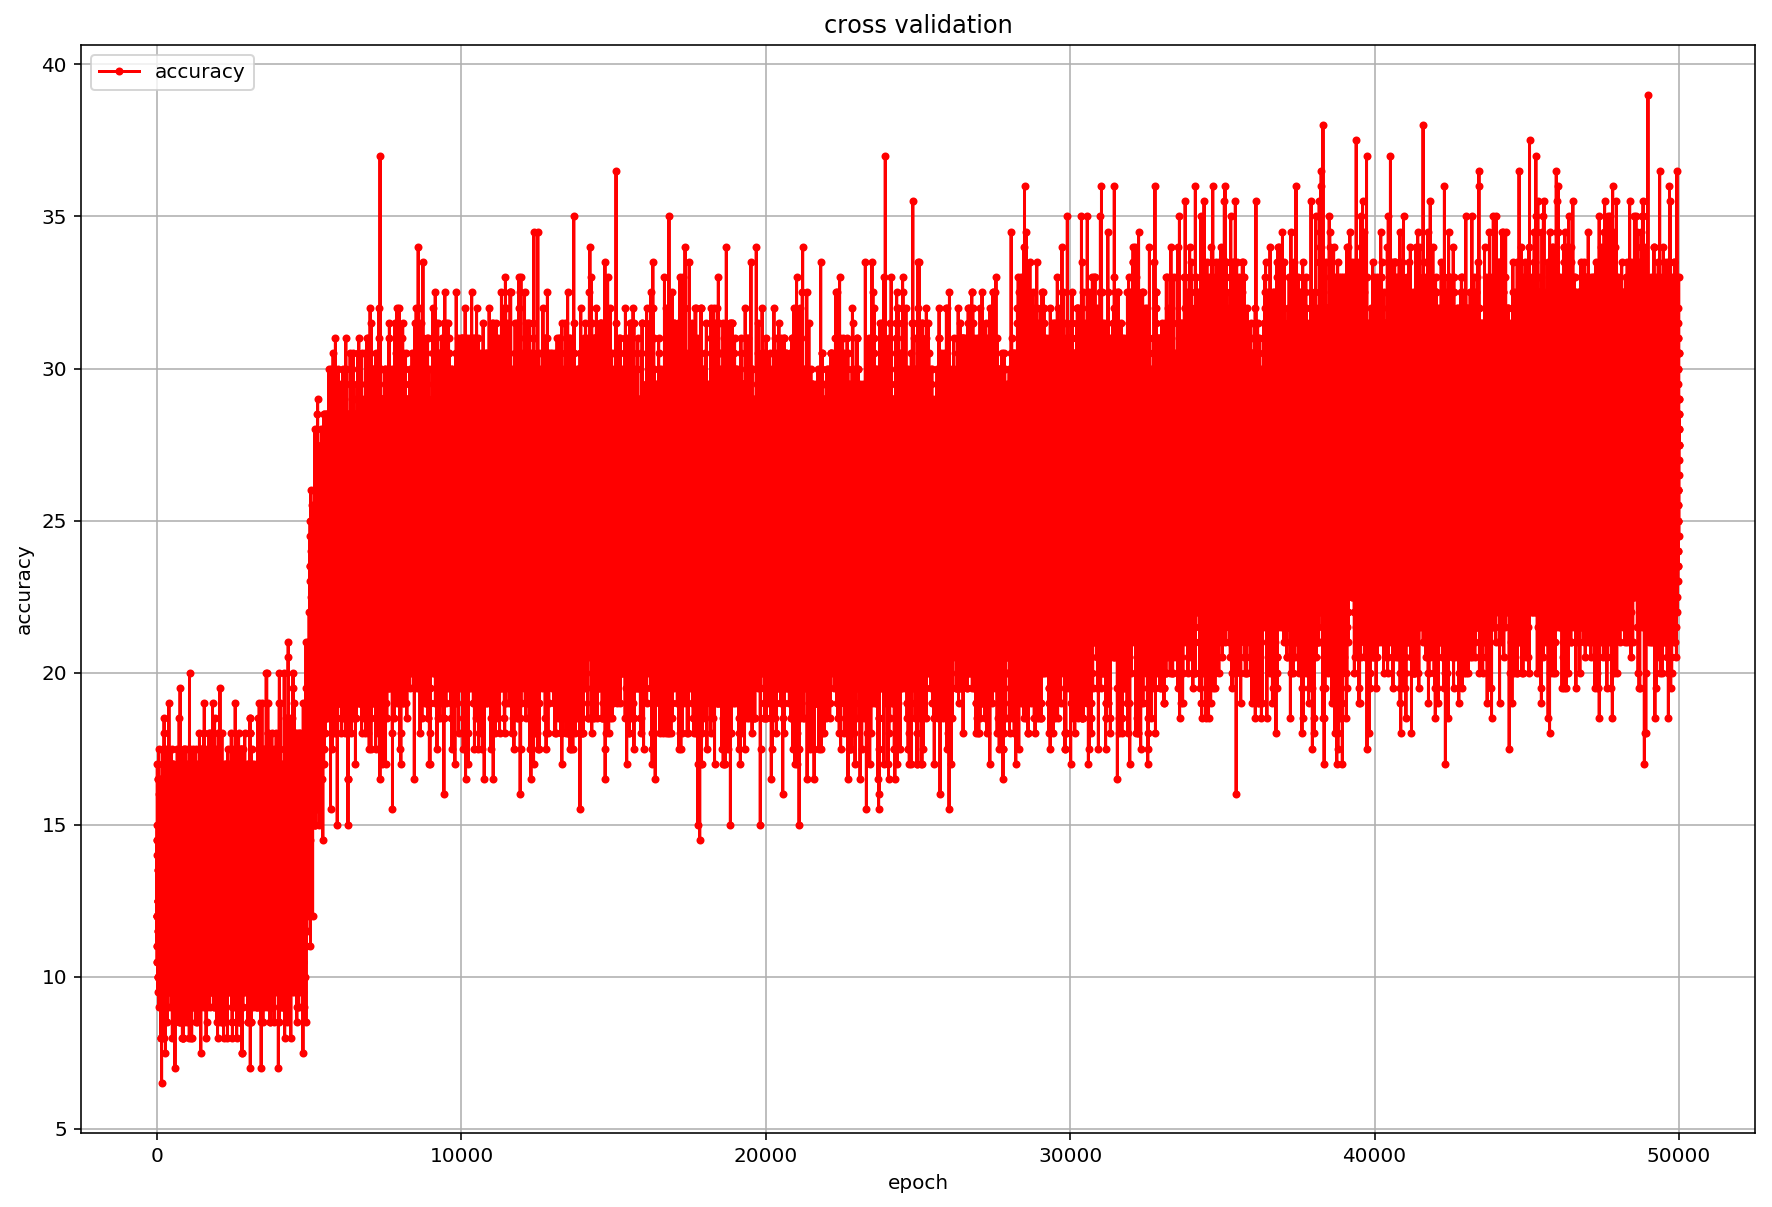

In [23]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

## first run 12.12.18

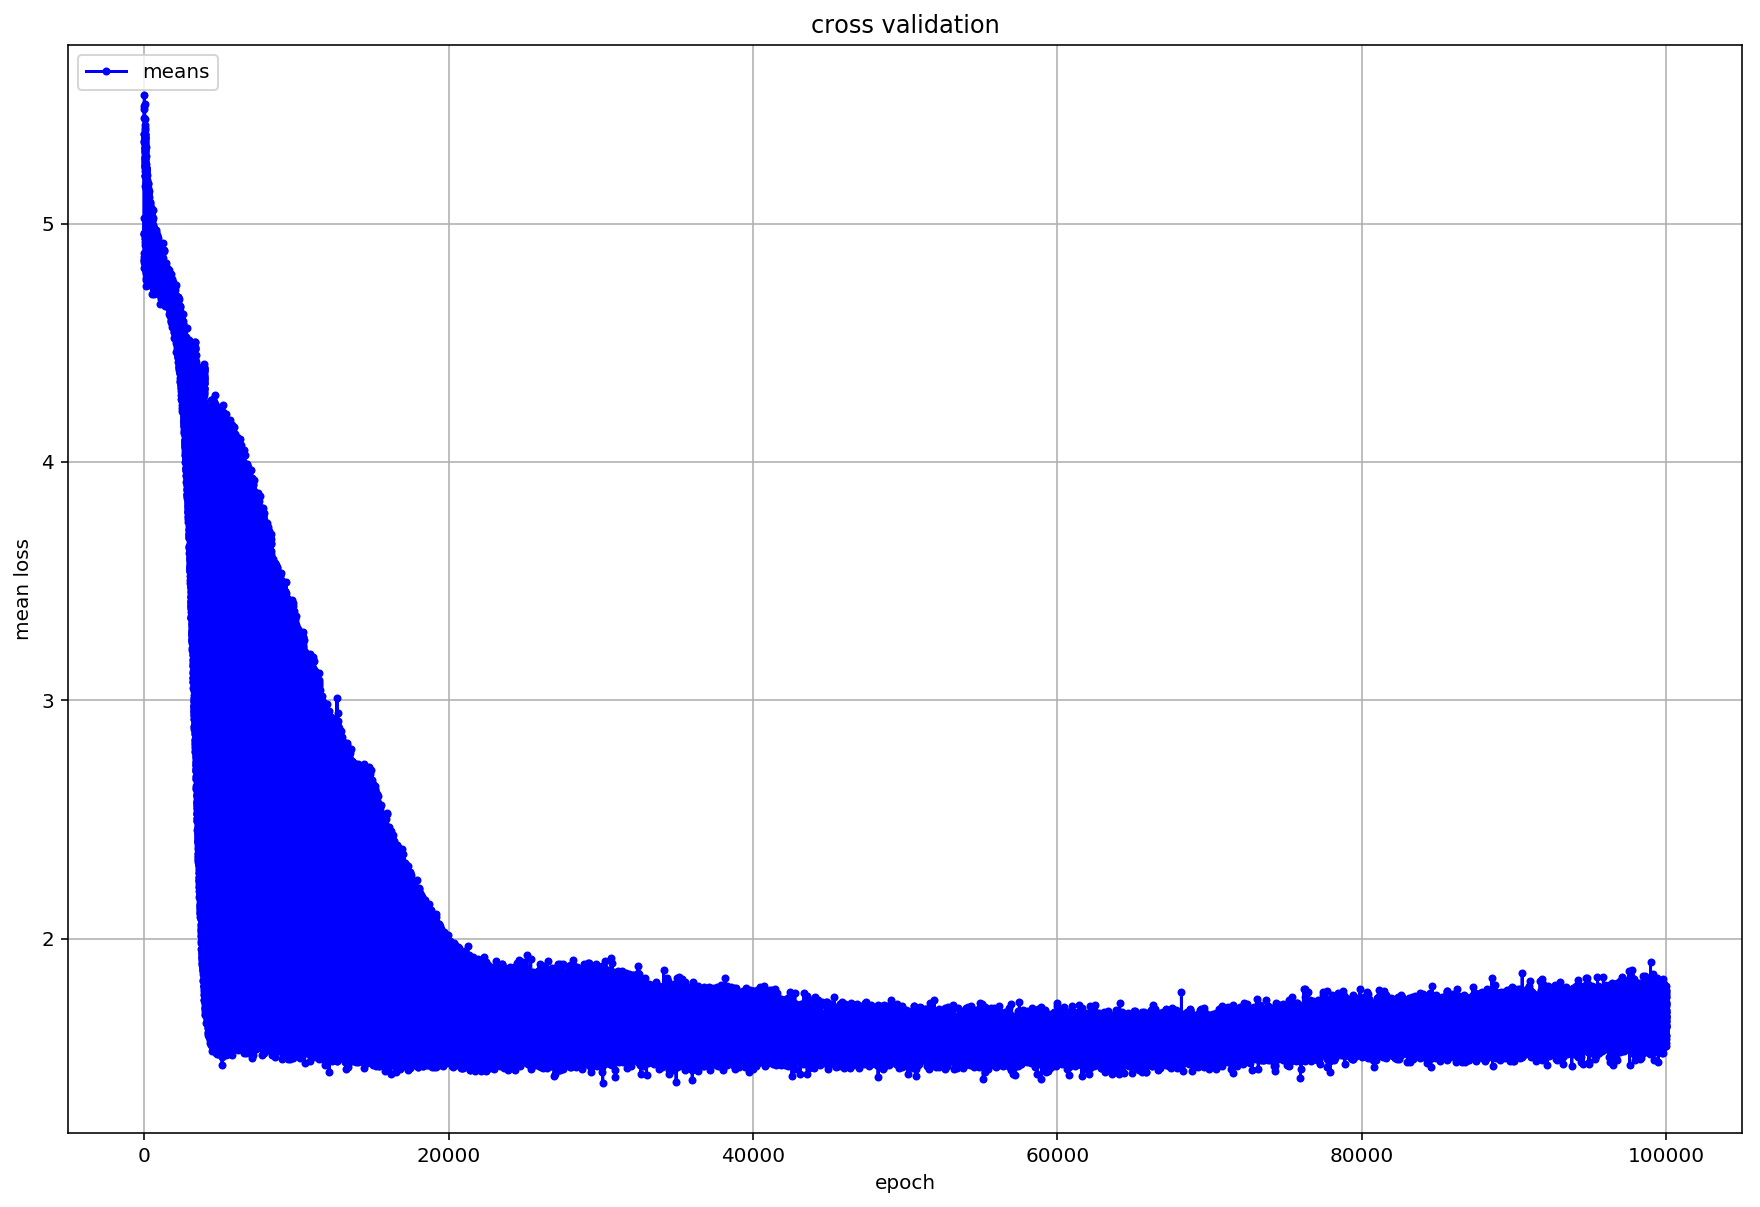

In [7]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0), save=True, filename='-5_norm_new')

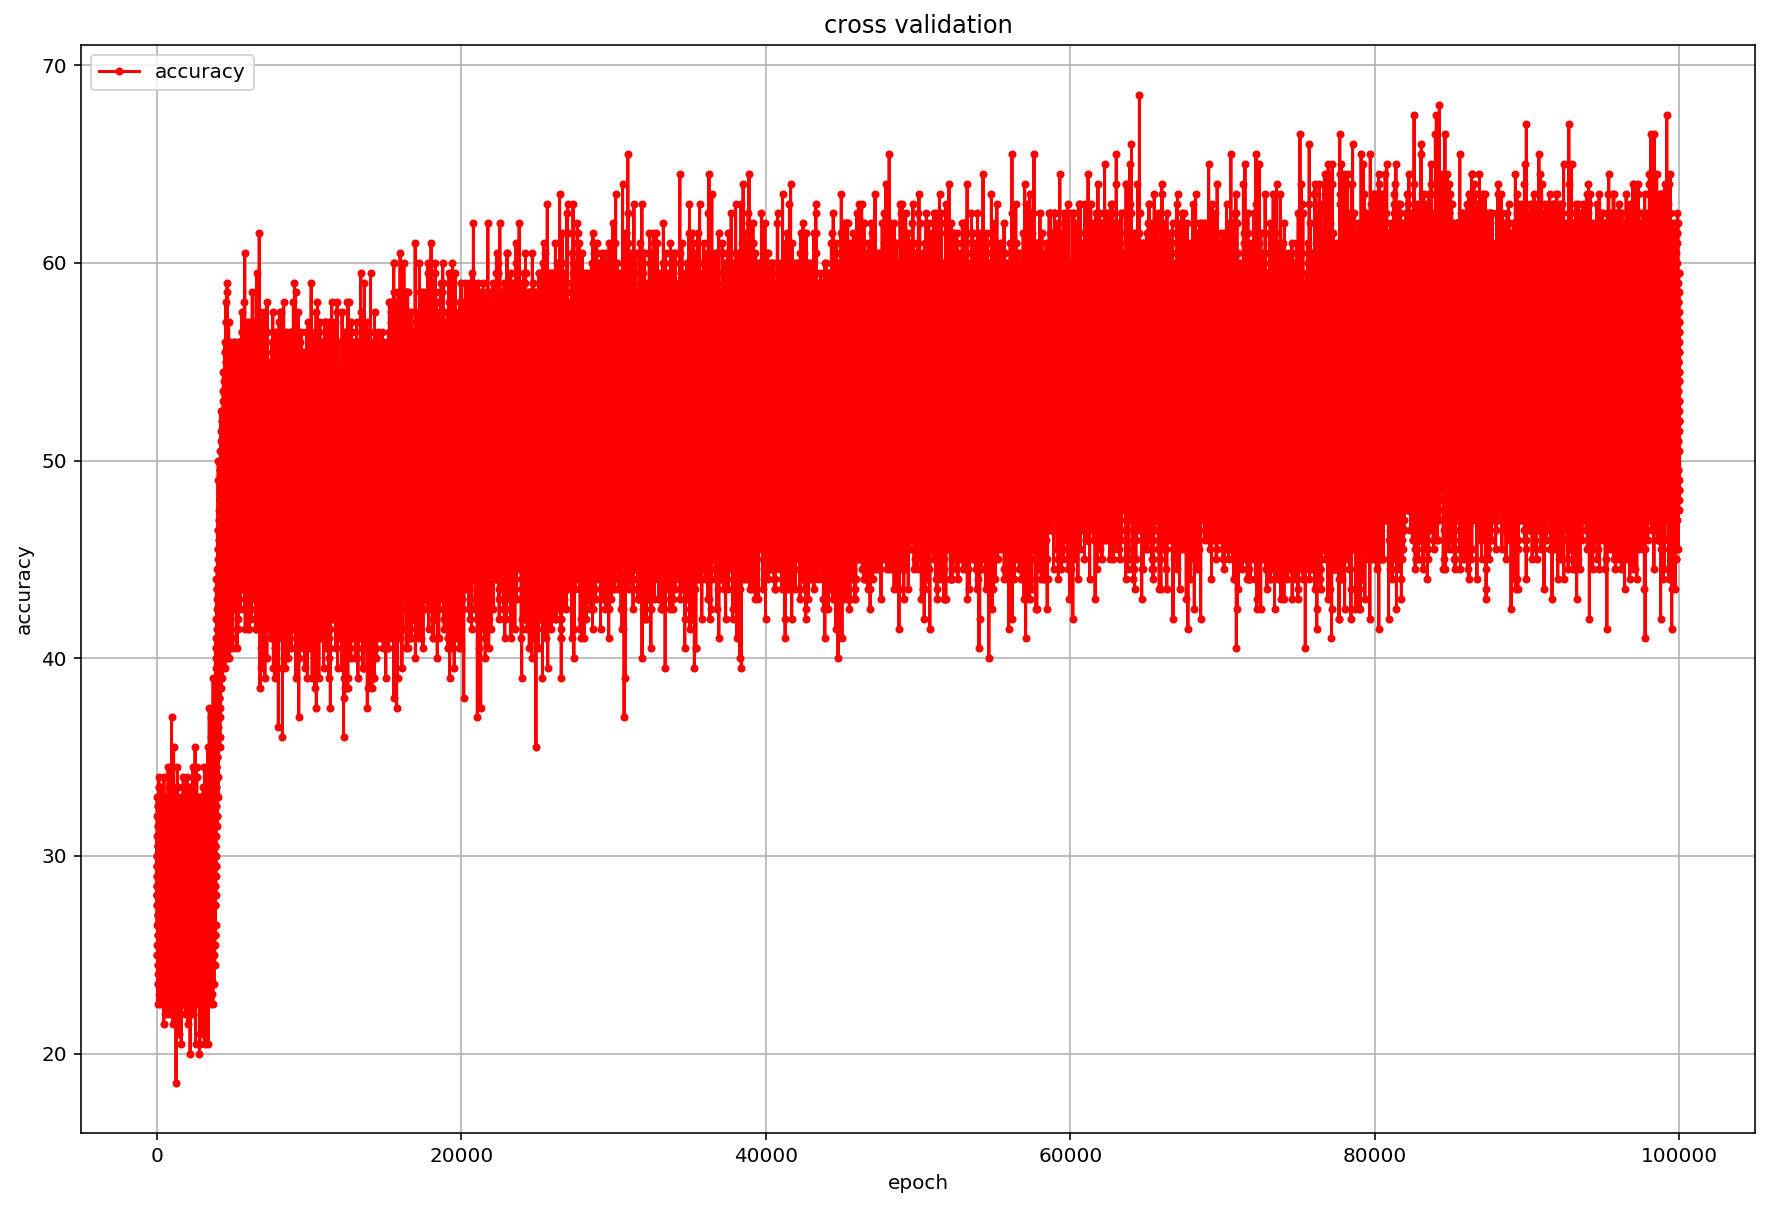

In [8]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), save=True, filename='acc_-5_norm_new')

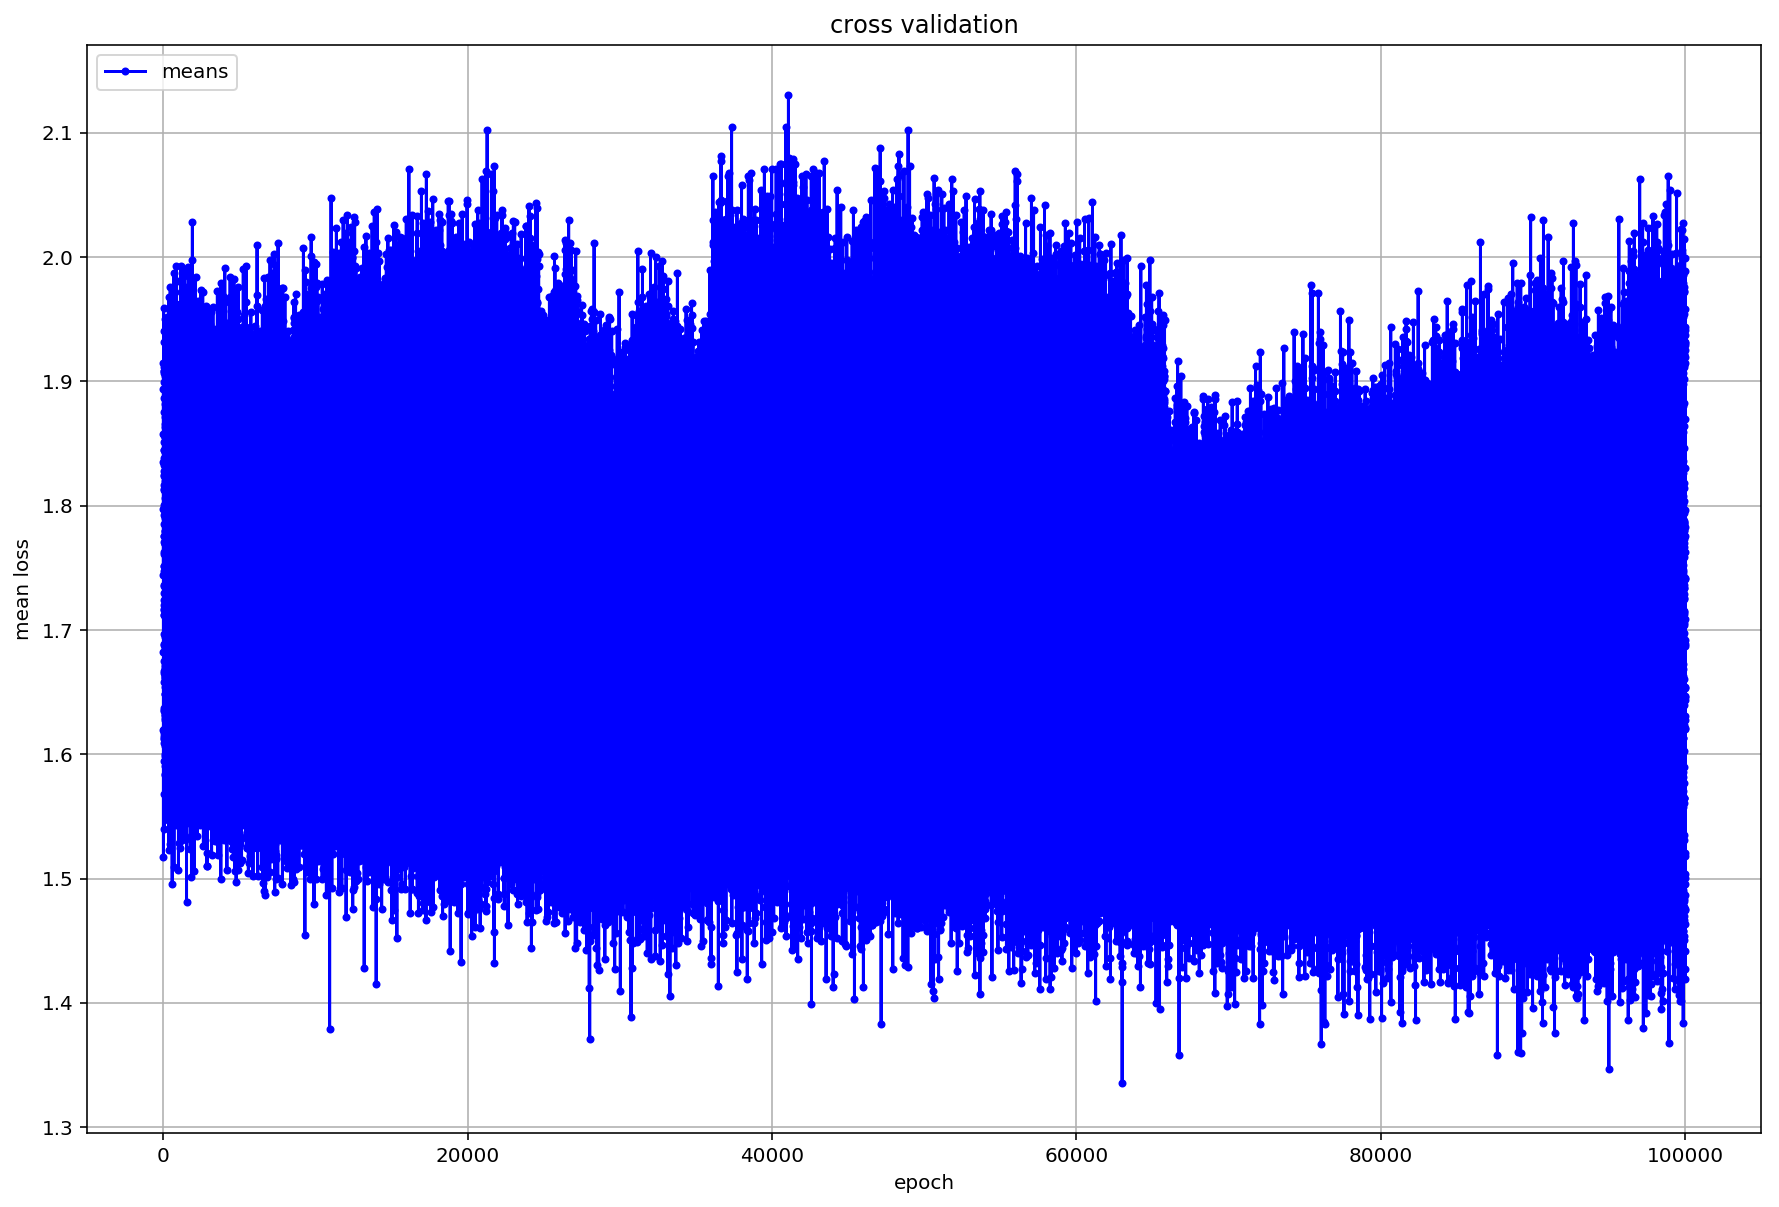

In [14]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0), save=True, filename='-5_norm_new2')

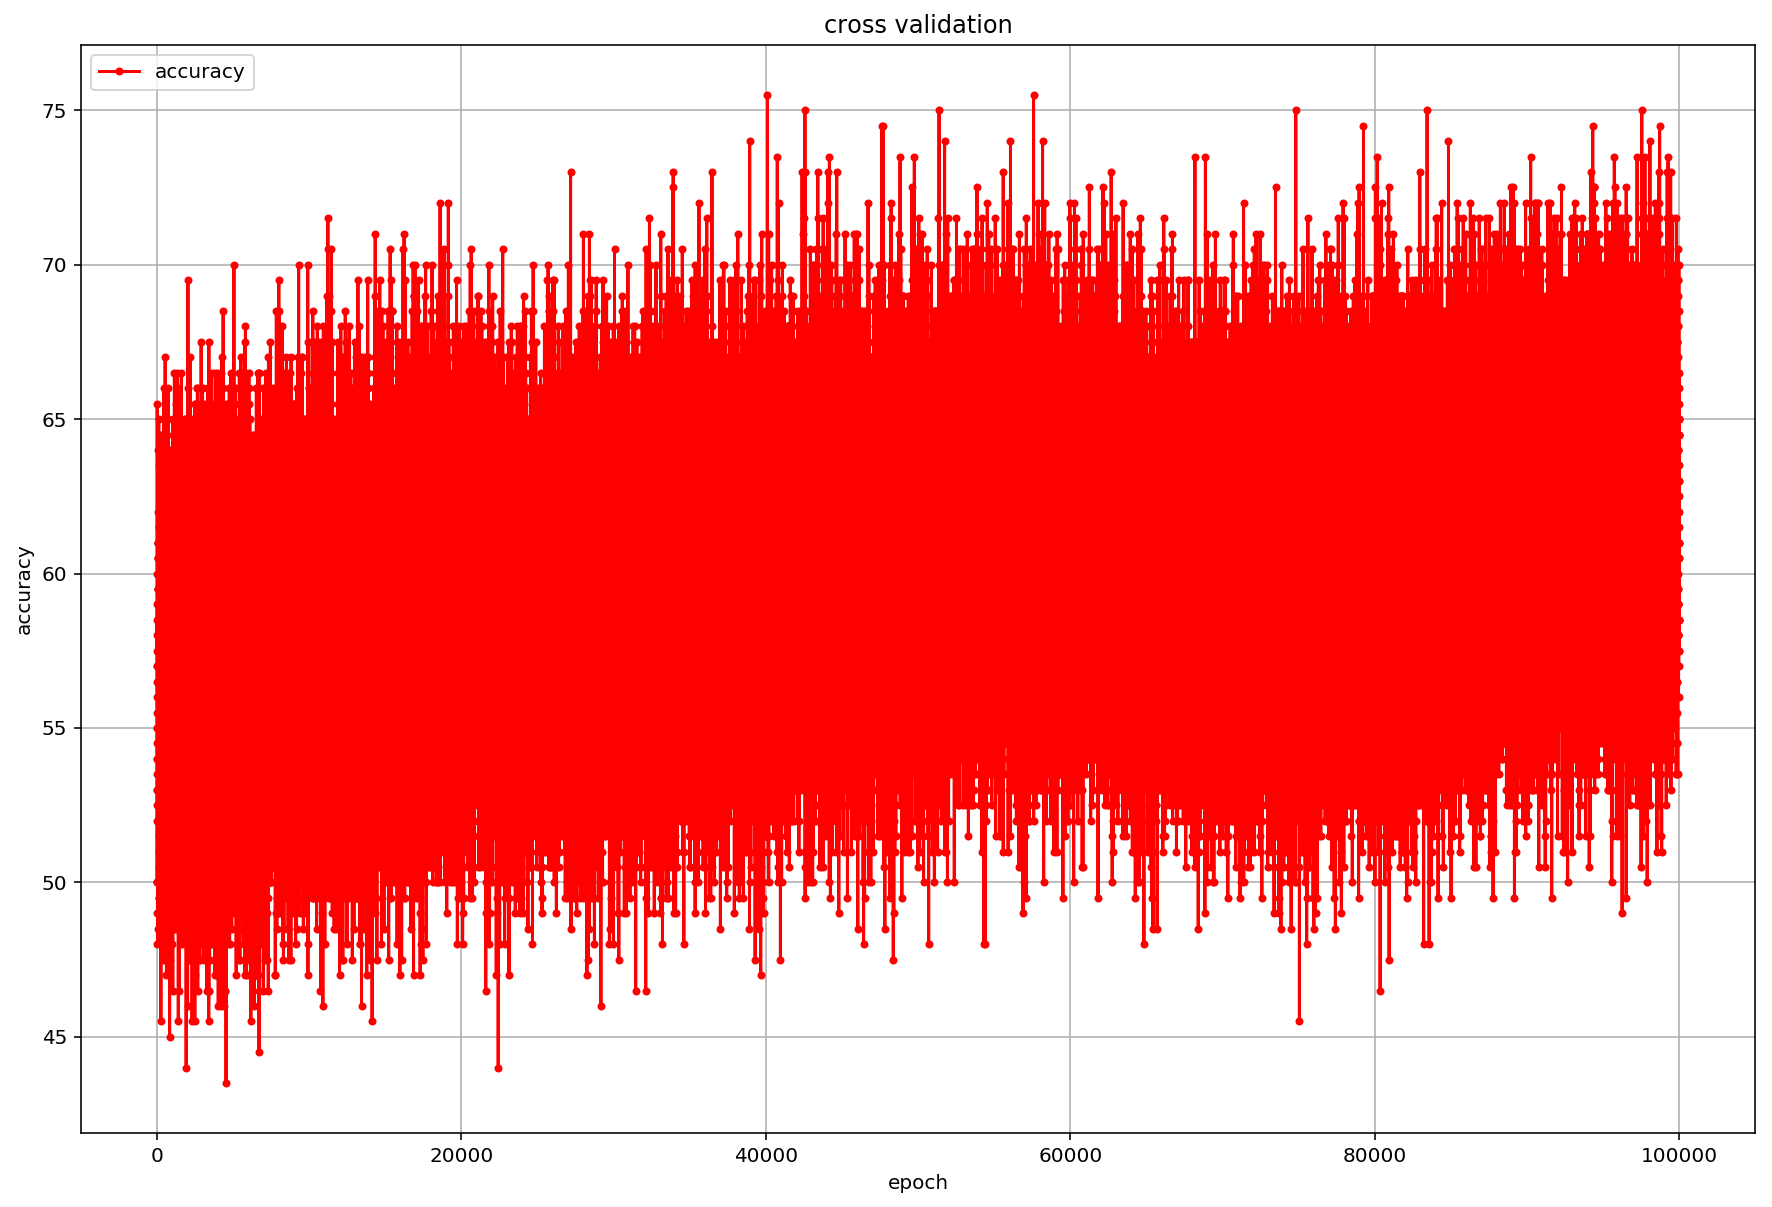

In [12]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), save=True, filename='acc_-5_norm_new2')

## second run 12.12.18

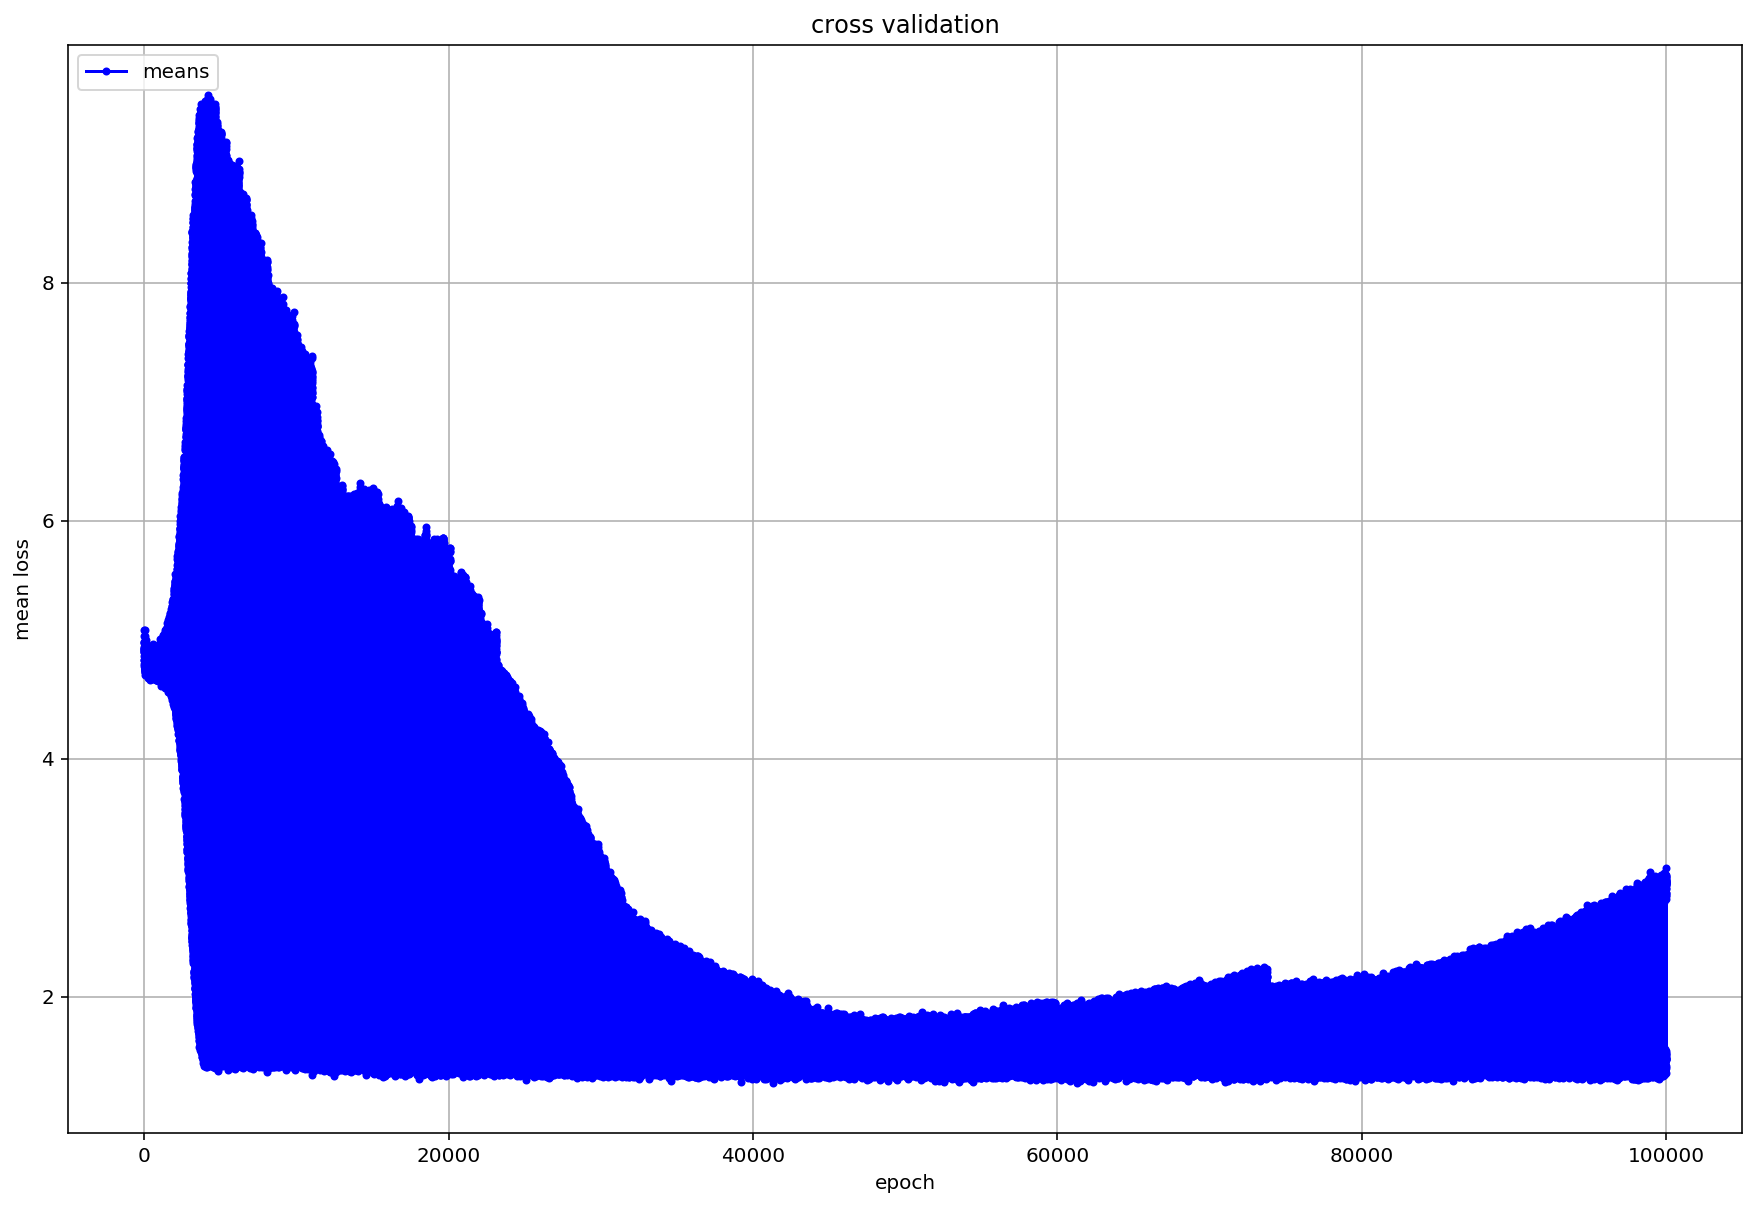

In [7]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0), save=True, filename='-5_norm_new3')

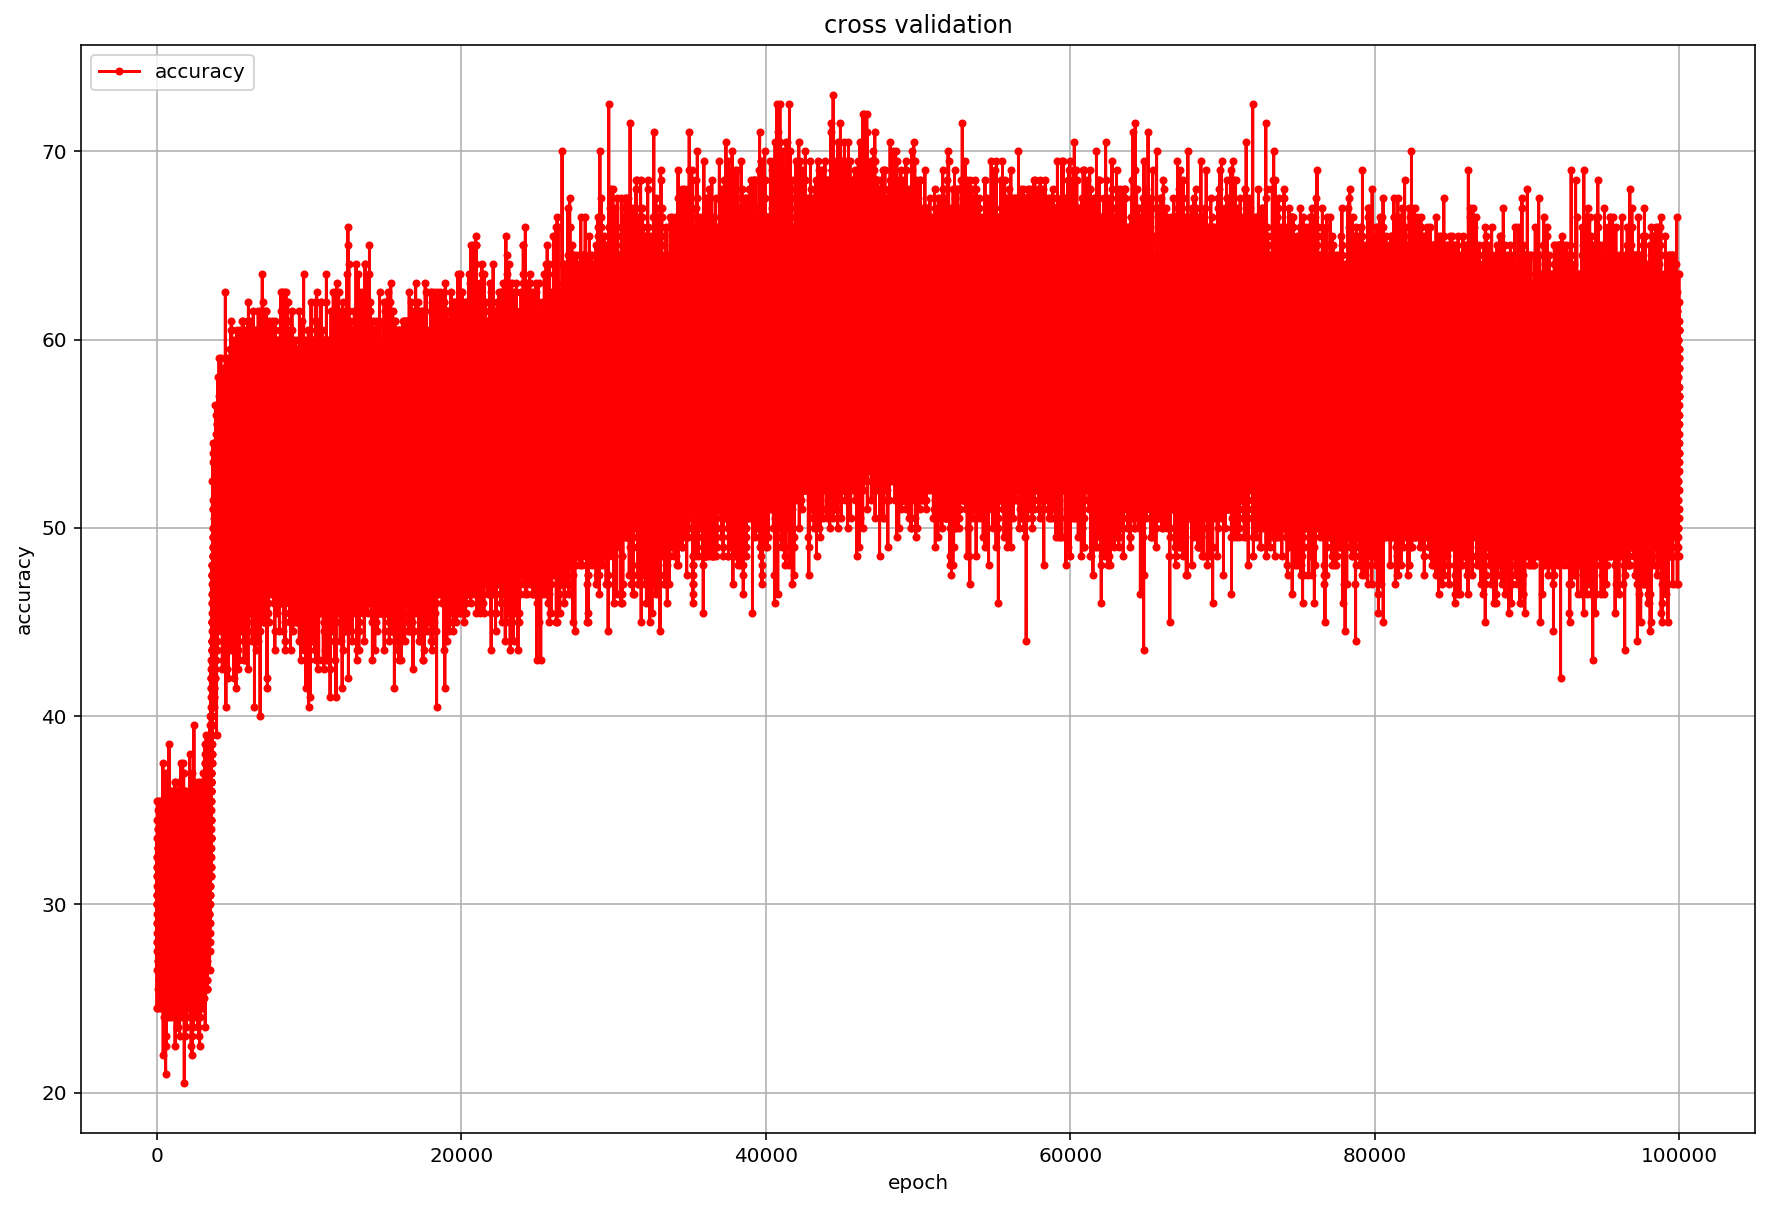

In [8]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0), save=True, filename='-5_norm_new3')

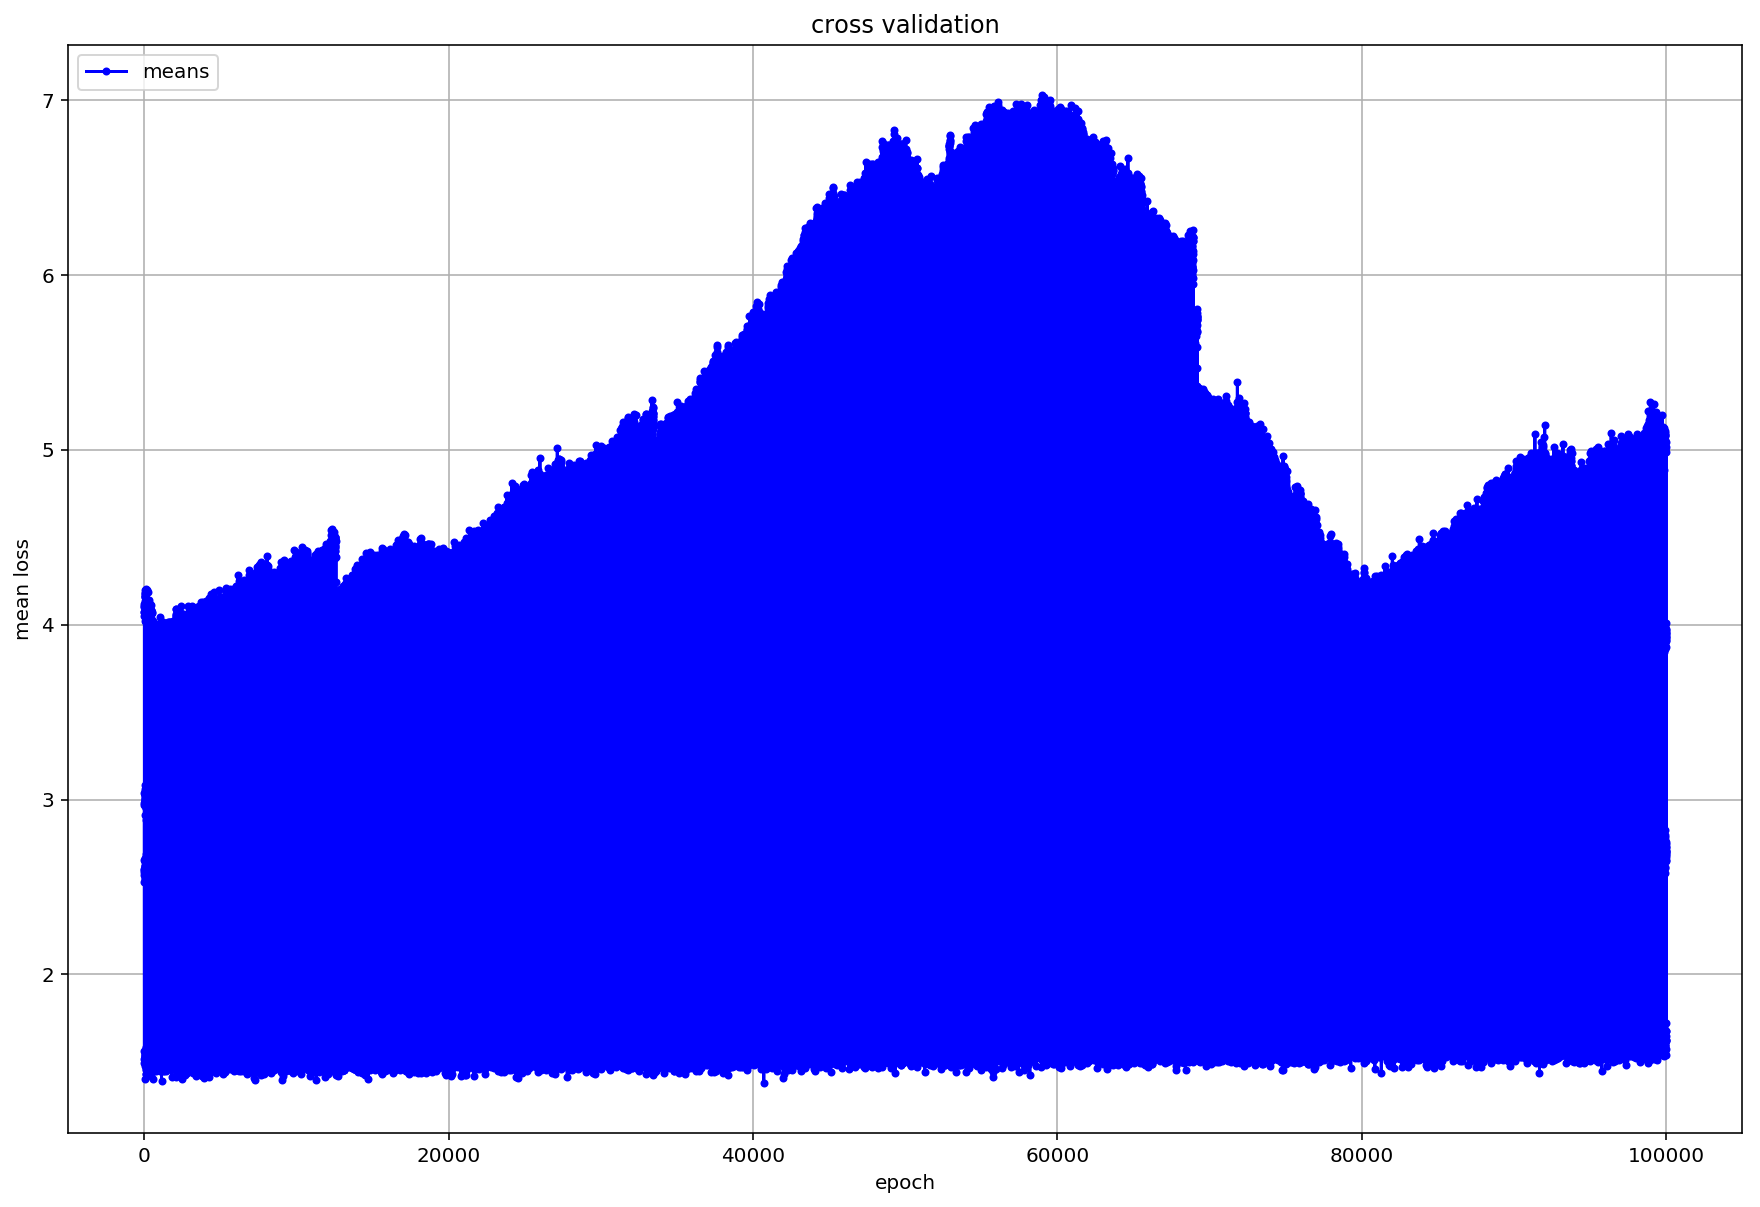

In [10]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

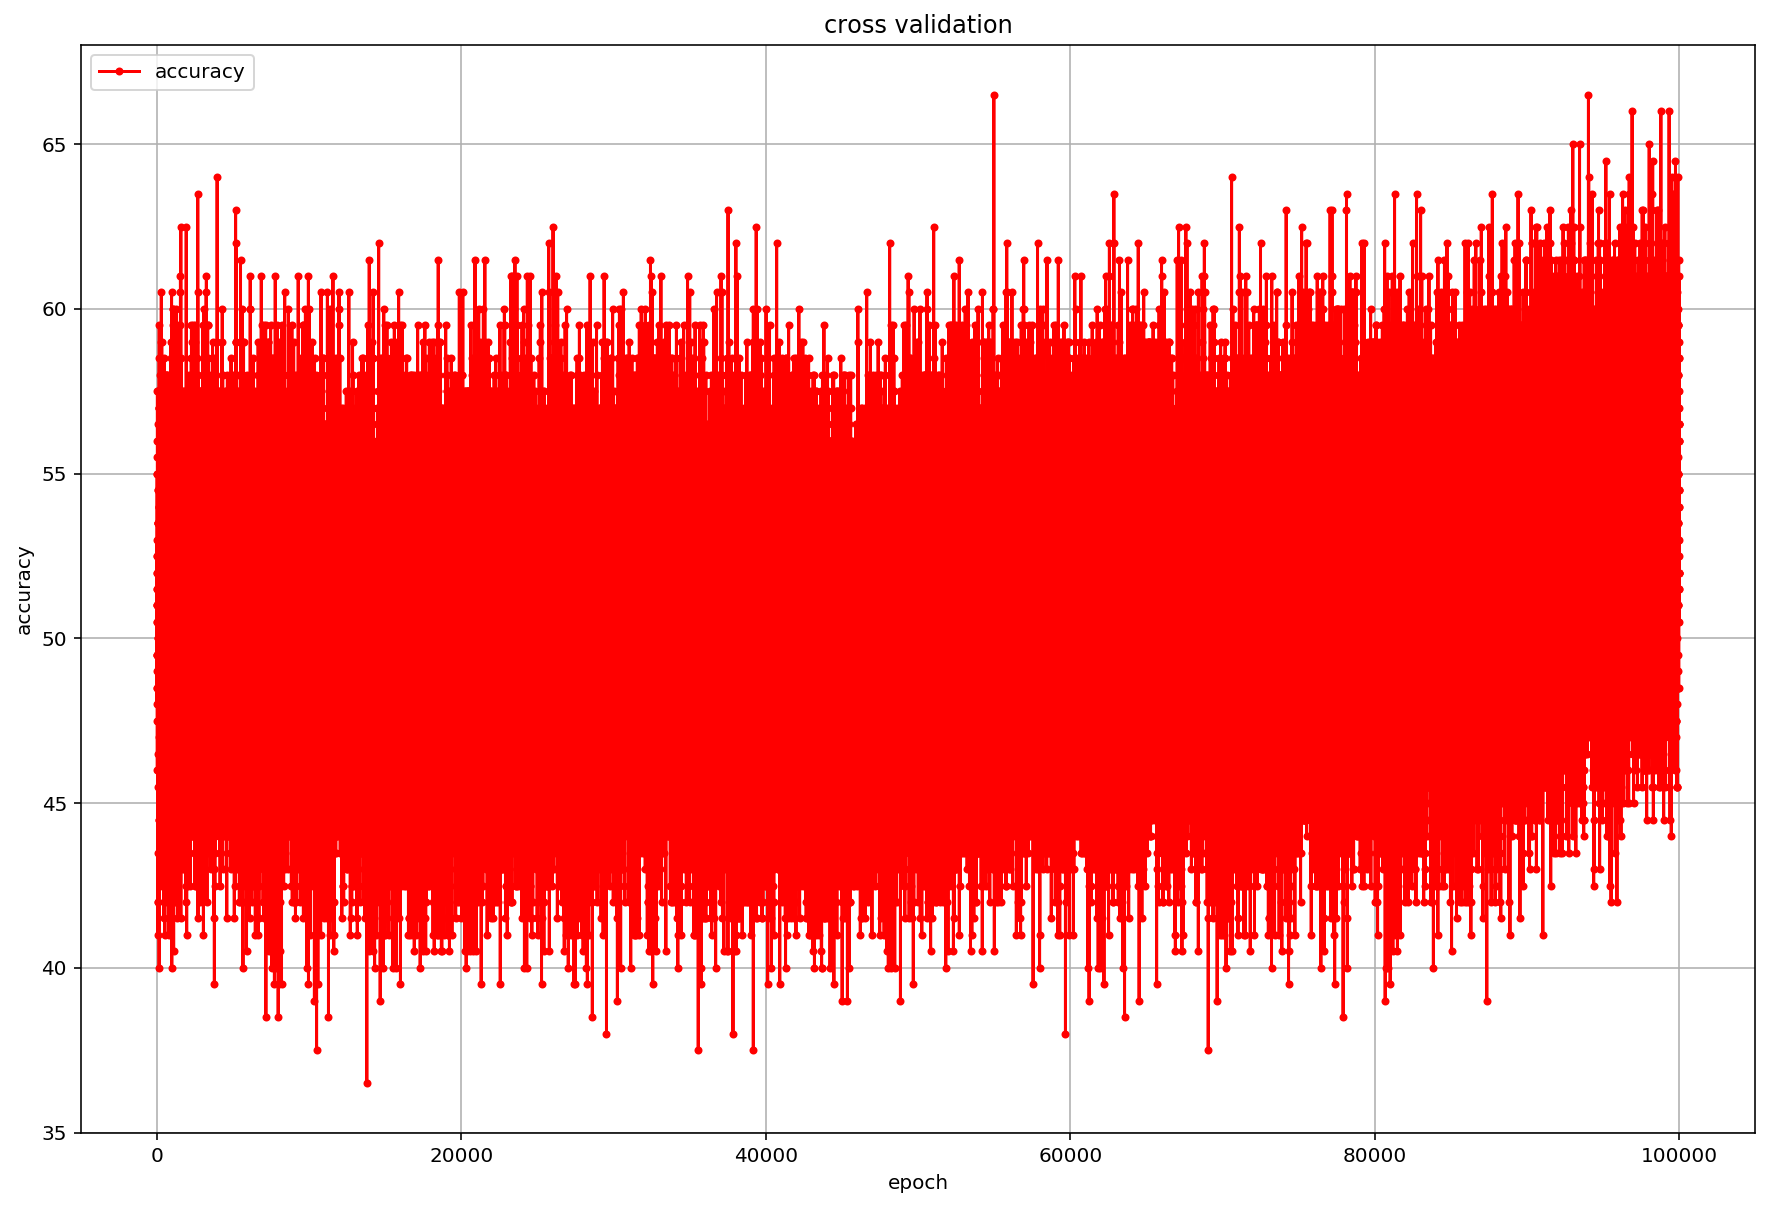

In [11]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

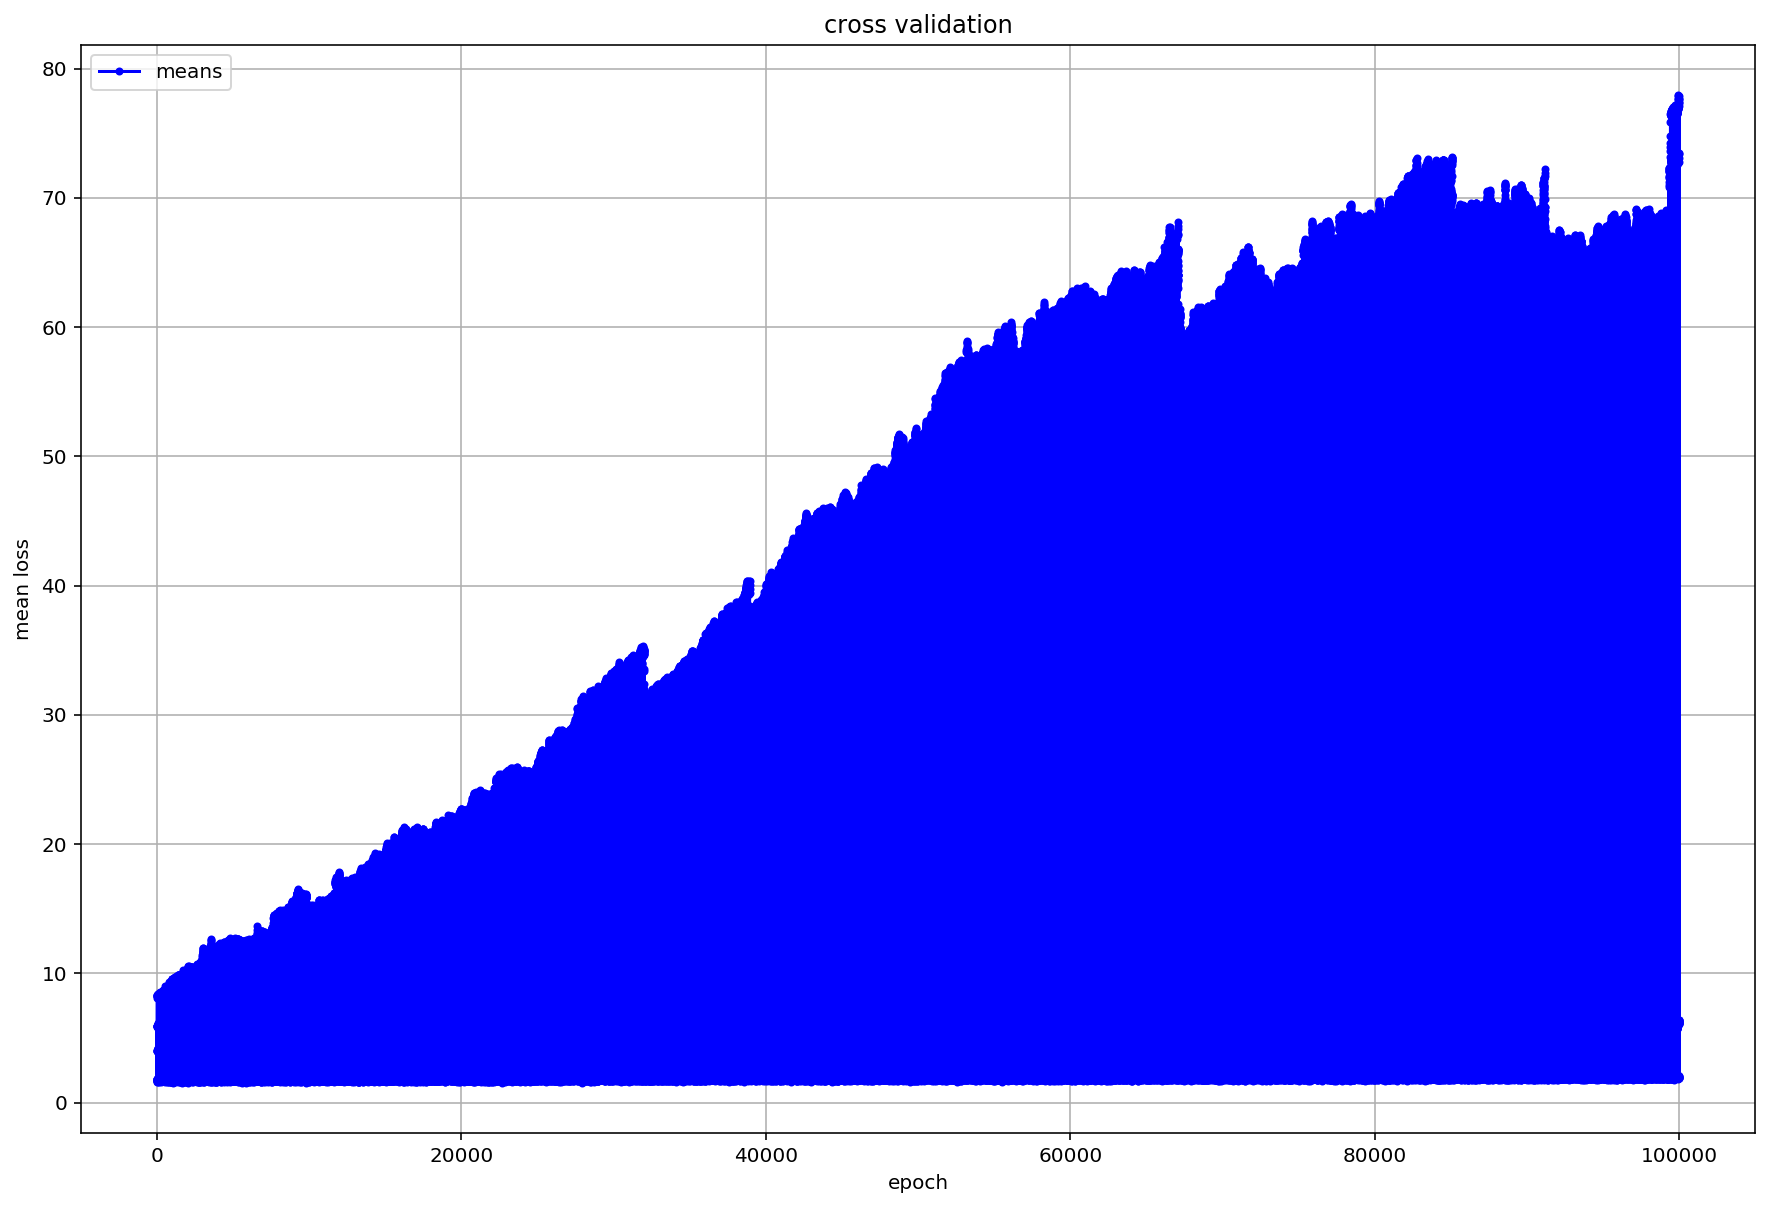

In [13]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

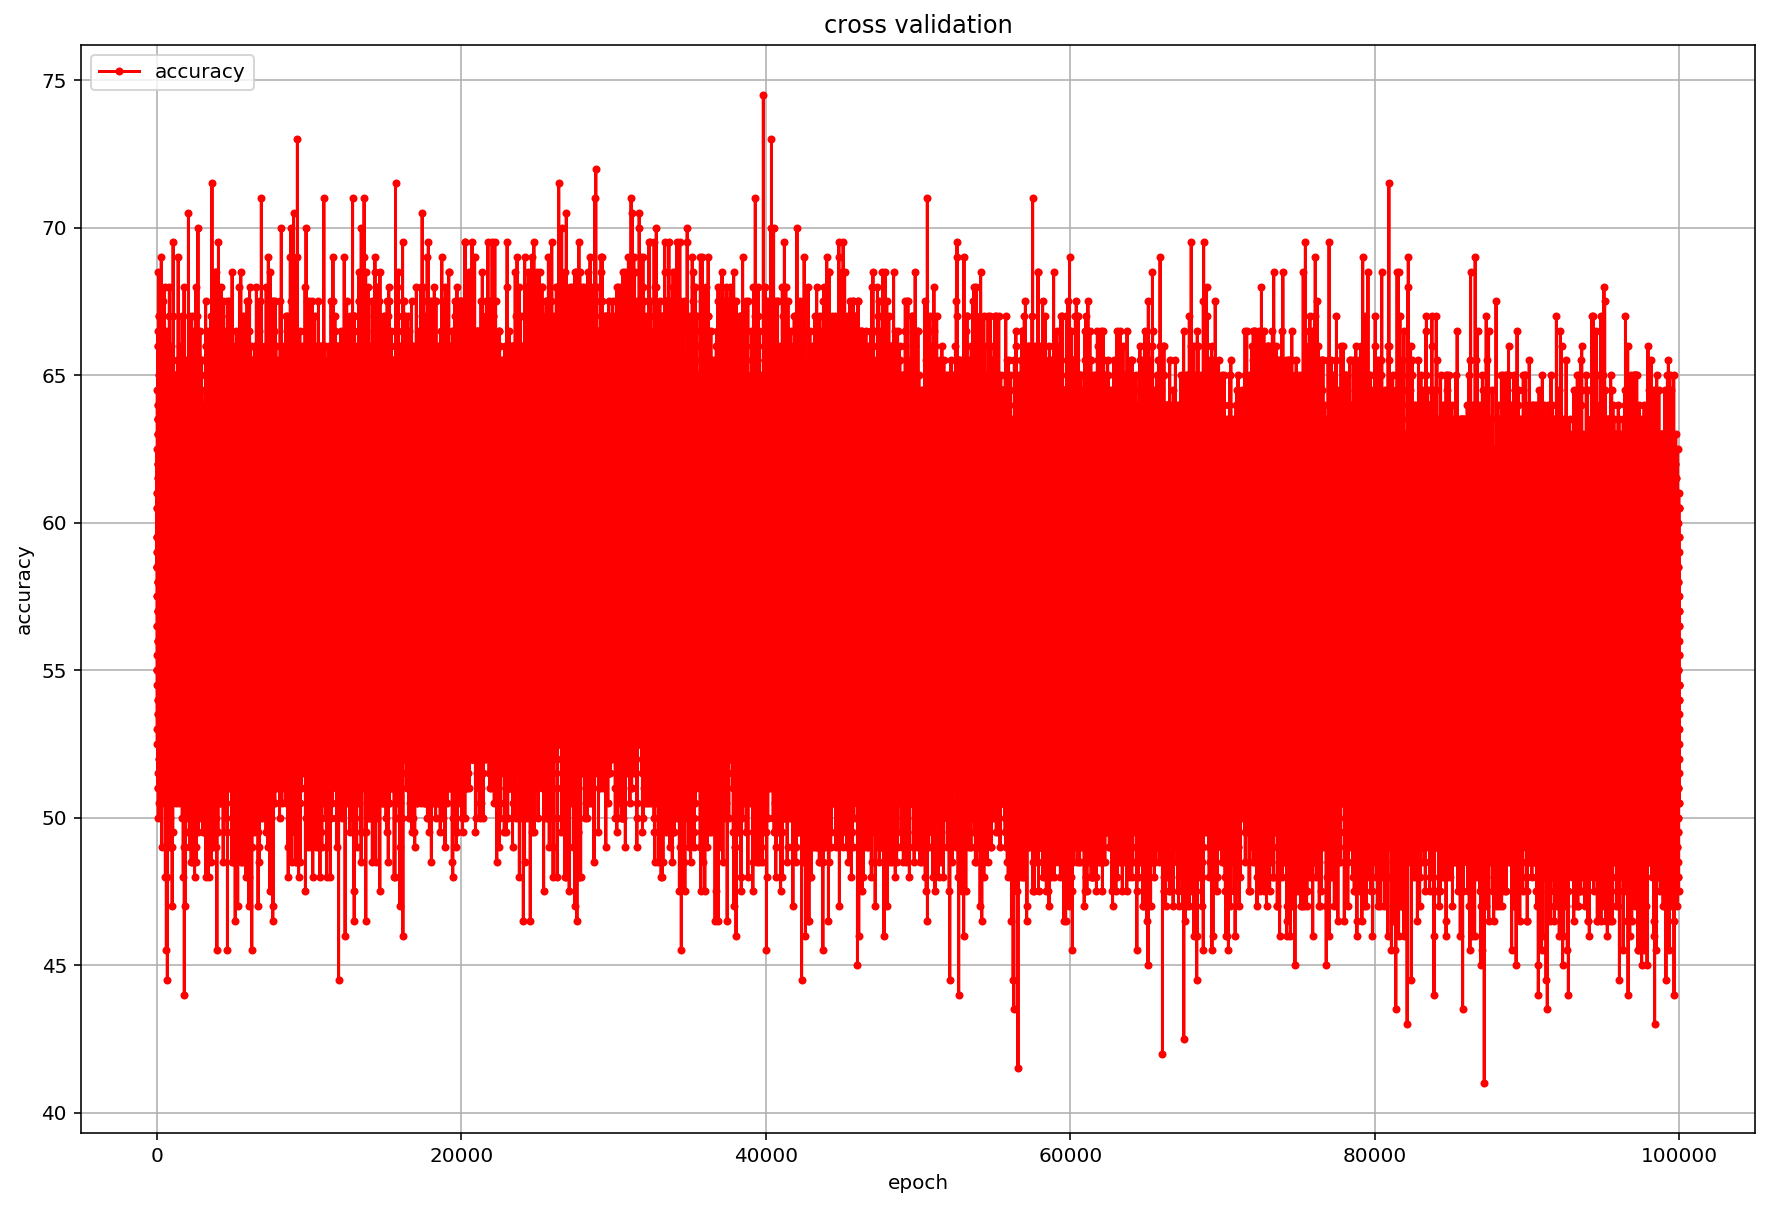

In [14]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

## 3ème run 12.12.18

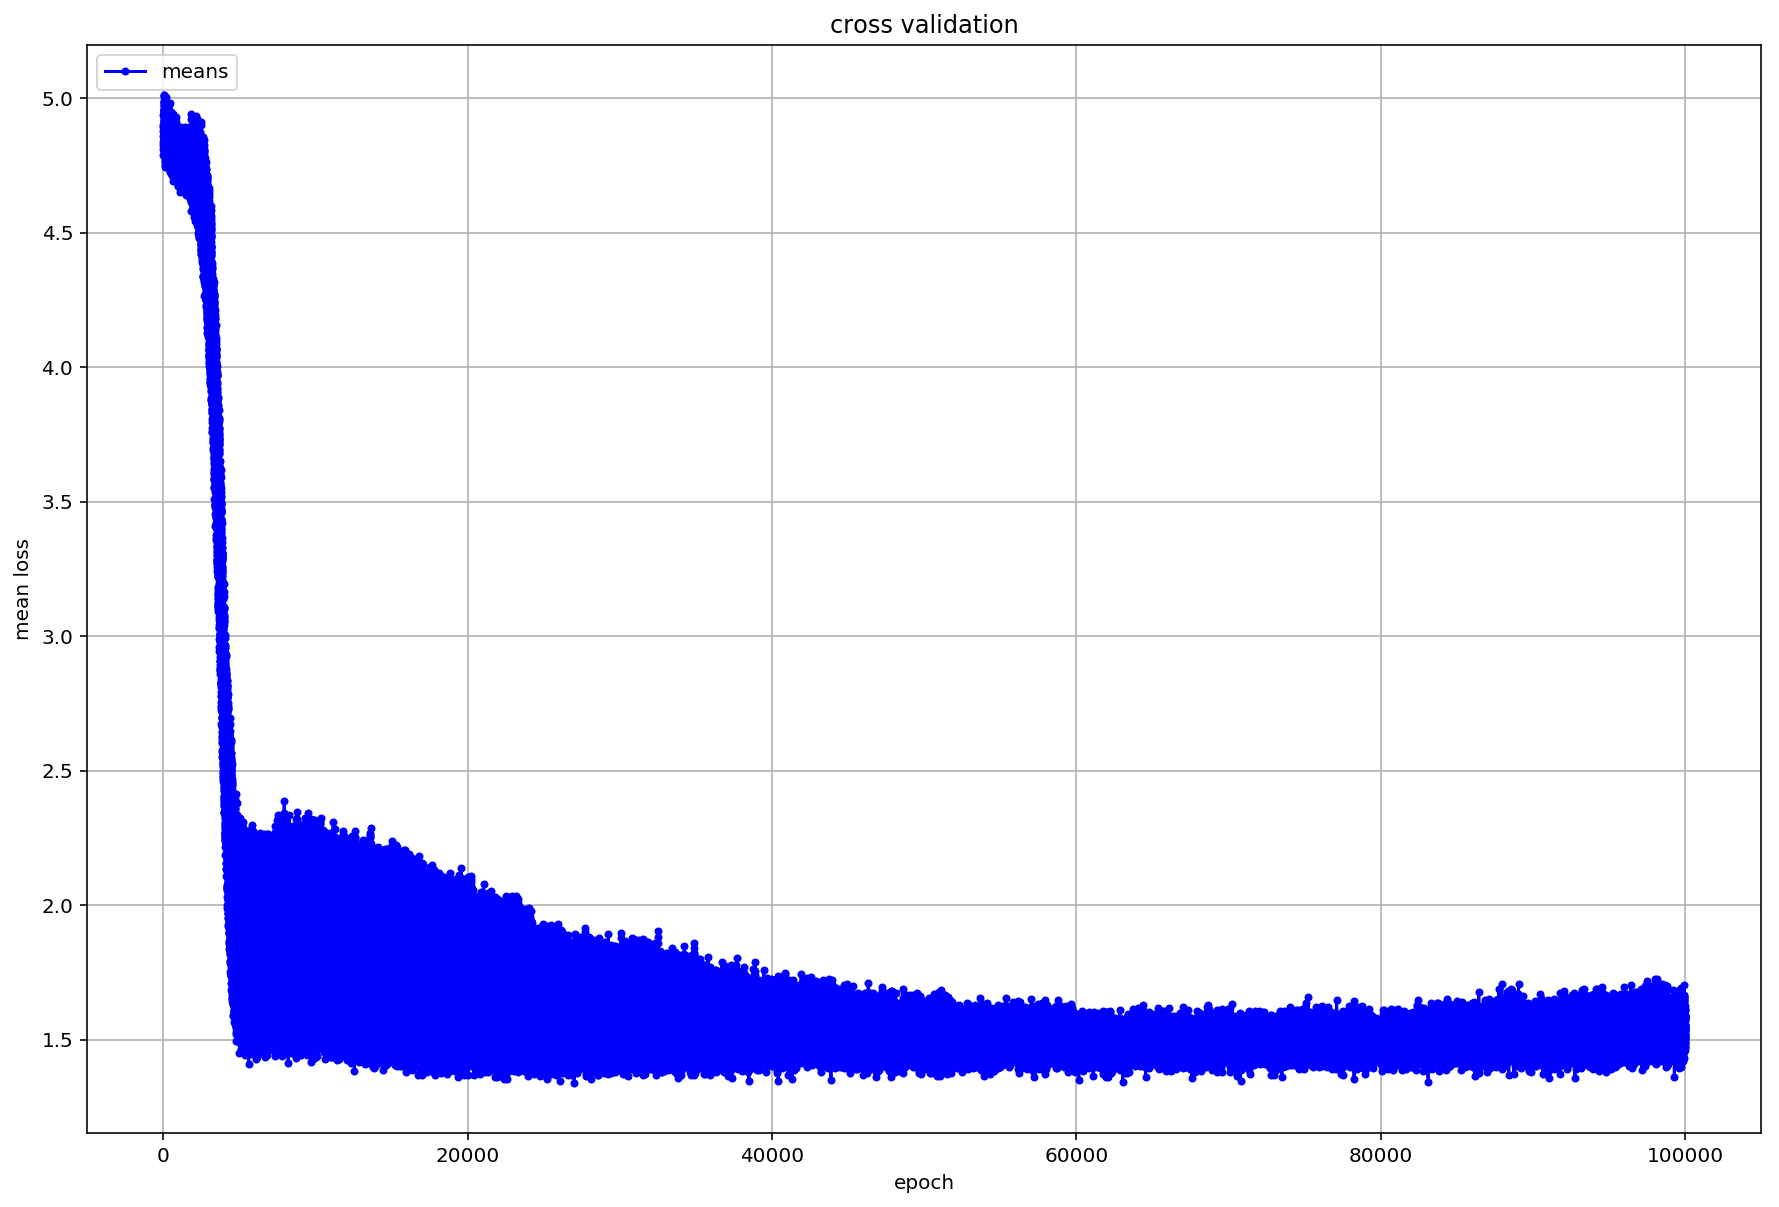

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

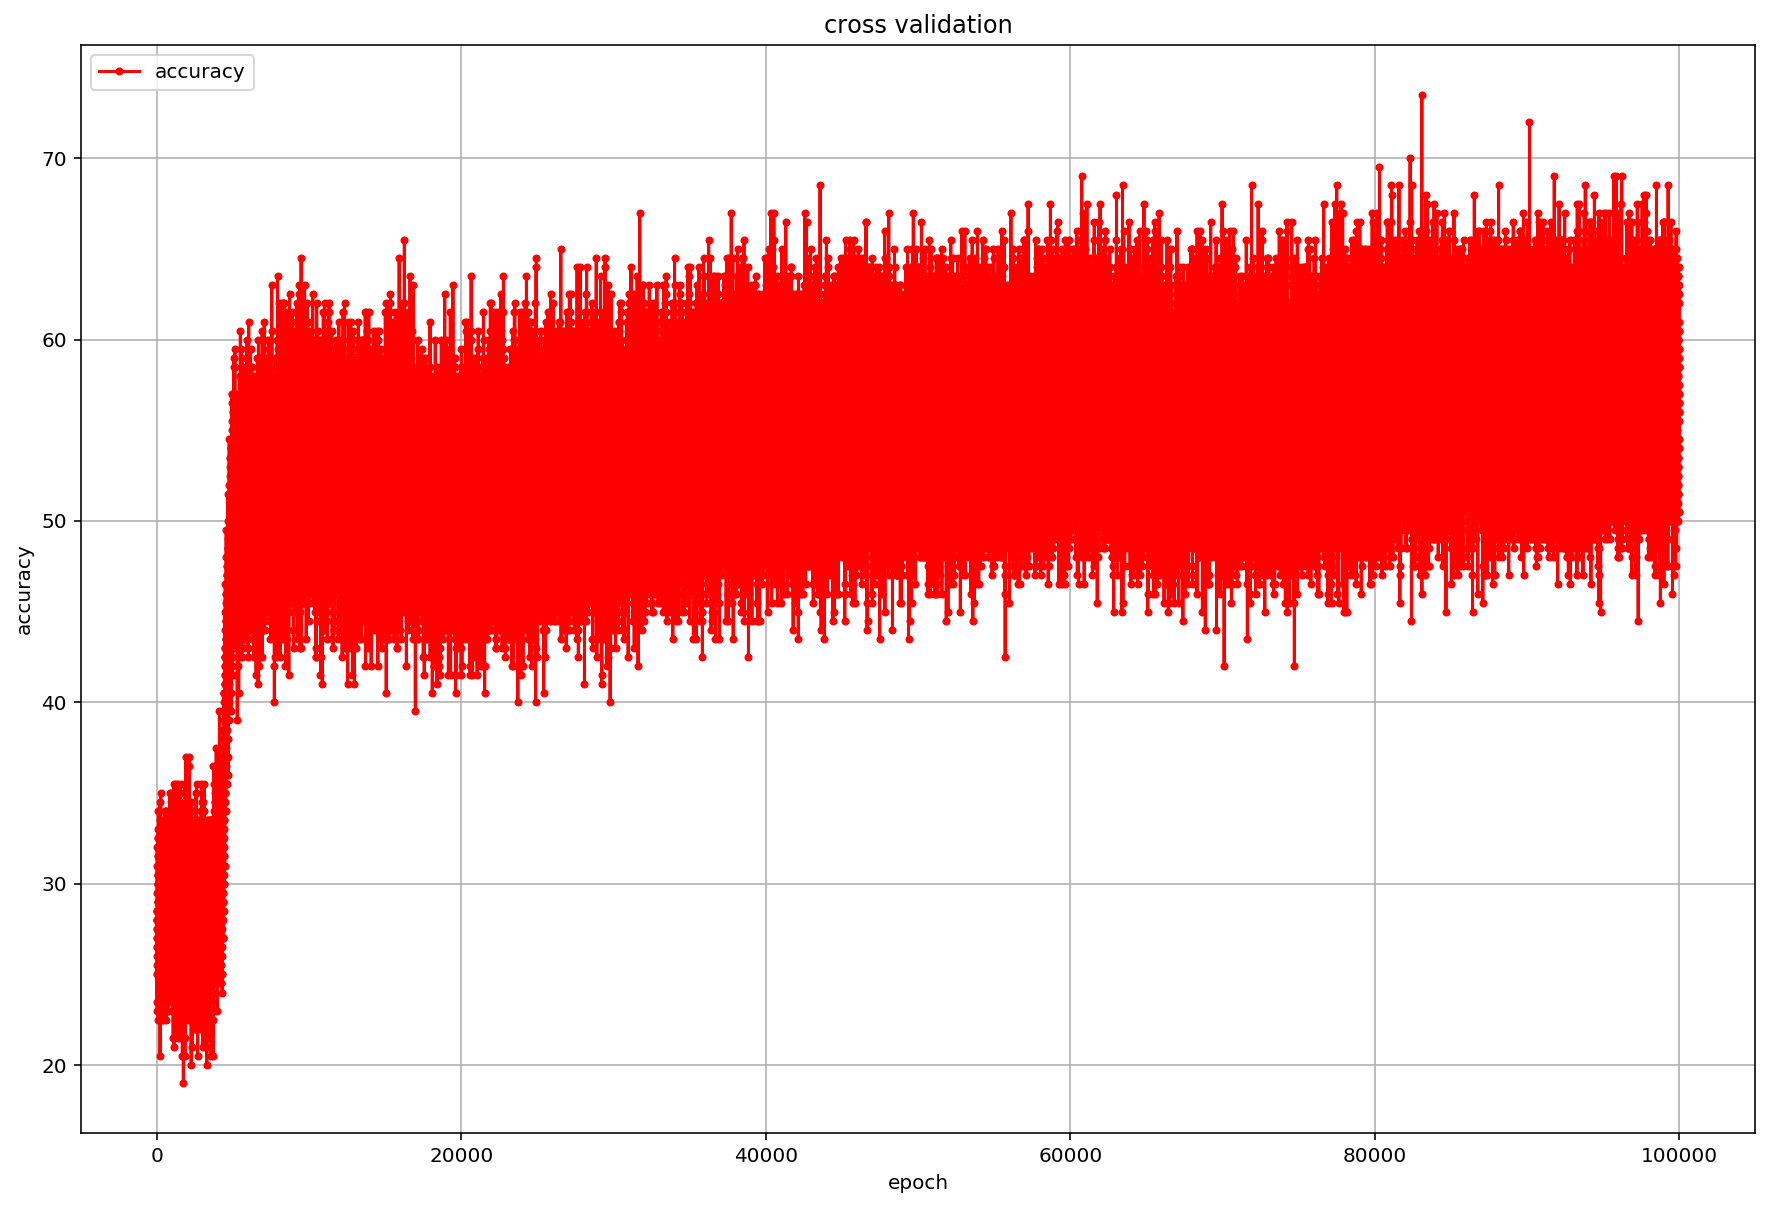

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

## 1er run 13.12.18

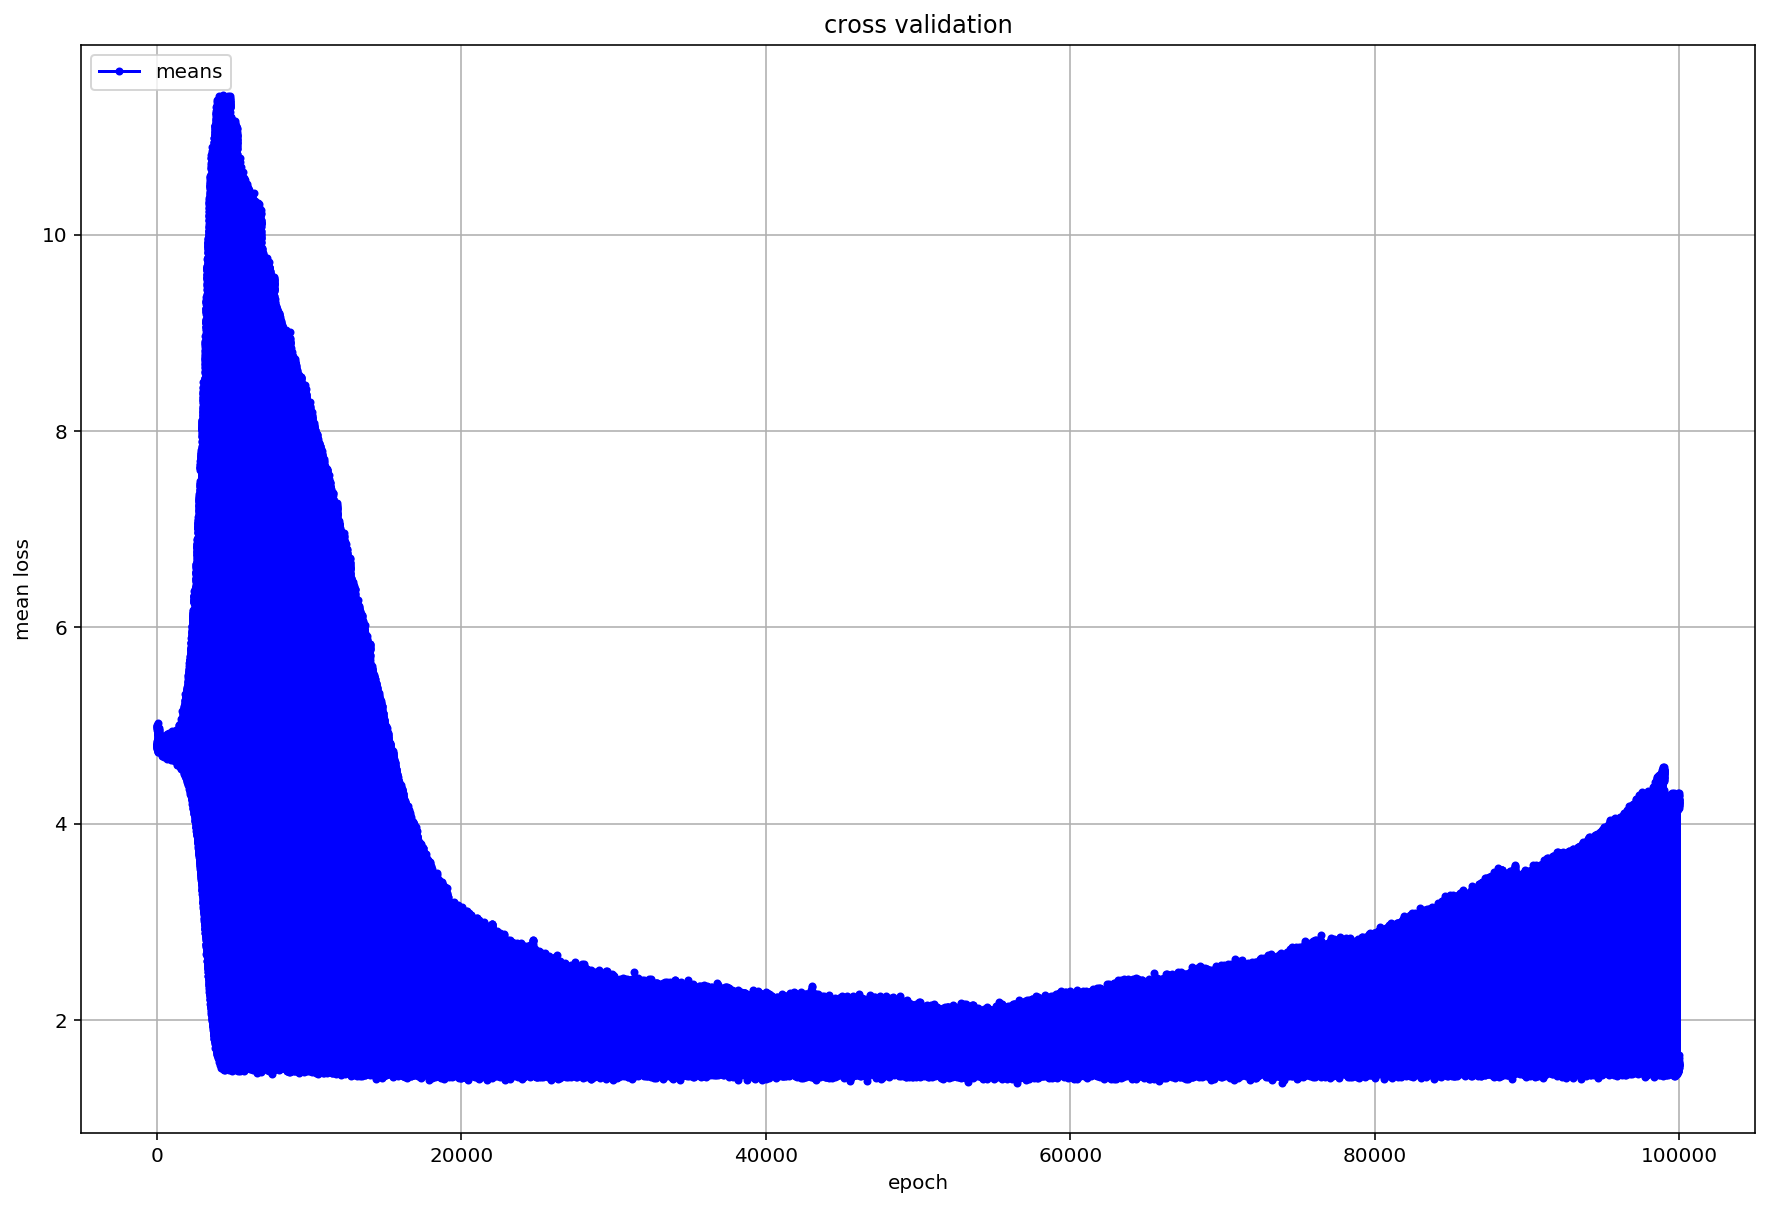

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

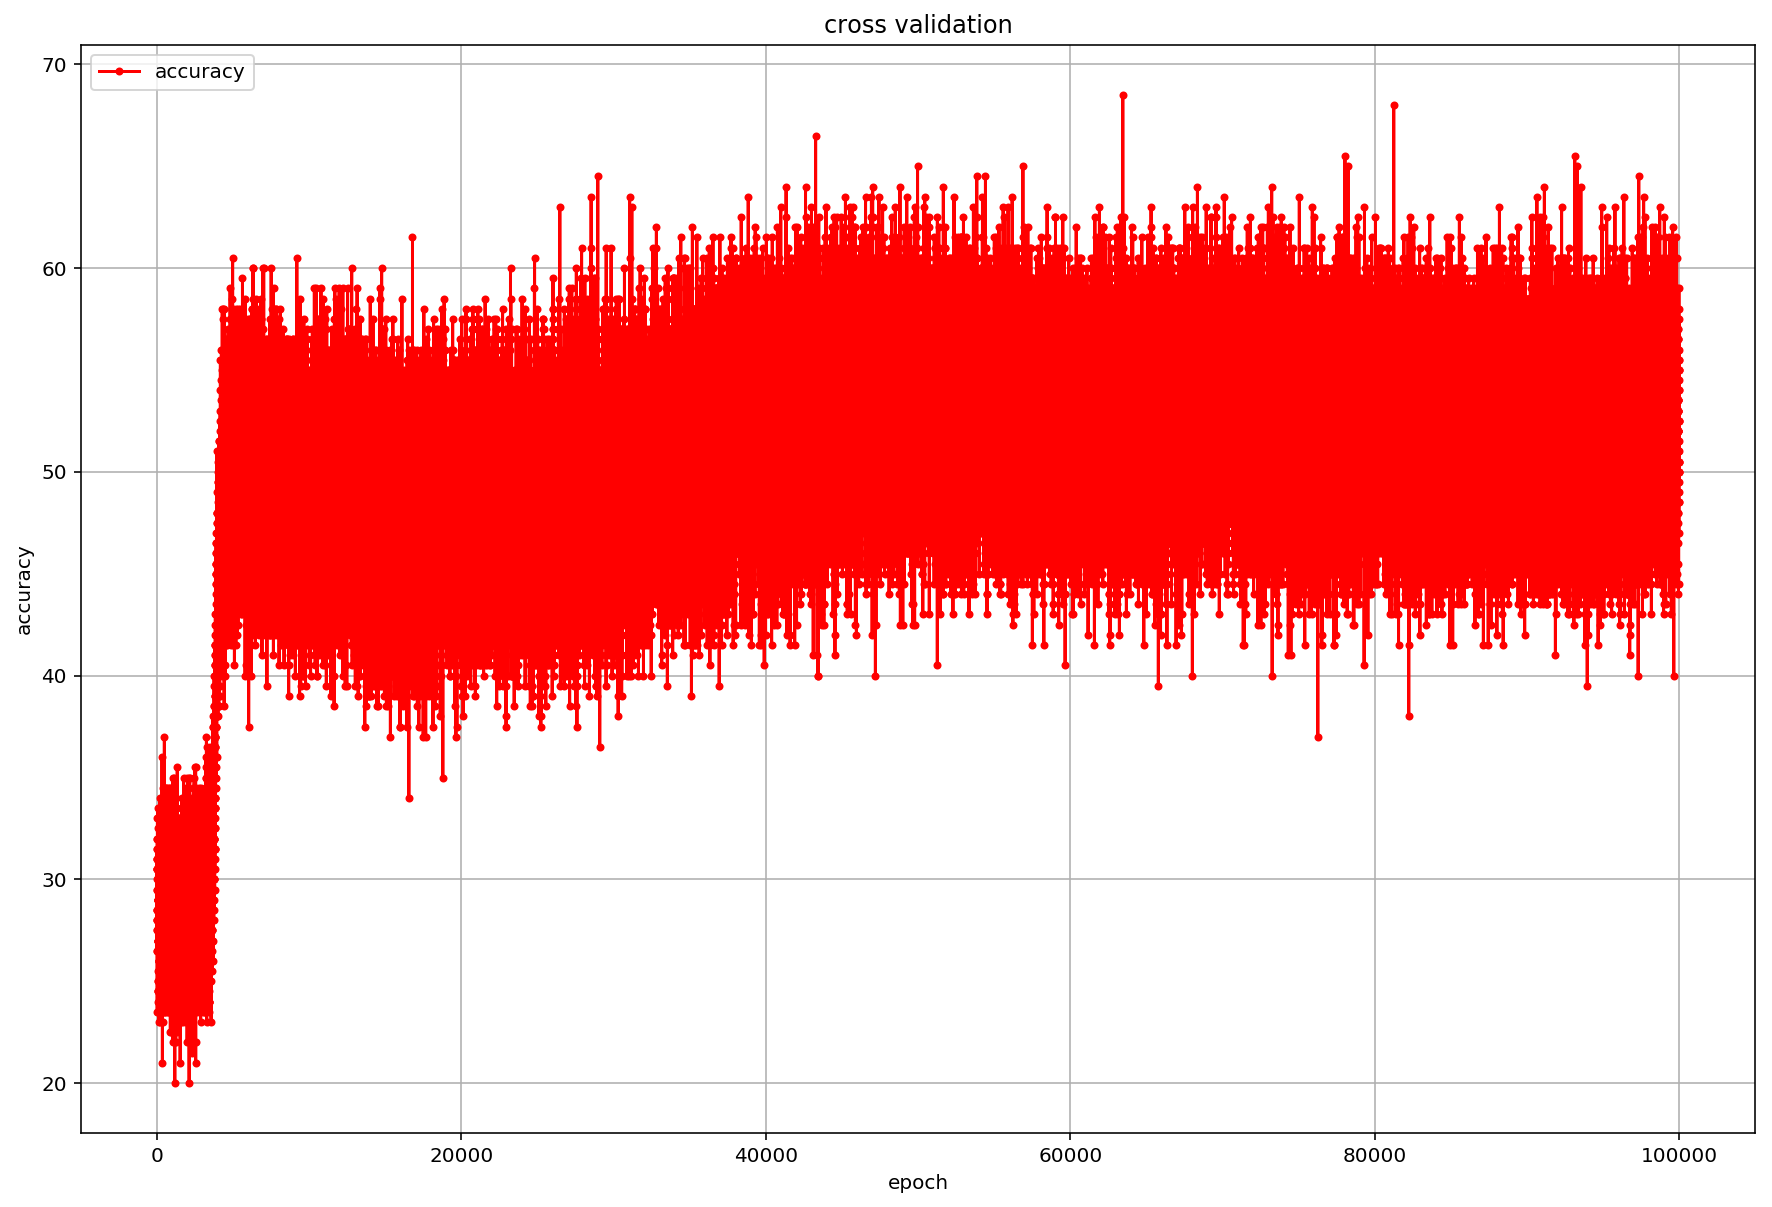

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

## 1er run 14.12.18

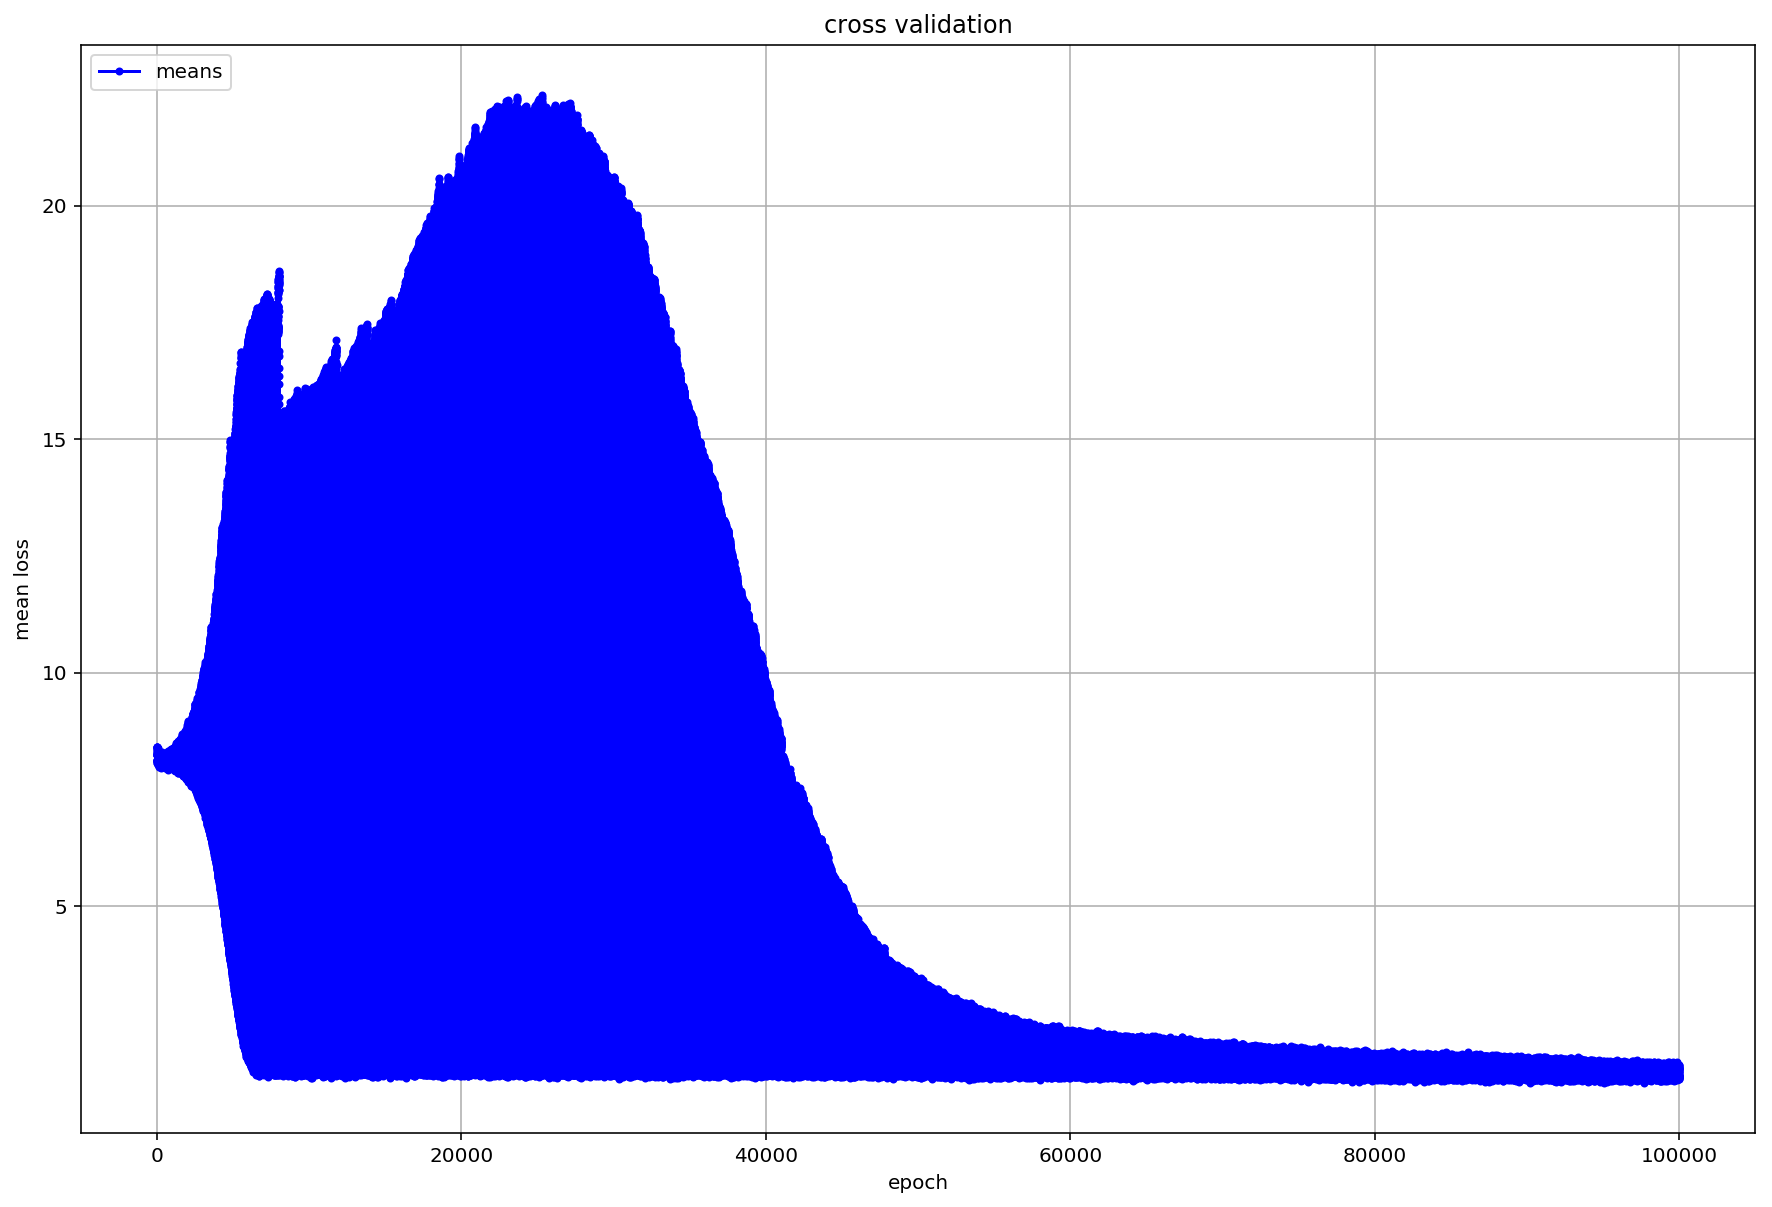

In [16]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

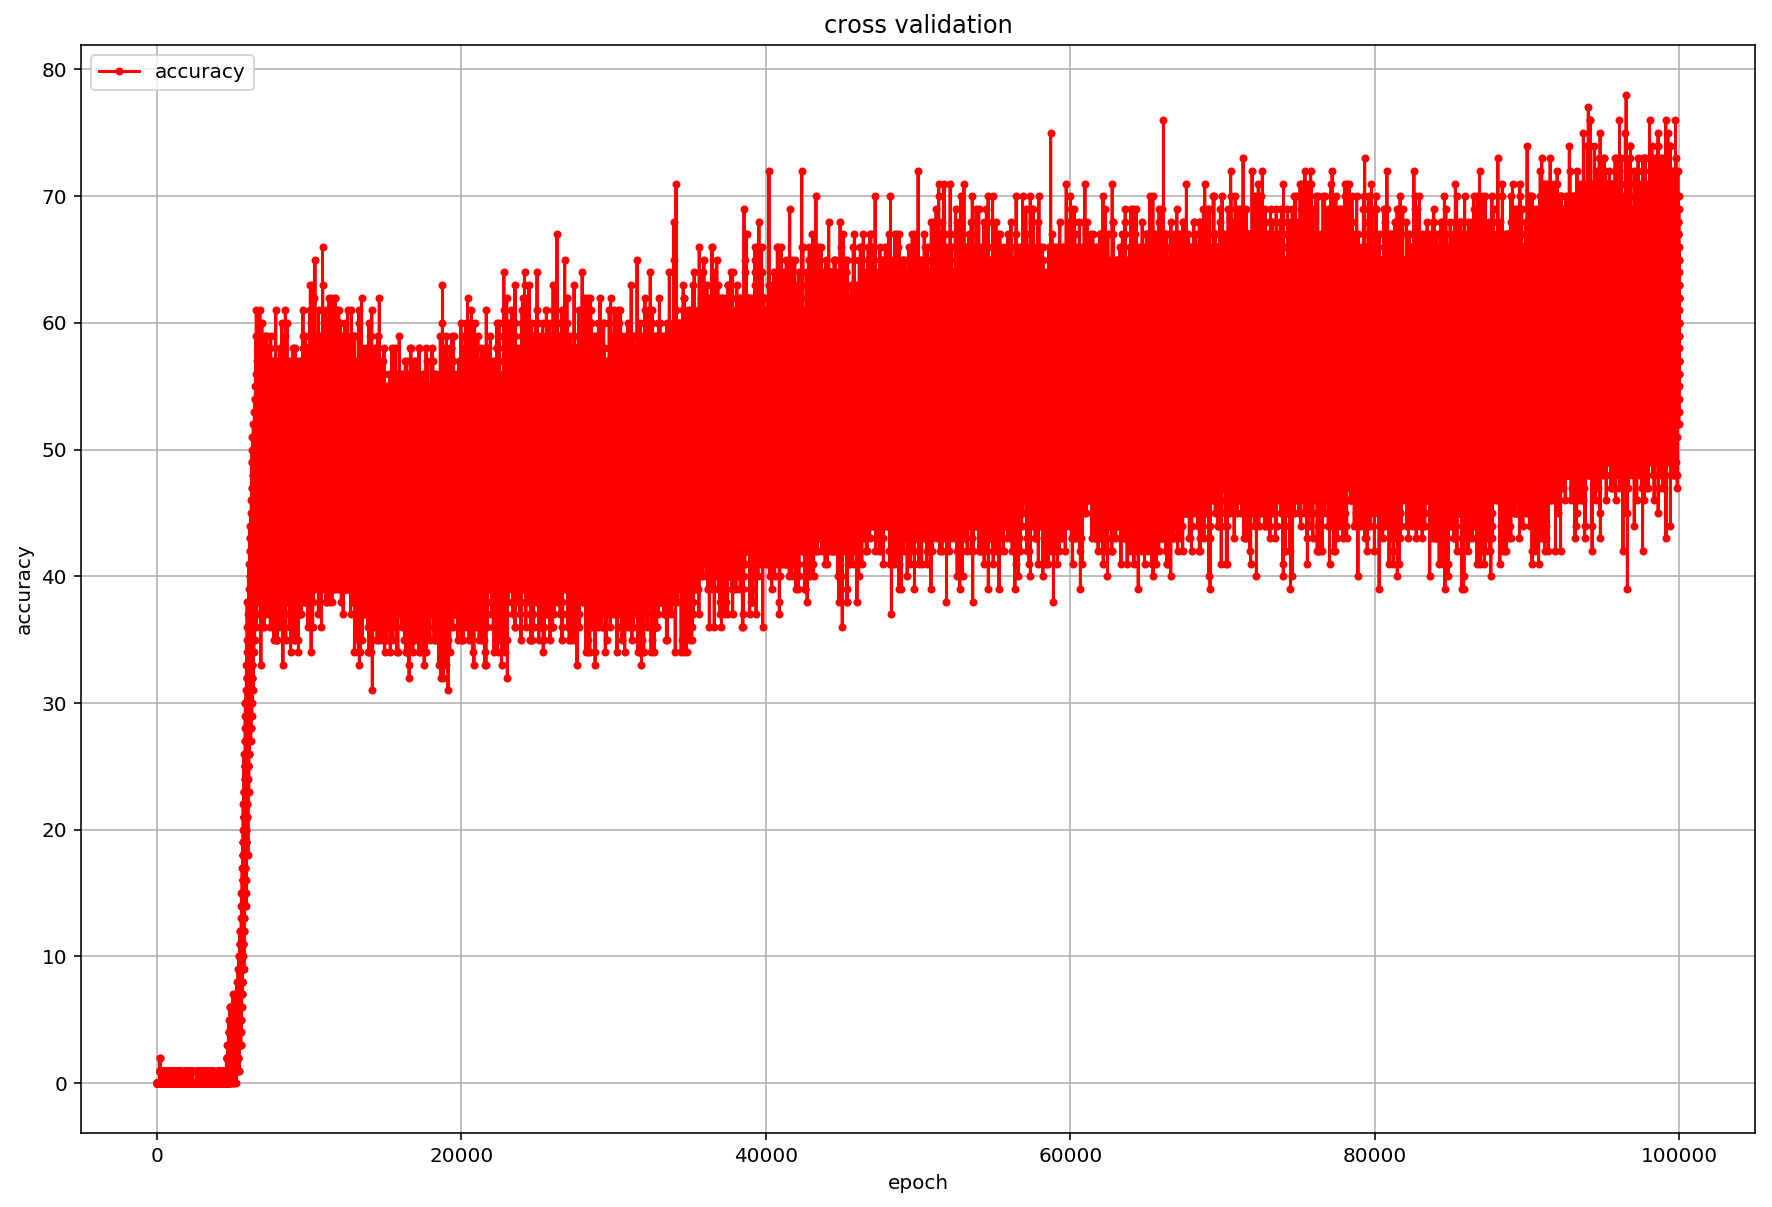

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

## Random sample enlevé dans le validation set

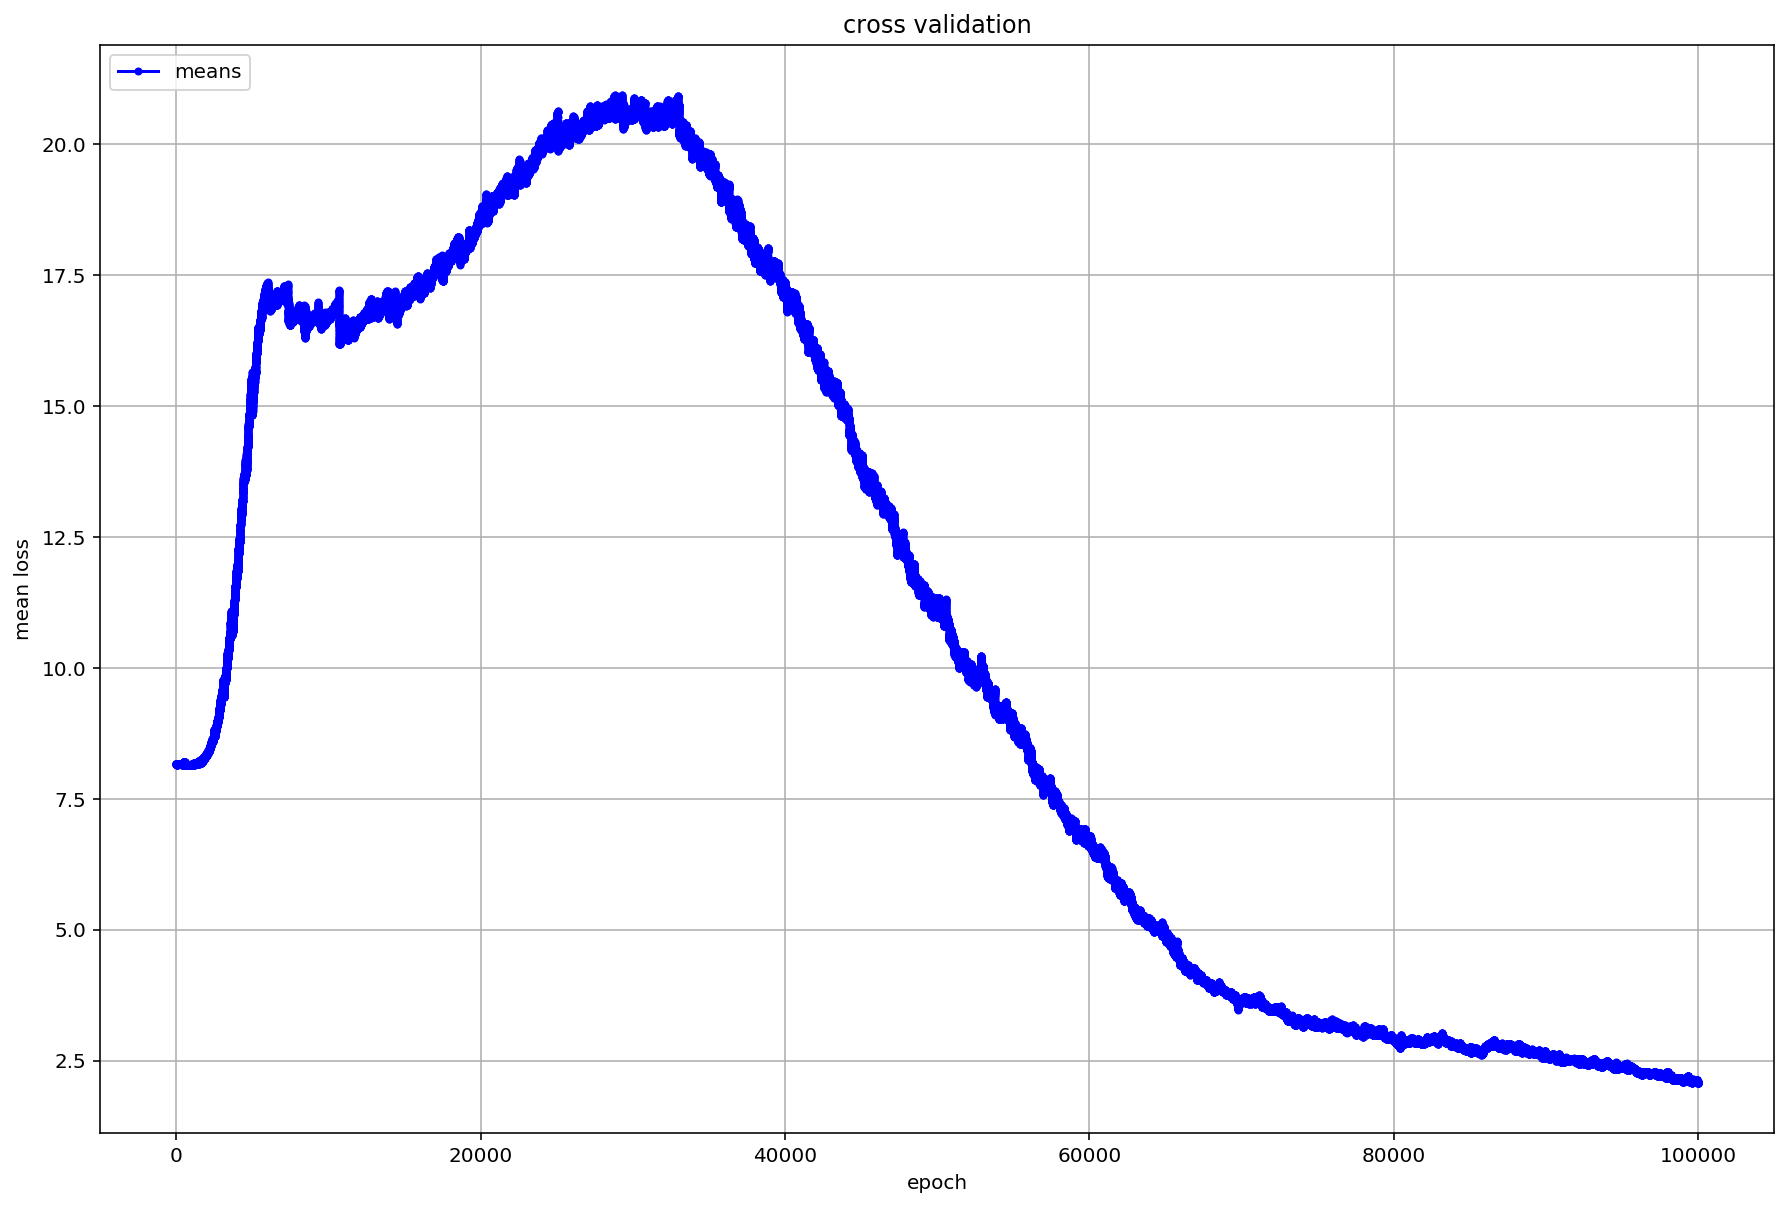

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

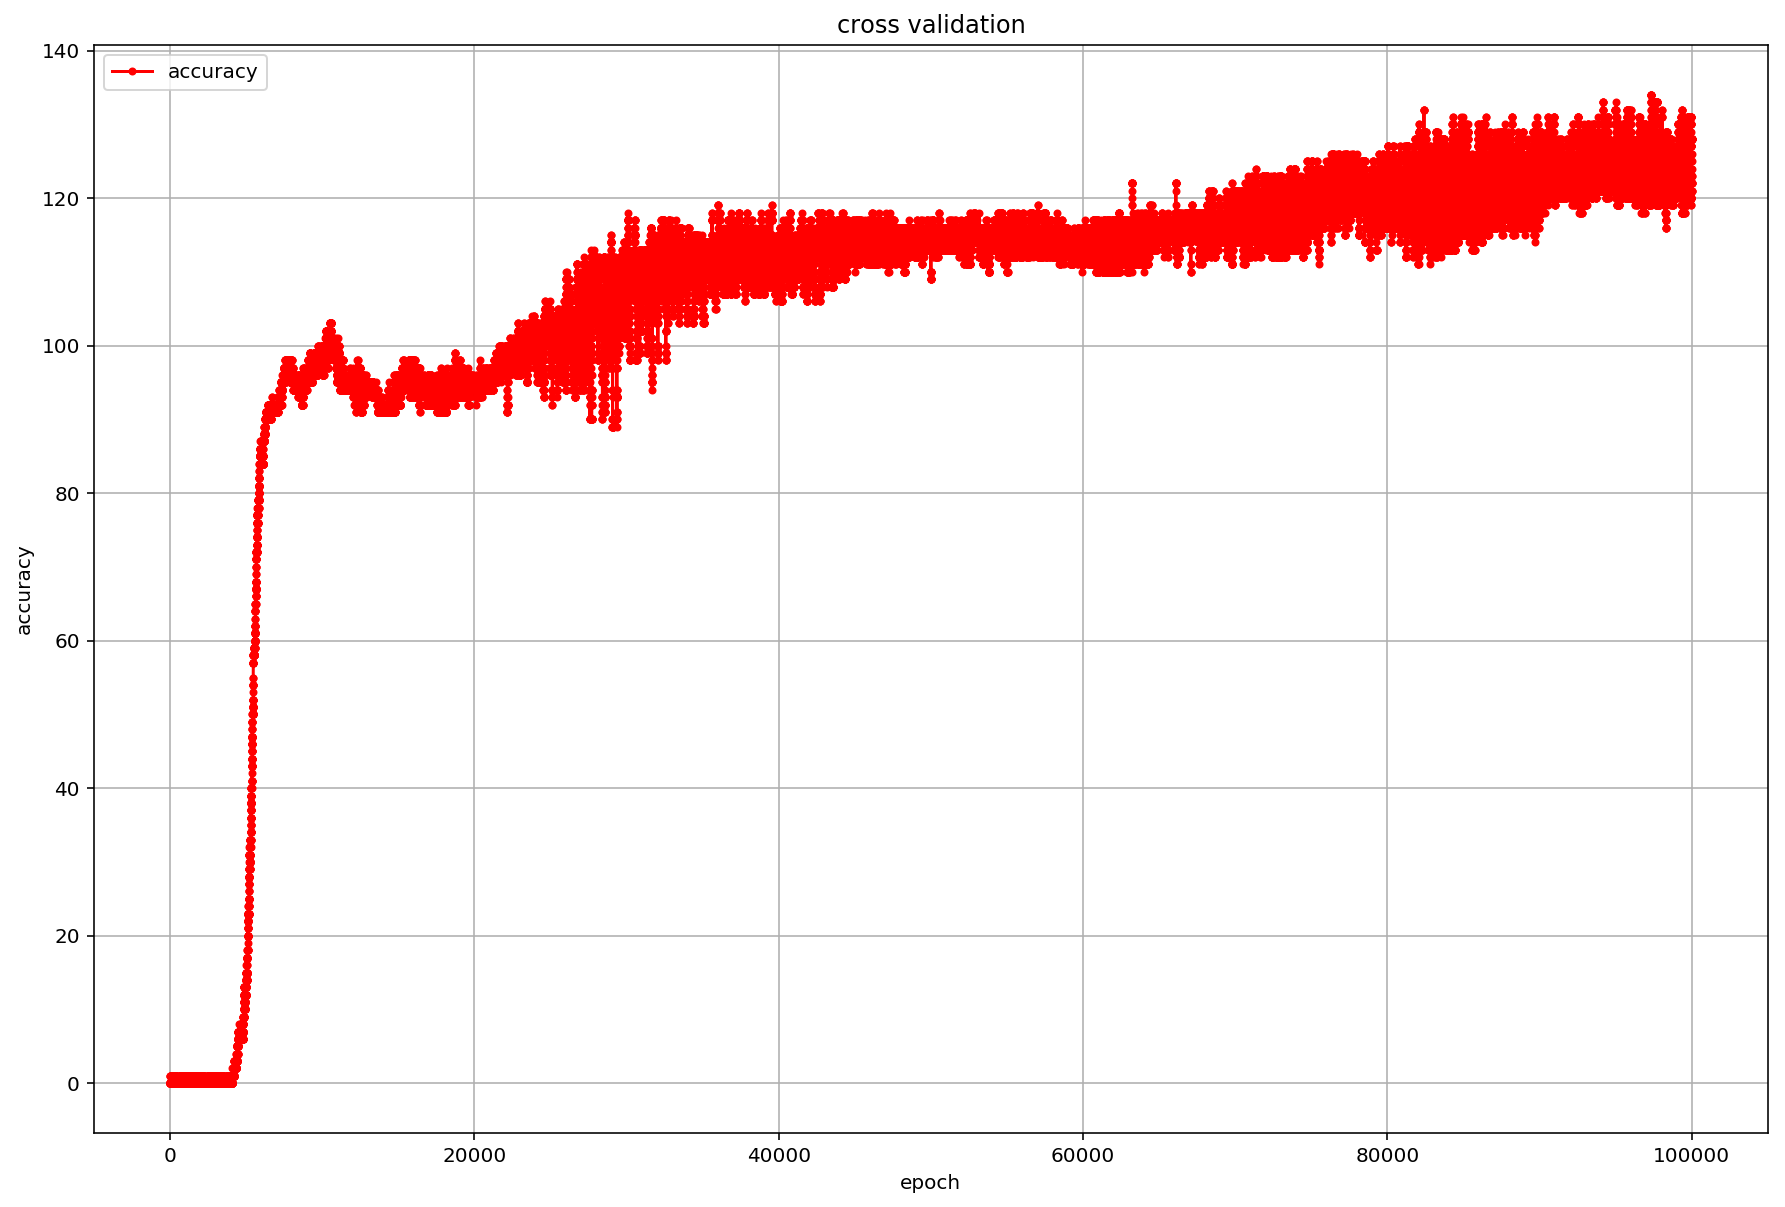

In [8]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

### 2nd try

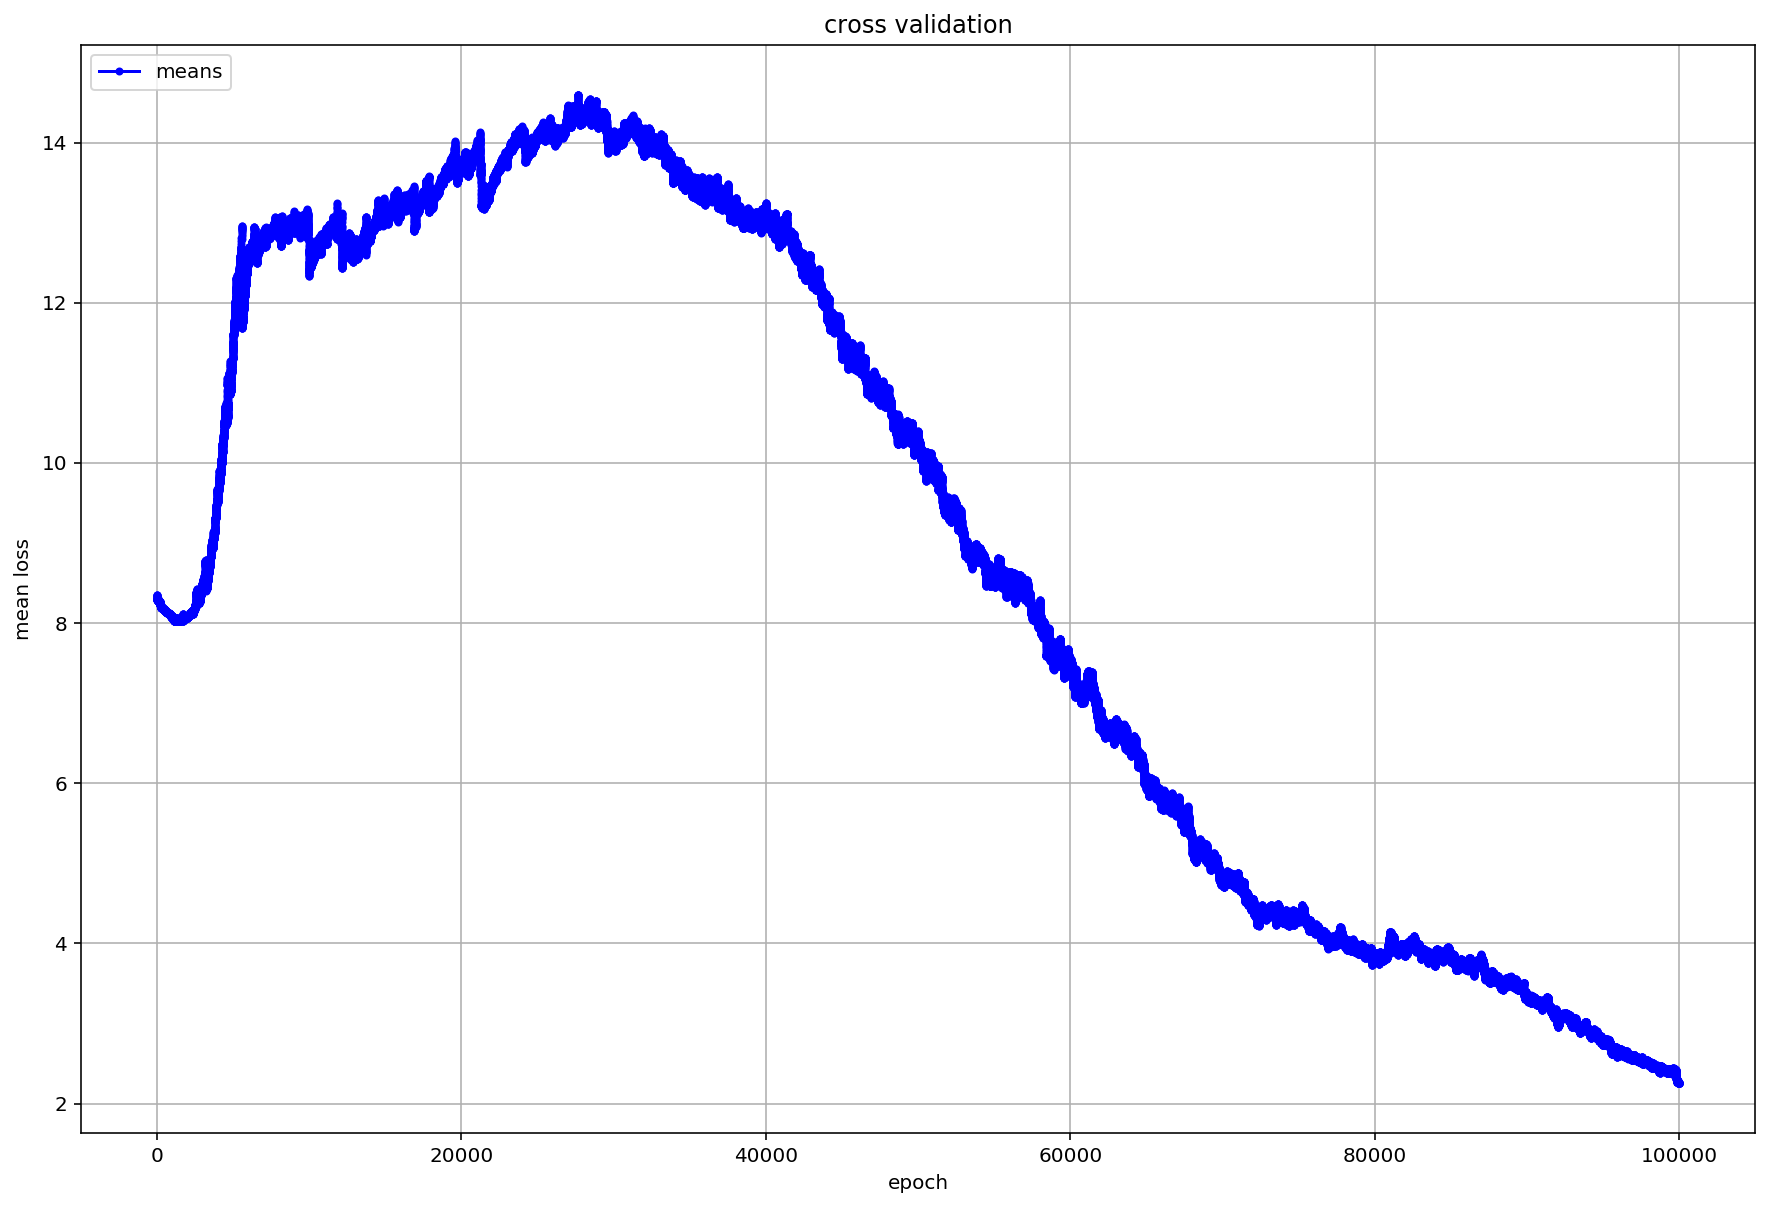

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

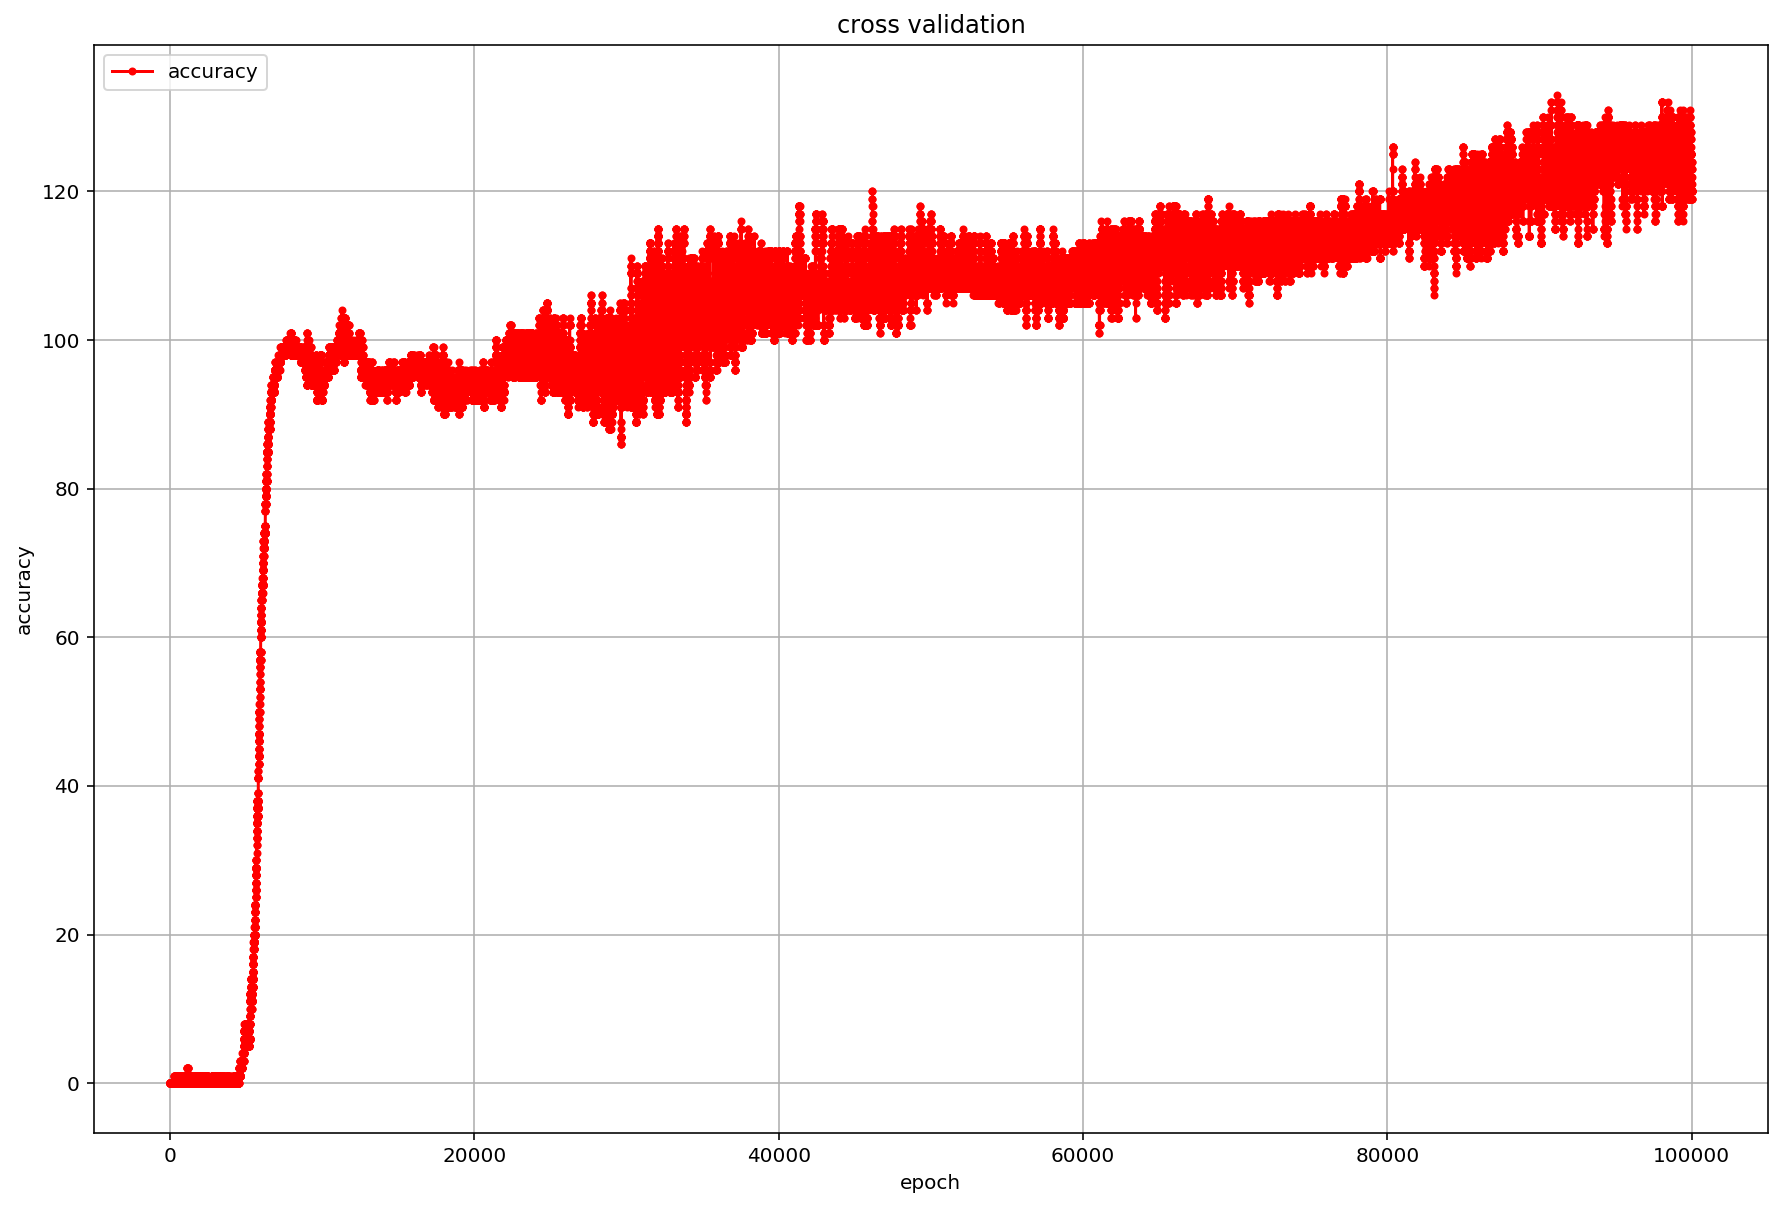

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

### 3rdtry

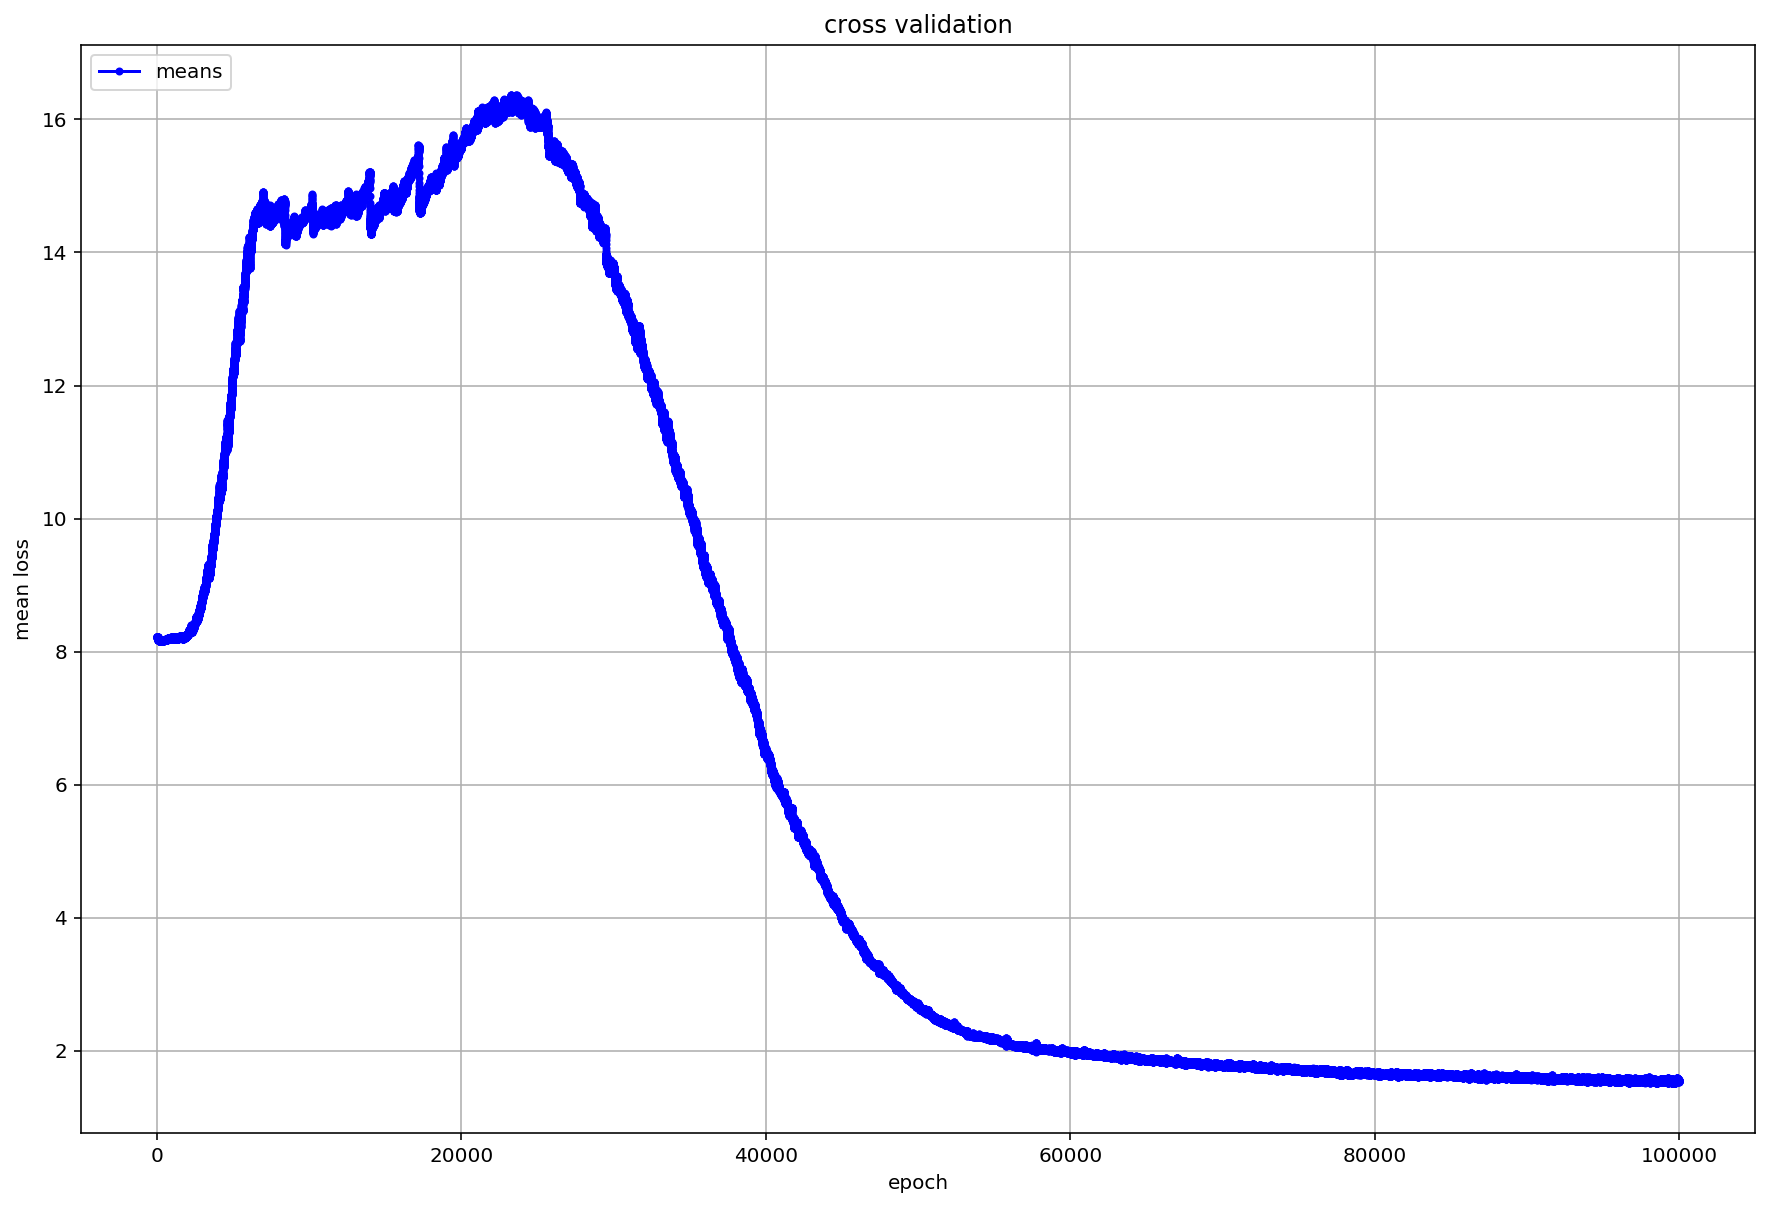

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b.values, axis=0))

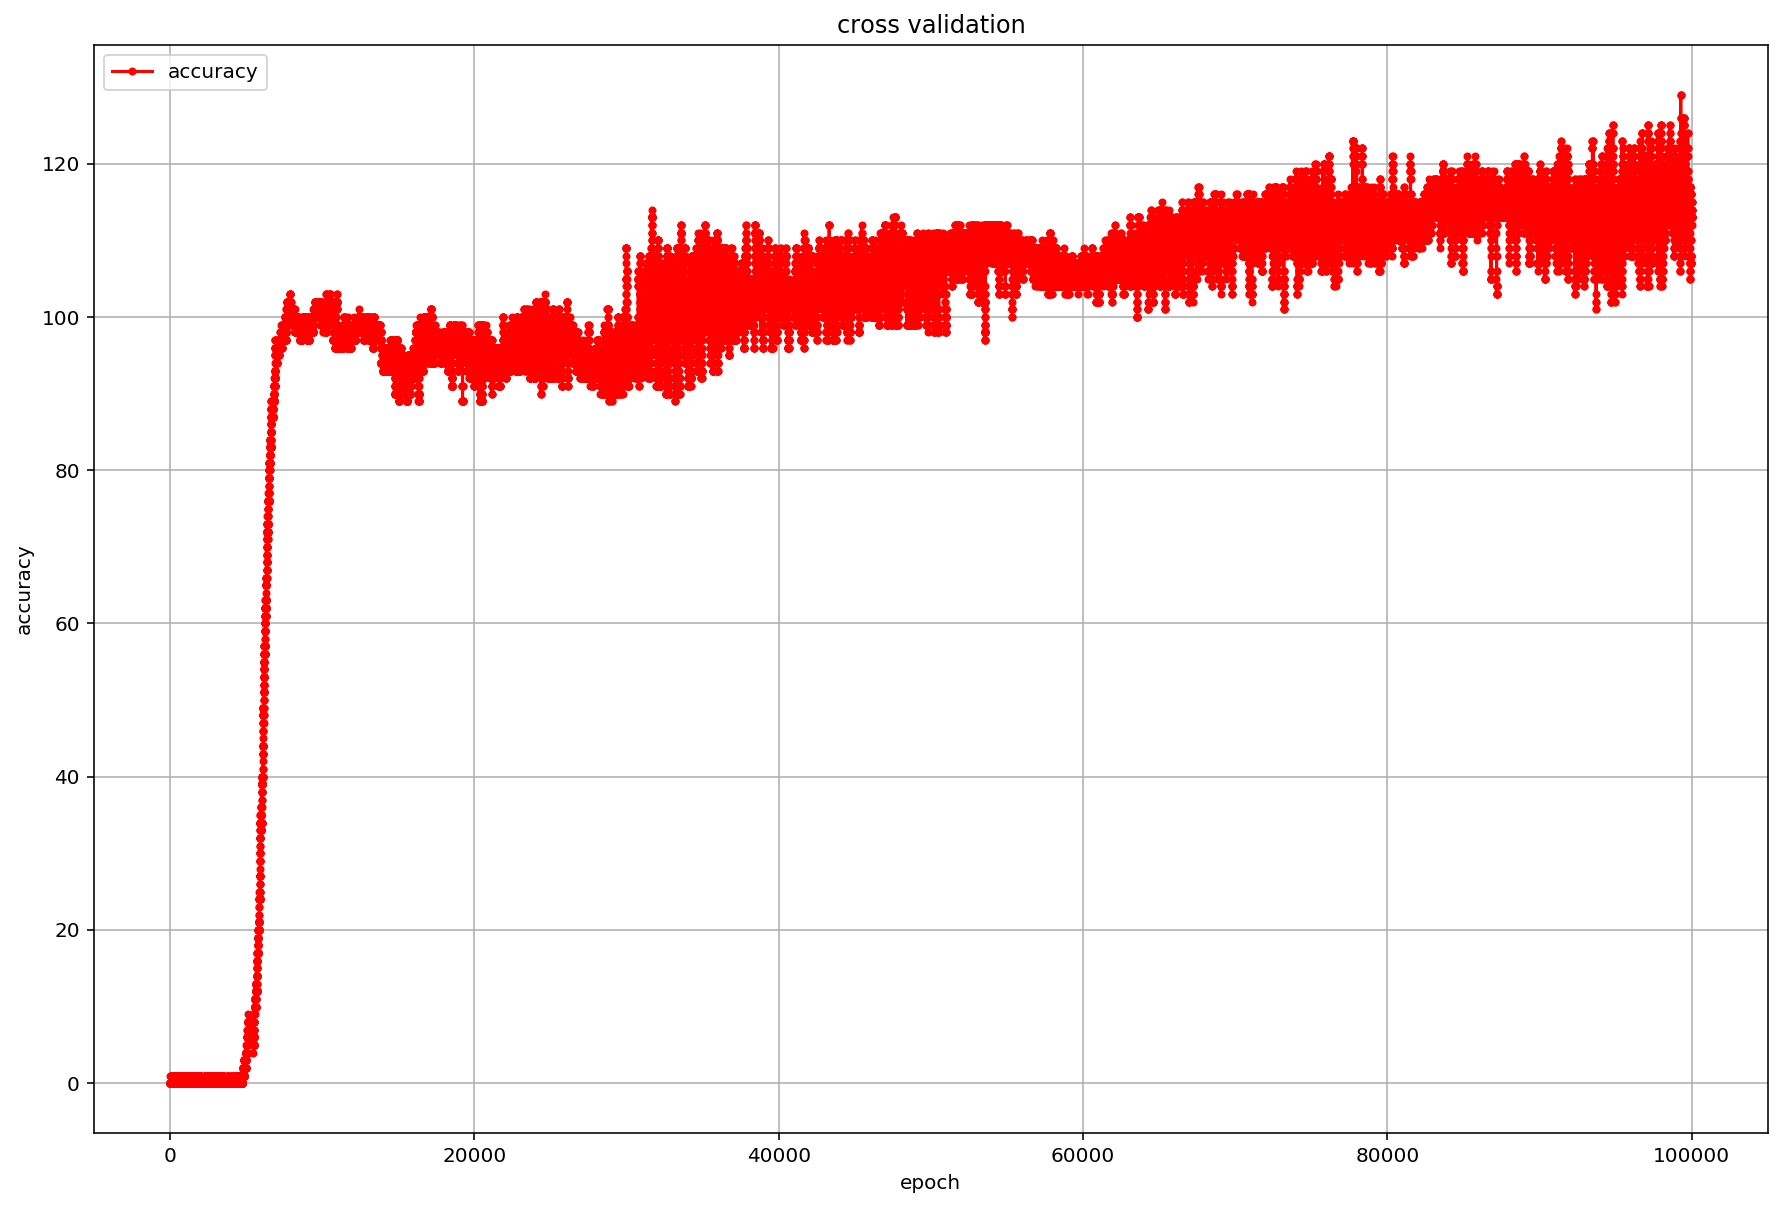

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c.values, axis=0))

### Accuracy correction 15.12.18

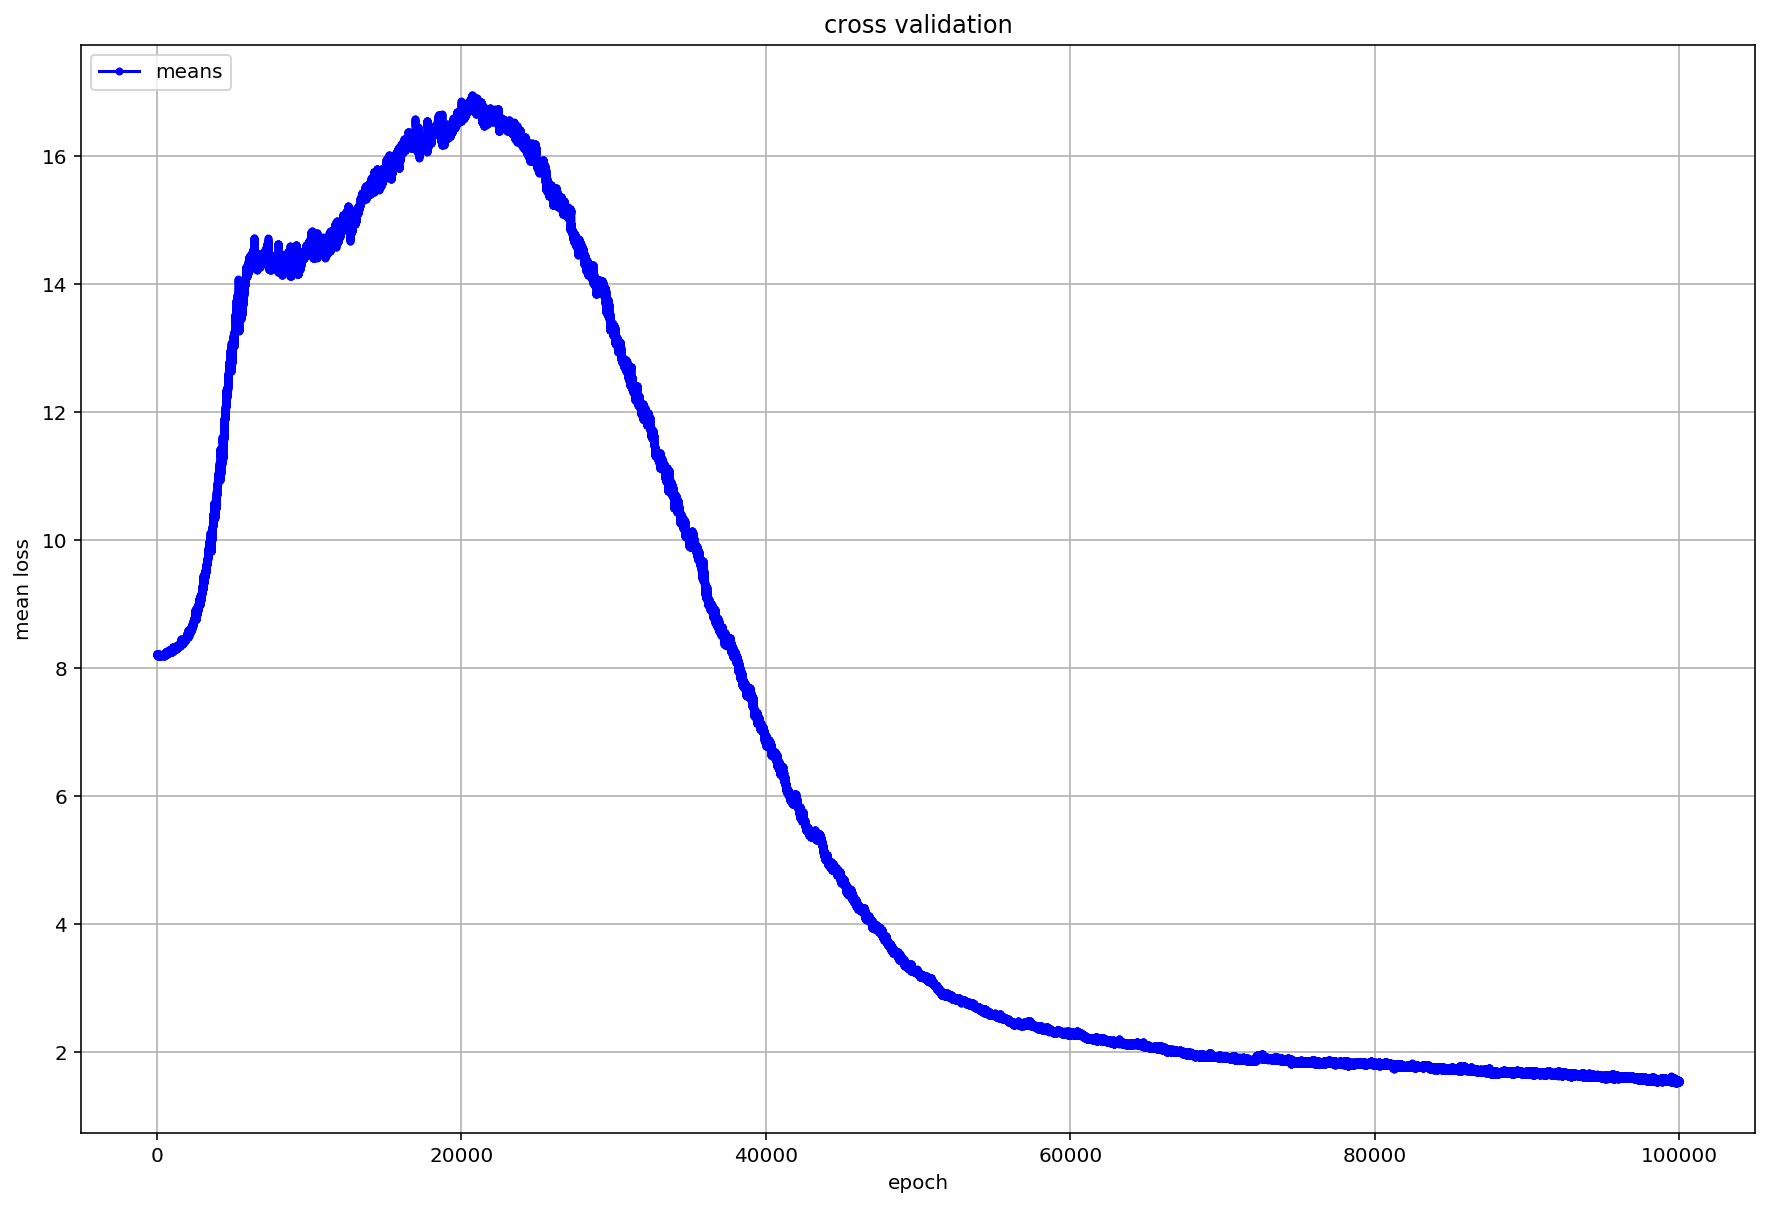

In [9]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b, axis=0))

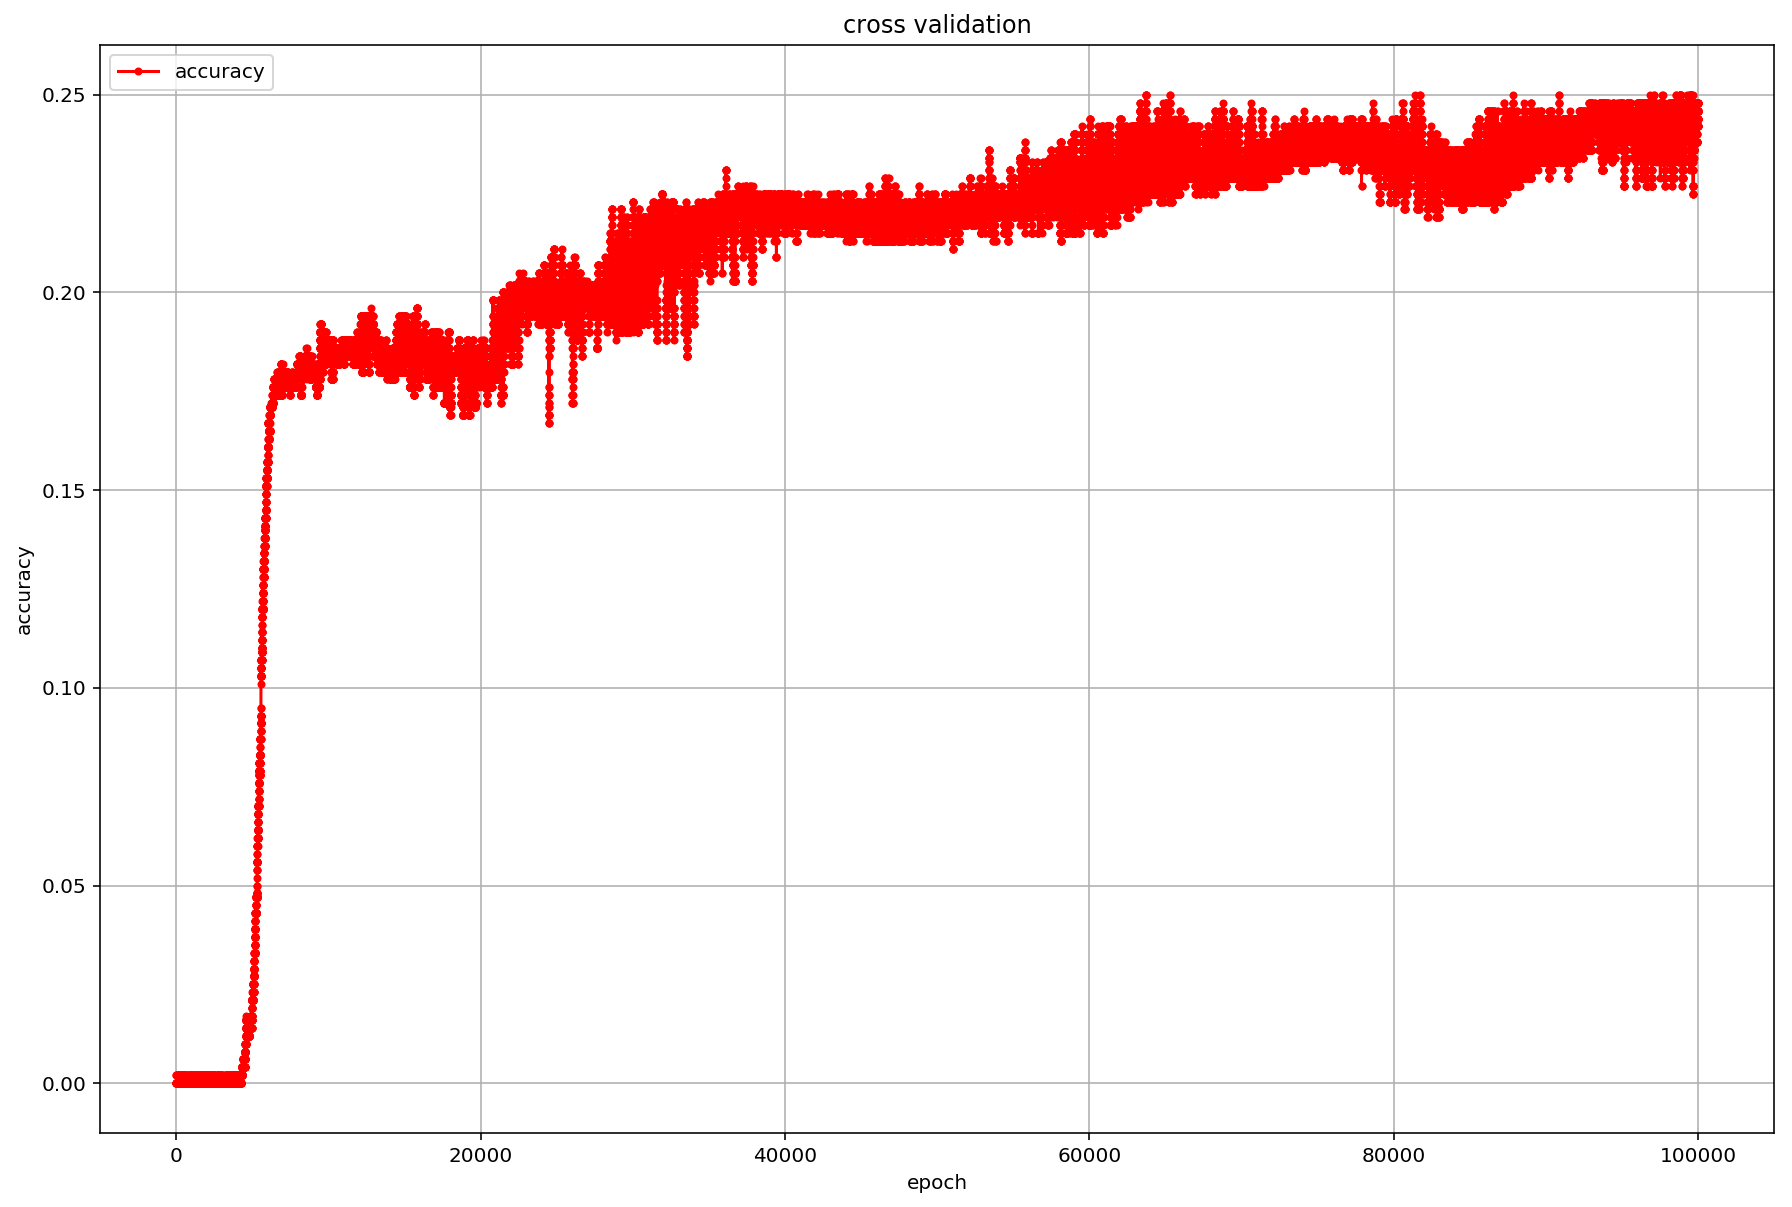

In [10]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c, axis=0))

### 200'000 epochs
accuracy now corrected, dropped to about 25%

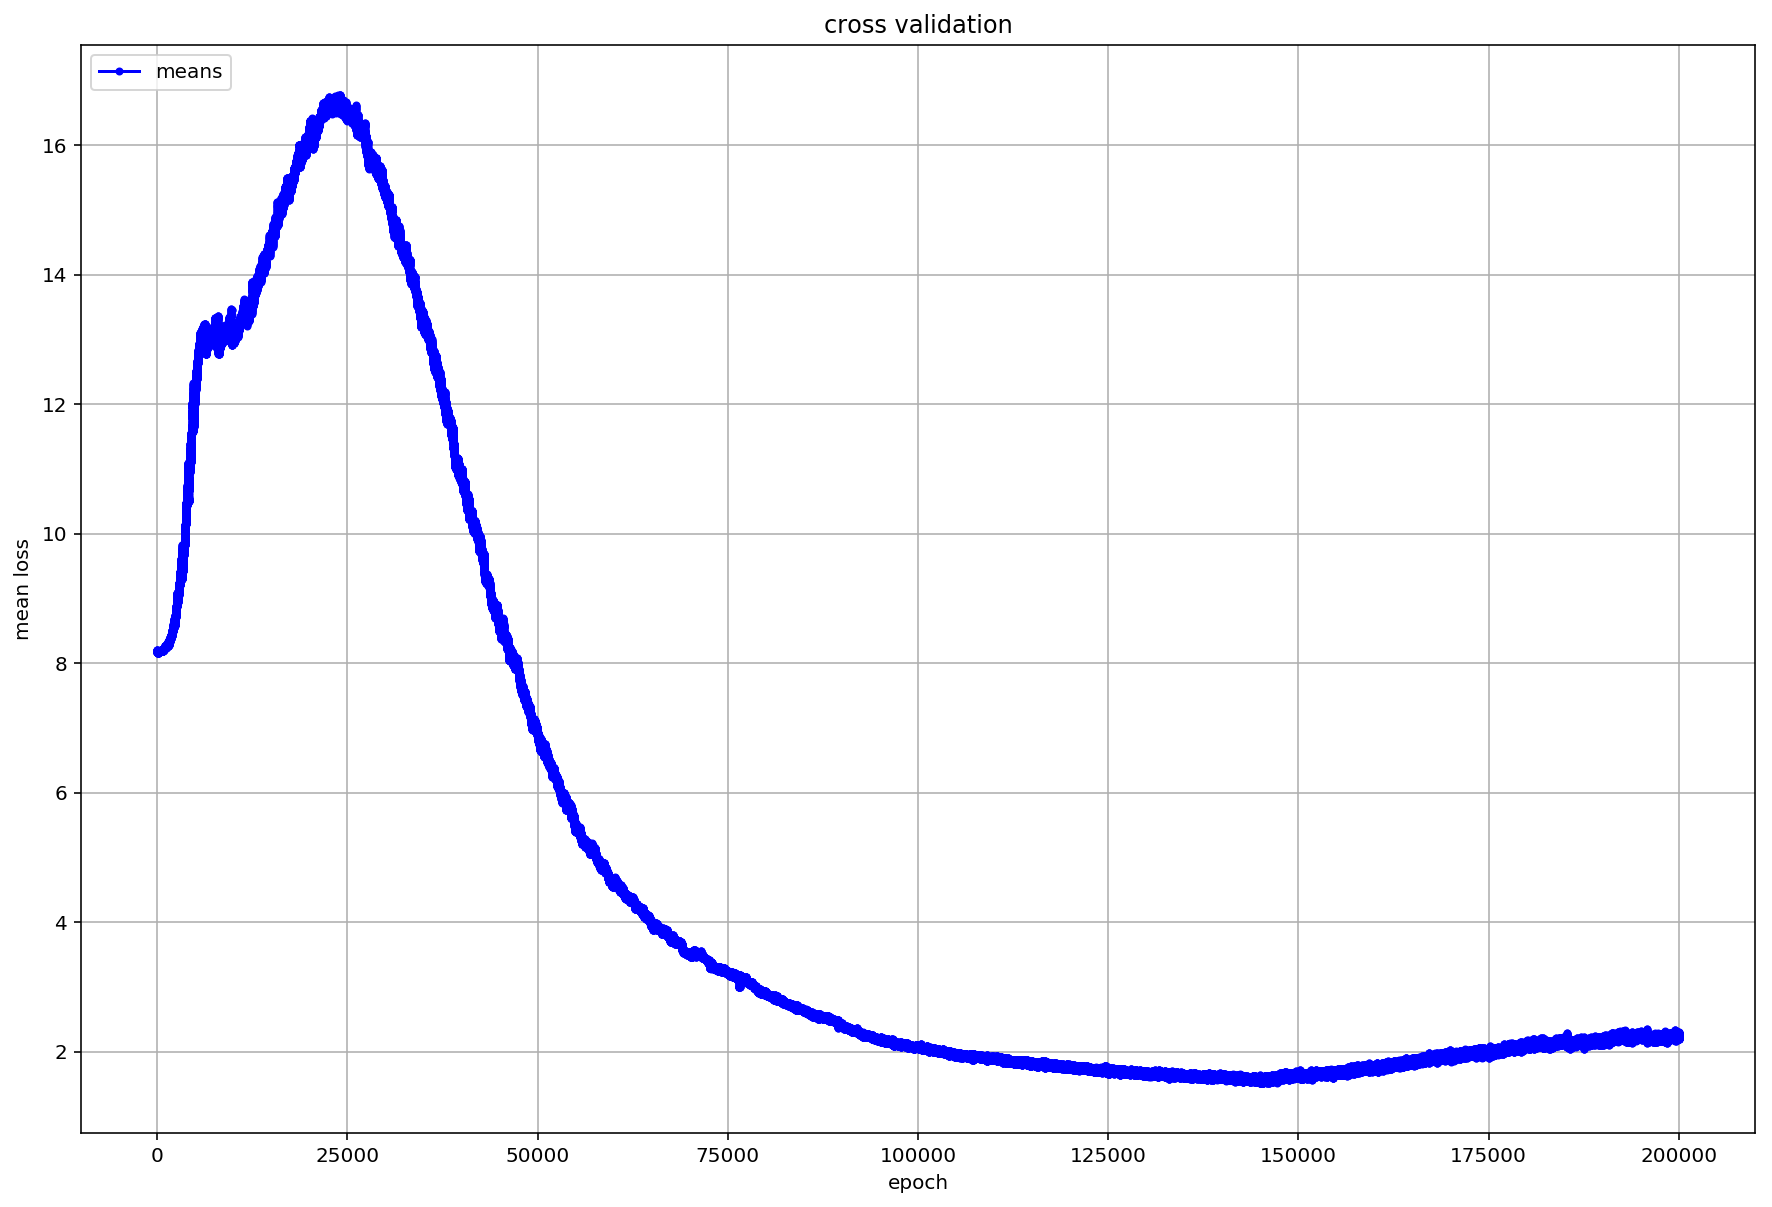

In [6]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b, axis=0))

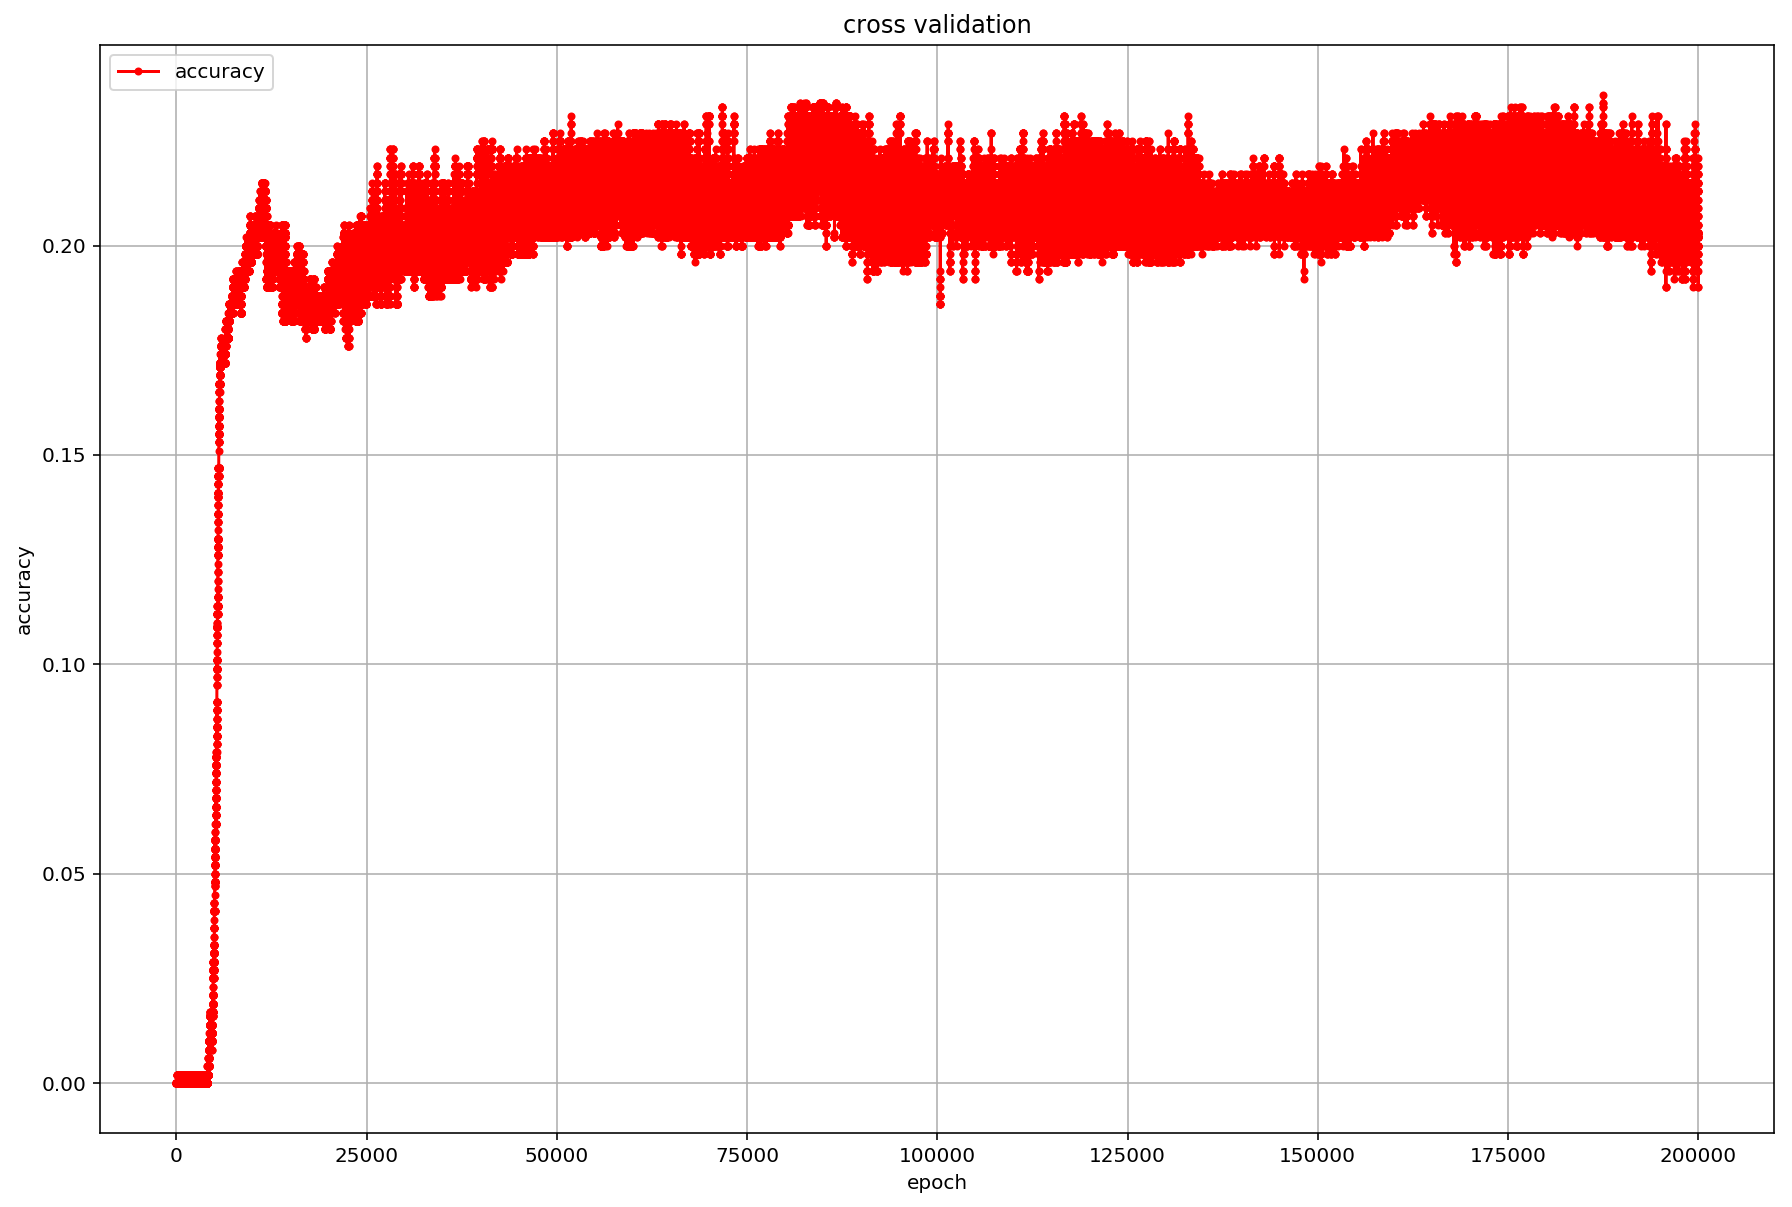

In [7]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c, axis=0))

### 200'000 epochs
1e-5 lambda

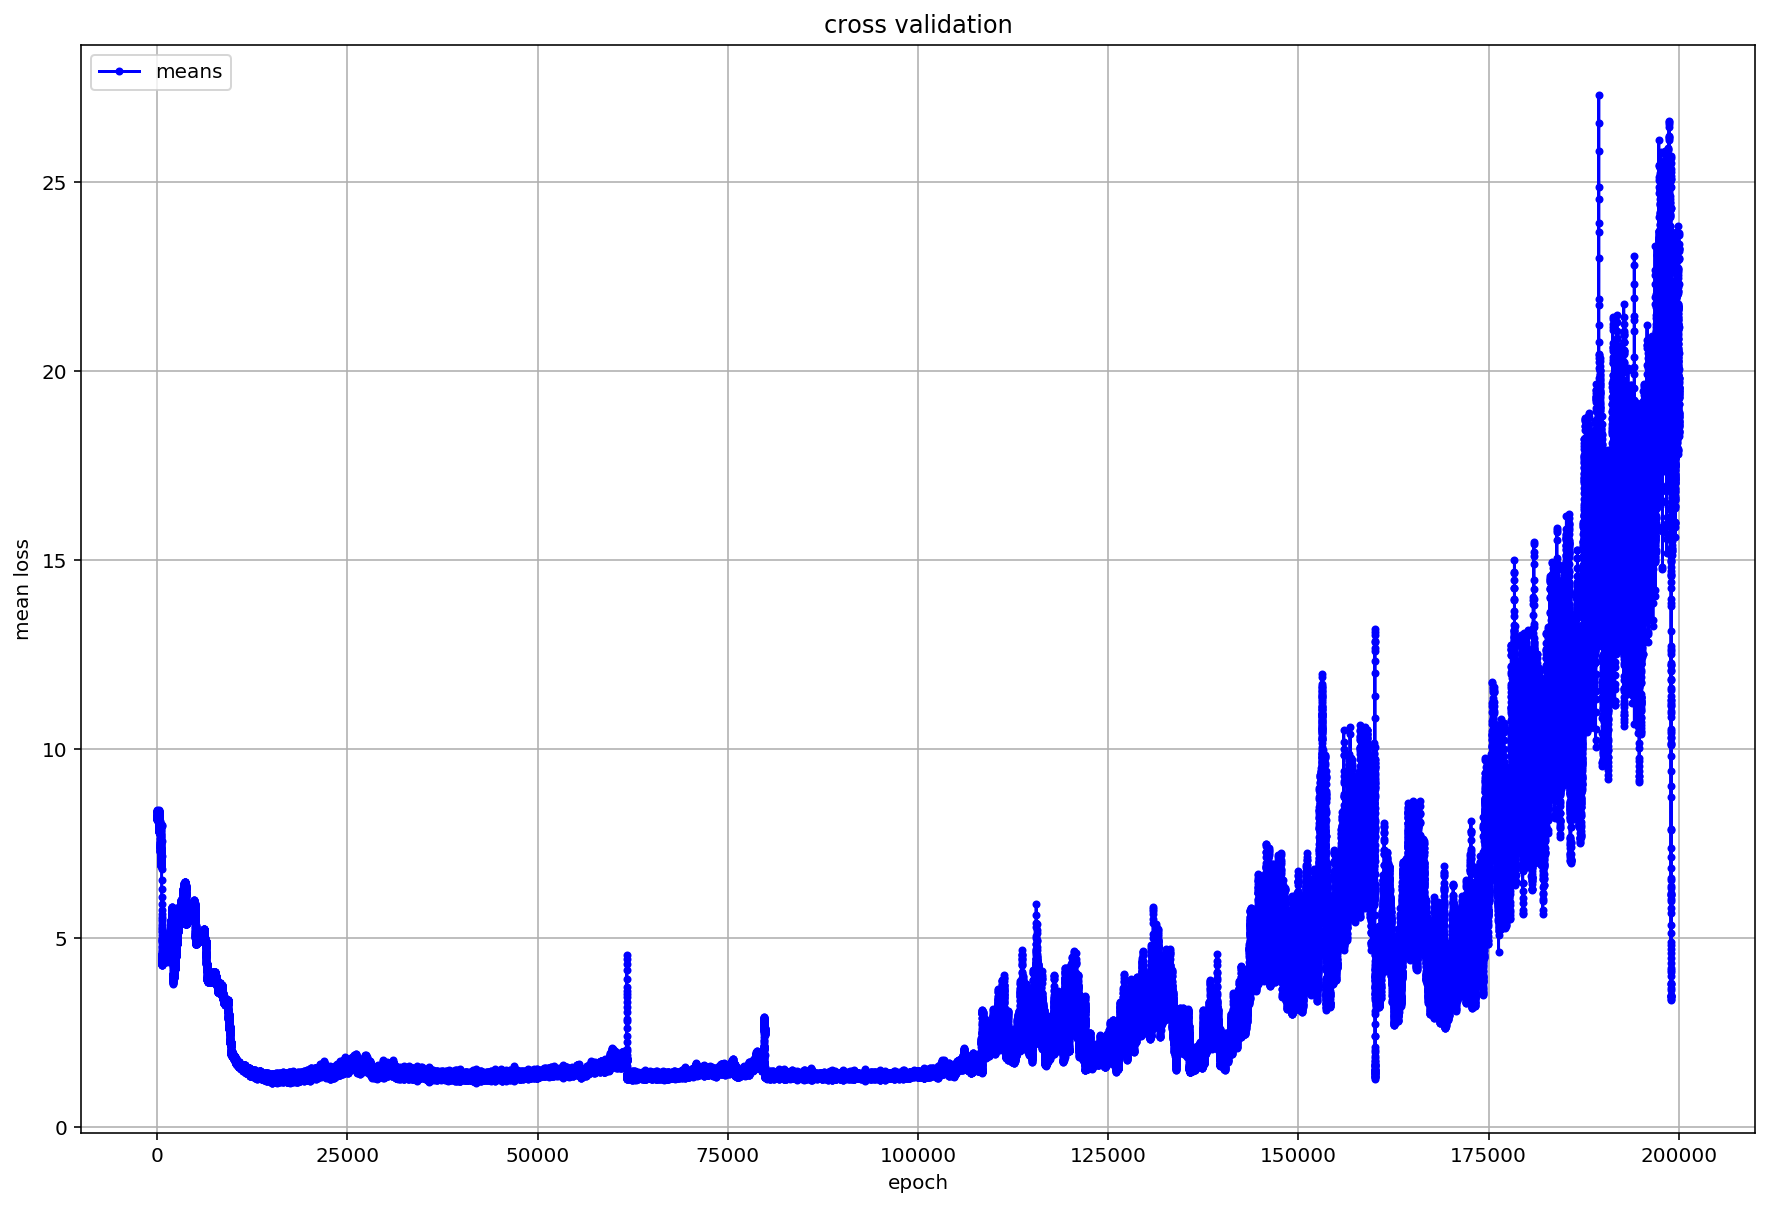

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b, axis=0))

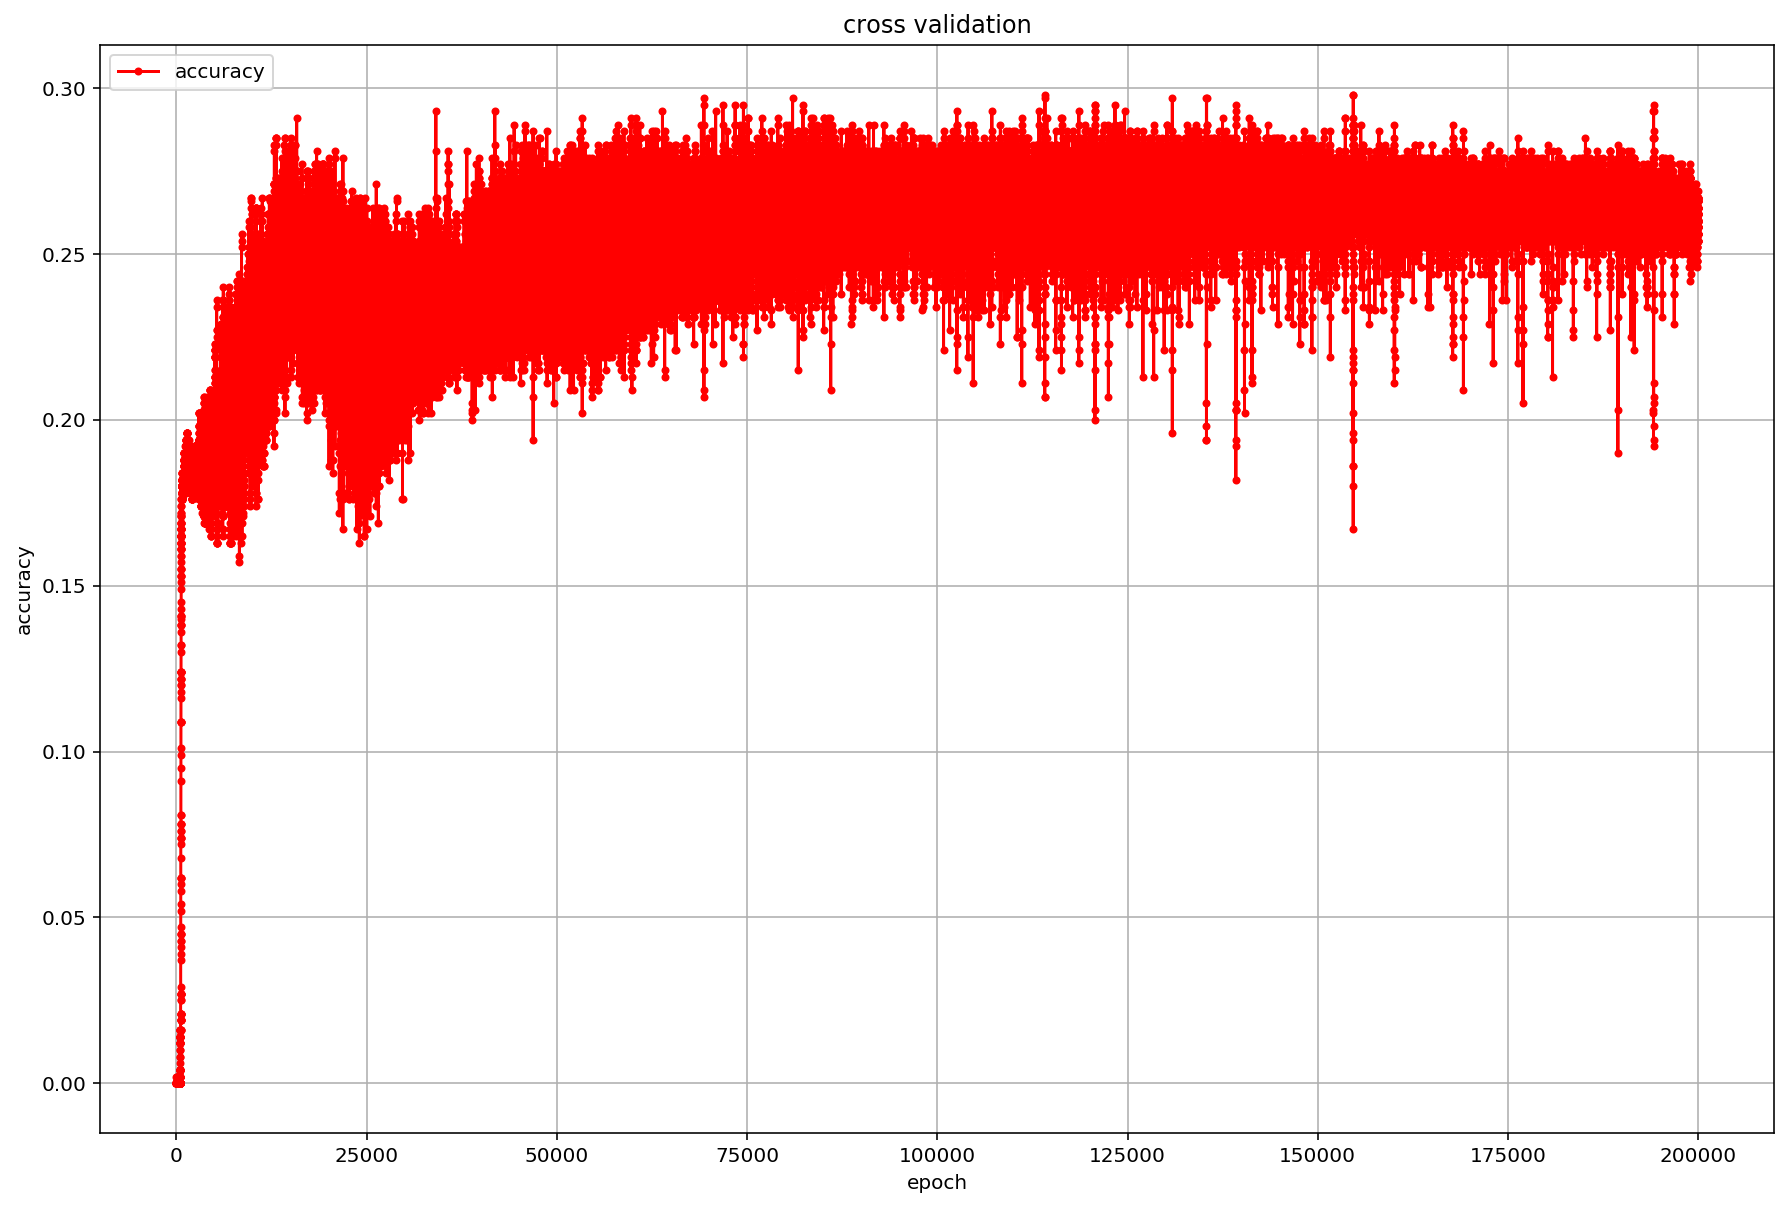

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c, axis=0))

### 200'000 epochs
1e-7 lambda

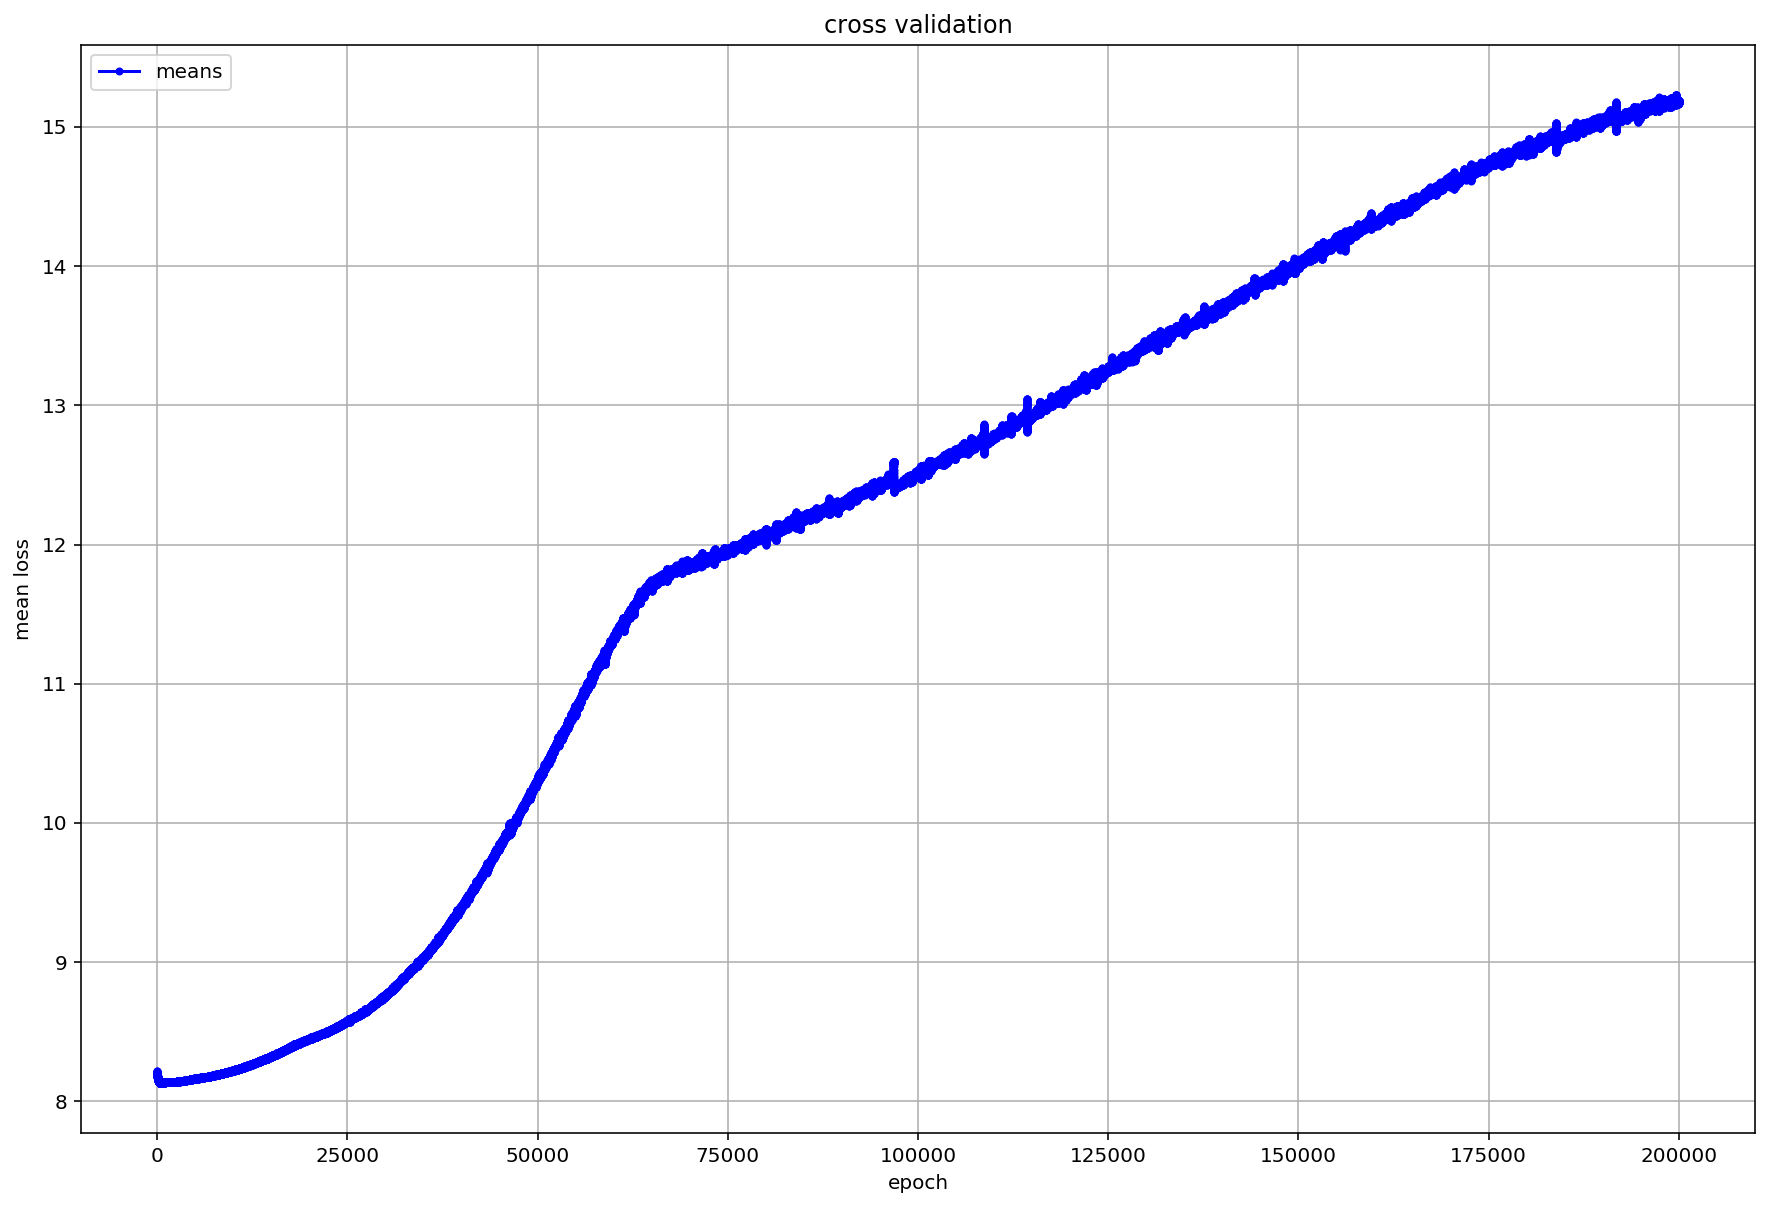

In [4]:
cross_validation_visualization_mean(np.arange(epochs), np.mean(b, axis=0))

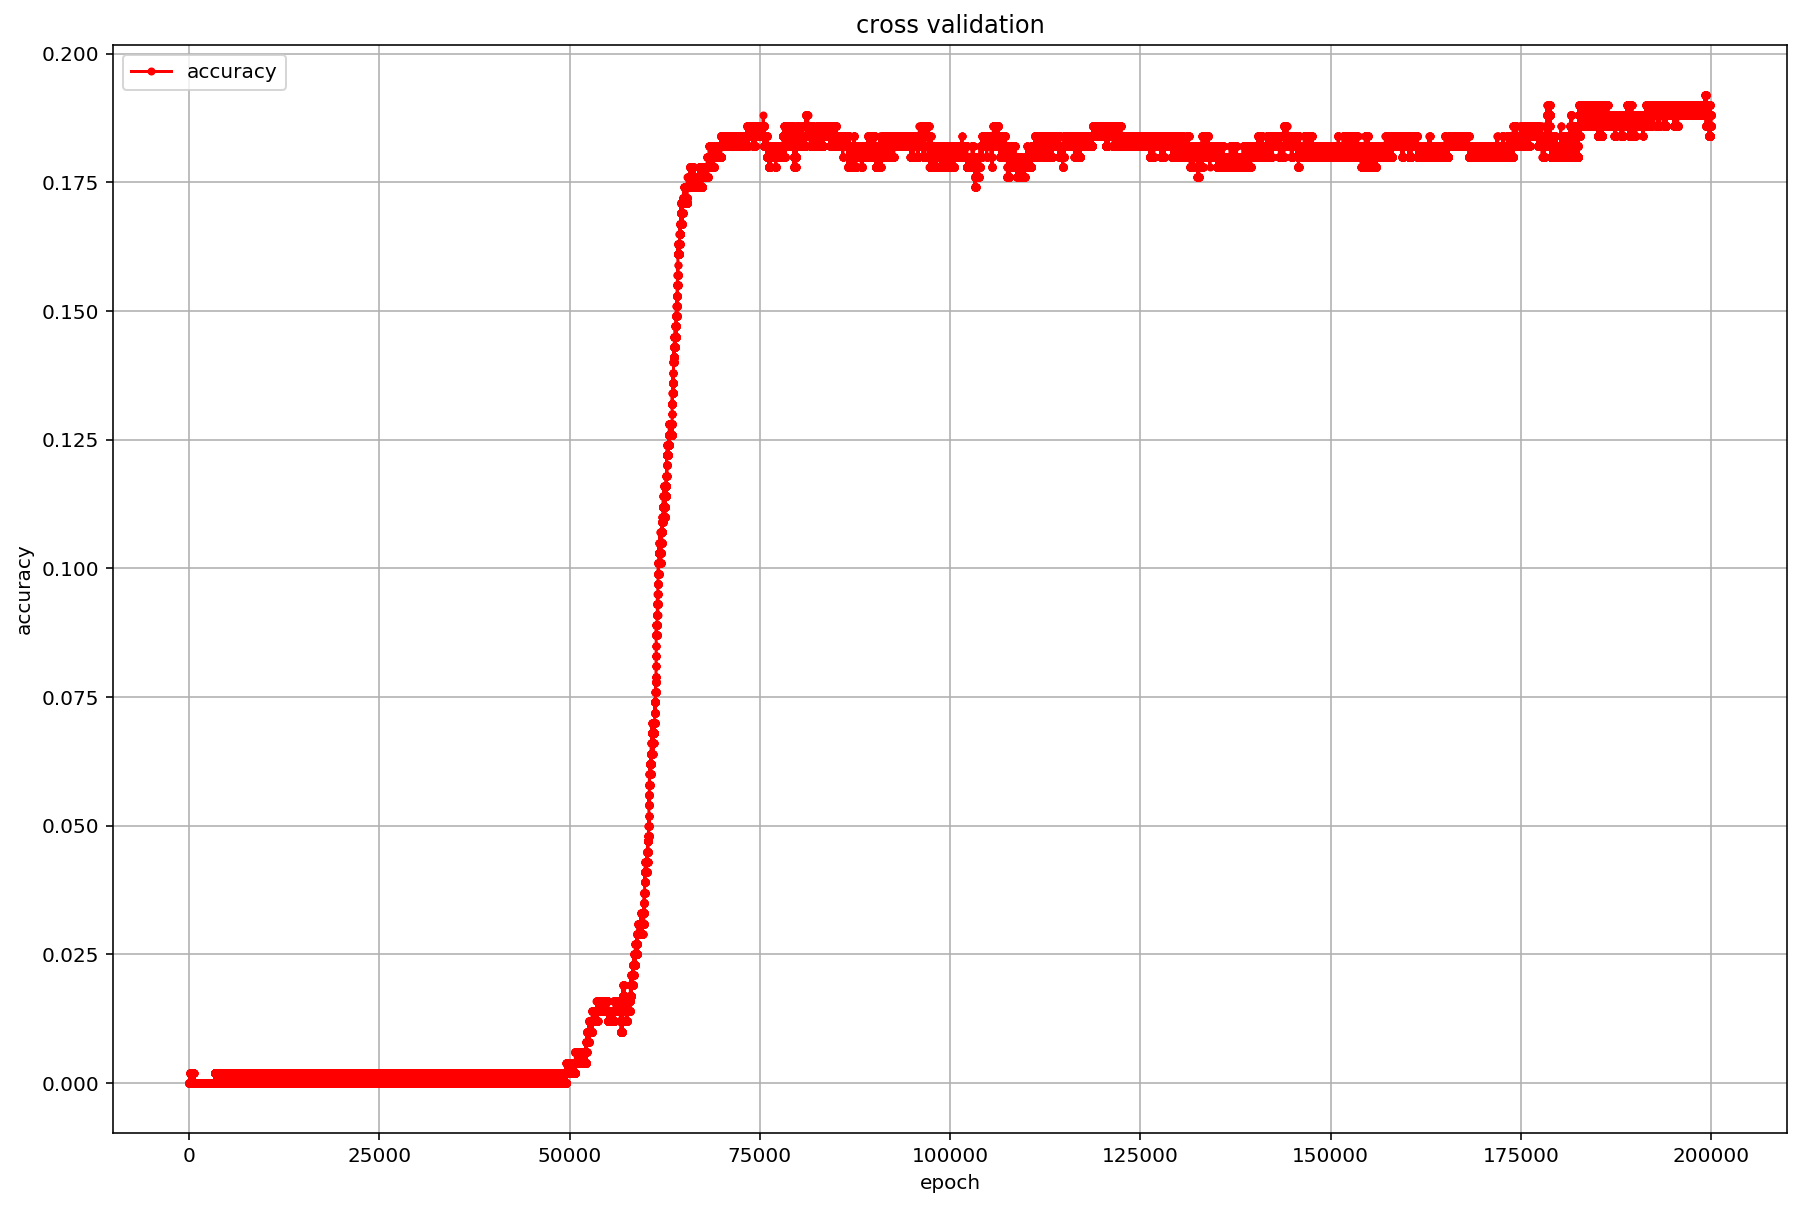

In [5]:
cross_validation_visualization_accuracy(np.arange(epochs), np.mean(c, axis=0))

# Rajouter les autres caméras pour la lesson 02
Rajouter une dimension supplémentaire dans le dict pour avoir une list de dict, qui correspond à chaque fois à chaque caméra avec l'indice correspondant ? Et rajouter le numéro des caméras quelque part dans la matrice ?
Il faut rajouter dans l'extraction de data la numéro de caméra dont cela provient, et ensuite utiliser ce numéro pour accéder au bon dict des positions (un pour chaque caméra)

In [ ]:
# nouveau dict, composé d'une liste de dict

#créer une méga matrice avec toutes les coordonnées

#changer la fonction pour append les y



# 

# Doubler la data en faisant de l'interpolation linéaire

# Essayer d'intégrer la direction des regards pour améliorer le NN
Où est la data correspondante ? Comment normaliser la data ? Comment intégrer ça ?

# Jouer avec les paramètres du NN
Lambda, deepeness, nombre de nodes, loss function, optimiser, rajouter des layers de batchNorm, regarder pour layers bilinéaires
lambda semble être le meilleur vers 1e-6 pour l'instant

# Préparer l'output final pour être l'image introduite avec le niveau d'attention au-dessus de la tête des gens